In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import  DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import scipy.io
import os

/Users/mclinwong/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Seed is important, especially training the CNN+ReLU Net
#Otherwise, the results will be very different
myseed = 8974  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [3]:
#Train&Test Data library
matlib = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib'
#Path to save figures
figure_savepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
#Path to save the model
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
num_epoch = 600
batch_size = 64
# load model
# autoencoder = torch.load('/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/matlib/11_22/autoencoder.h5')

In [4]:
datapath = os.path.join(matlib, 'data2_trainlow.mat')
read_data = scipy.io.loadmat(datapath)
S_est = read_data['S_est']
S_abs = read_data['S_abs']
S_label = read_data['S_label']
R_est = read_data['R_est']
S_label1 = np.expand_dims(S_label, 2)
[Sample, L, dim] = np.shape(S_est)
S_est = S_est.transpose(0, 2, 1)
S_label1 = S_label1.transpose(0, 2, 1)

print(f'S_est.shape: {S_est.shape}')
print(f'S_abs.shape: {S_abs.shape}')
print(f'S_label.shape: {S_label.shape}')
print(f'S_label1.shape: {S_label1.shape}')
print(f'Sample: {Sample}, L: {L}, dim: {dim}')

S_est.shape: (19800, 2, 120)
S_abs.shape: (19800, 240)
S_label.shape: (19800, 120)
S_label1.shape: (19800, 1, 120)
Sample: 19800, L: 120, dim: 2


In [5]:
class MakeDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        label = self.label[idx]
        data = self.data[idx]
        return data, label

In [6]:
S_est_train, S_est_test, S_label1_train, S_label1_test = train_test_split(S_est, S_label1, test_size=0.2)
S_abs_train, S_abs_test, S_label_train, S_label_test = train_test_split(S_abs, S_label, test_size=0.2)
print(f'S_est_train.shape: {S_est_train.shape}, S_est_test.shape: {S_est_test.shape}')
print(f'S_abs_train.shape: {S_abs_train.shape}, S_abs_test.shape: {S_abs_test.shape}')
print(f'S_label1_train.shape: {S_label1_train.shape}, S_label1_test.shape: {S_label1_test.shape}')

train_set = MakeDataset(S_est_train, S_label1_train)
train_set_fcn = MakeDataset(S_abs_train, S_label_train)
valid_set = MakeDataset(S_est_test, S_label1_test)
valid_set_fcn = MakeDataset(S_abs_test, S_label_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
train_loader_fcn = DataLoader(train_set_fcn, batch_size=batch_size, shuffle=True)
valid_loader_fcn = DataLoader(valid_set_fcn, batch_size=batch_size, shuffle=True)

S_est_train.shape: (15840, 2, 120), S_est_test.shape: (3960, 2, 120)
S_abs_train.shape: (15840, 240), S_abs_test.shape: (3960, 240)
S_label1_train.shape: (15840, 1, 120), S_label1_test.shape: (3960, 1, 120)


# Define Nets

In [7]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x

In [8]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.cnn_1(x))
        x = self.sigmoid(self.cnn_2(x))
        x = self.sigmoid(self.cnn_3(x))
        x = self.sigmoid(self.cnn_4(x))
        return x

In [9]:
# Shape of Conv1D: (batch_size, channels, seq_len)
# length_out = (length_in - kernel_size + 2 * padding) / stride + 1
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x

In [10]:
#L=120, 
#in_num = 2*L = 240
#out1_num = int(2*L/3) = 80
#out2_num = int(4*L/9) = 53
#out3_num = int(2*L/3) = 80
#out4_num = L = 120
class DNN_ReLU(nn.Module):
    def __init__(self):
        super(DNN_ReLU, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x

In [11]:
class DNN_Sigmoid(nn.Module):
    def __init__(self):
        super(DNN_Sigmoid, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [12]:
class DNN_Tanh(nn.Module):
    def __init__(self):
        super(DNN_Tanh, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x

# TRAIN

In [13]:
def train(model, train_loader, valid_loader, optimizer, criterion, epoch, name):
 
    train_loss_list = []
    valid_loss_list = []
    
    for epoch in range(num_epoch):
        model.train()
        train_loss = []
        
        for x, y in tqdm(train_loader):
            optimizer.zero_grad()
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        train_loss_list.append(train_loss)
        print('Epoch: {}, Train Loss: {:.4f}'.format(epoch, train_loss))
    
        model.eval()
        valid_loss = []
        
        for x, y in tqdm(valid_loader):
            x = x.to('cpu').float()
            x = x.to(device)
            y = y.to('cpu').float()
            y = y.to(device)
            with torch.no_grad():
                output = model(x)
            loss = criterion(output, y)
            valid_loss.append(loss.item())
            
        valid_loss = np.mean(valid_loss)
        valid_loss_list.append(valid_loss)
        print('Epoch: {}, Valid Loss: {:.4f}'.format(epoch, valid_loss))
    
    #save loss as csv
    id = np.arange(0, num_epoch)
    datafarme = pd.DataFrame({'id':id ,'train_loss':train_loss_list, 'valid_loss':valid_loss_list})
    datafarme.to_csv(figure_savepath + str(name) +'loss.csv', index=False, sep=',')
    return train_loss_list, valid_loss_list

In [14]:
model = CNN_ReLu()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_cnn_ReLu, valid_loss_list_cnn_ReLu = train(model, train_loader, valid_loader, optimizer, criterion, num_epoch, name = 'cnnrelu')
torch.save(model, pthpath + 'cnnrelu.pth')

100%|██████████| 248/248 [00:02<00:00, 121.47it/s]


Epoch: 437, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 406.27it/s]


Epoch: 437, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 127.41it/s]


Epoch: 438, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 409.79it/s]


Epoch: 438, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.87it/s]


Epoch: 439, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.86it/s]


Epoch: 439, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 123.26it/s]


Epoch: 440, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.51it/s]


Epoch: 440, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.96it/s]


Epoch: 441, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 380.35it/s]


Epoch: 441, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 126.86it/s]


Epoch: 442, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.11it/s]


Epoch: 442, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.32it/s]


Epoch: 443, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 399.96it/s]


Epoch: 443, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 132.66it/s]


Epoch: 444, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 389.86it/s]


Epoch: 444, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 130.27it/s]


Epoch: 445, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 417.30it/s]


Epoch: 445, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 127.28it/s]


Epoch: 446, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 413.13it/s]


Epoch: 446, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.05it/s]


Epoch: 447, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 398.37it/s]


Epoch: 447, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.05it/s]


Epoch: 448, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 419.50it/s]


Epoch: 448, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.81it/s]


Epoch: 449, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 427.61it/s]


Epoch: 449, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.55it/s]


Epoch: 450, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 420.31it/s]


Epoch: 450, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.54it/s]


Epoch: 451, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 417.96it/s]


Epoch: 451, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.06it/s]


Epoch: 452, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 413.52it/s]


Epoch: 452, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 122.38it/s]


Epoch: 453, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 319.85it/s]


Epoch: 453, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 123.79it/s]


Epoch: 454, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 384.26it/s]


Epoch: 454, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 125.87it/s]


Epoch: 455, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 406.60it/s]


Epoch: 455, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 128.76it/s]


Epoch: 456, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 364.01it/s]


Epoch: 456, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 117.82it/s]


Epoch: 457, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 351.59it/s]


Epoch: 457, Valid Loss: 0.0101


100%|██████████| 248/248 [00:02<00:00, 122.27it/s]


Epoch: 458, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 432.73it/s]


Epoch: 458, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 132.41it/s]


Epoch: 459, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 423.94it/s]


Epoch: 459, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.42it/s]


Epoch: 460, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 424.68it/s]


Epoch: 460, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 136.50it/s]


Epoch: 461, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 407.32it/s]


Epoch: 461, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.10it/s]


Epoch: 462, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 421.57it/s]


Epoch: 462, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.72it/s]


Epoch: 463, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 419.69it/s]


Epoch: 463, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 464, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 419.06it/s]


Epoch: 464, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.41it/s]


Epoch: 465, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 414.45it/s]


Epoch: 465, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 134.76it/s]


Epoch: 466, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 426.38it/s]


Epoch: 466, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.46it/s]


Epoch: 467, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 405.63it/s]


Epoch: 467, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 135.32it/s]


Epoch: 468, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 416.79it/s]


Epoch: 468, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.81it/s]


Epoch: 469, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 413.91it/s]


Epoch: 469, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.63it/s]


Epoch: 470, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 410.98it/s]


Epoch: 470, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.56it/s]


Epoch: 471, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 406.03it/s]


Epoch: 471, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 131.24it/s]


Epoch: 472, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 365.37it/s]


Epoch: 472, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 122.67it/s]


Epoch: 473, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 371.78it/s]


Epoch: 473, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 116.92it/s]


Epoch: 474, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 381.25it/s]


Epoch: 474, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.11it/s]


Epoch: 475, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 401.85it/s]


Epoch: 475, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.39it/s]


Epoch: 476, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 410.65it/s]


Epoch: 476, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.18it/s]


Epoch: 477, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.37it/s]


Epoch: 477, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.48it/s]


Epoch: 478, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 427.45it/s]


Epoch: 478, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.95it/s]


Epoch: 479, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 423.31it/s]


Epoch: 479, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 134.75it/s]


Epoch: 480, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.13it/s]


Epoch: 480, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 135.79it/s]


Epoch: 481, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.60it/s]


Epoch: 481, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.94it/s]


Epoch: 482, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.46it/s]


Epoch: 482, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 112.80it/s]


Epoch: 483, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 342.93it/s]


Epoch: 483, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 120.12it/s]


Epoch: 484, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 328.03it/s]


Epoch: 484, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 120.07it/s]


Epoch: 485, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 321.28it/s]


Epoch: 485, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 118.80it/s]


Epoch: 486, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 320.46it/s]


Epoch: 486, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 112.56it/s]


Epoch: 487, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 281.23it/s]


Epoch: 487, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 115.67it/s]


Epoch: 488, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 312.90it/s]


Epoch: 488, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 120.15it/s]


Epoch: 489, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 284.08it/s]


Epoch: 489, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 117.17it/s]


Epoch: 490, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 393.38it/s]


Epoch: 490, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 118.18it/s]


Epoch: 491, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 400.93it/s]


Epoch: 491, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.17it/s]


Epoch: 492, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 413.16it/s]


Epoch: 492, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 132.88it/s]


Epoch: 493, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 417.04it/s]


Epoch: 493, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 135.09it/s]


Epoch: 494, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 416.86it/s]


Epoch: 494, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 117.83it/s]


Epoch: 495, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 307.01it/s]


Epoch: 495, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 120.35it/s]


Epoch: 496, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 421.79it/s]


Epoch: 496, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.03it/s]


Epoch: 497, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 432.14it/s]


Epoch: 497, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 124.08it/s]


Epoch: 498, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.82it/s]


Epoch: 498, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 116.65it/s]


Epoch: 499, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 390.75it/s]


Epoch: 499, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 111.72it/s]


Epoch: 500, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 383.39it/s]


Epoch: 500, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 129.07it/s]


Epoch: 501, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 414.09it/s]


Epoch: 501, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 123.02it/s]


Epoch: 502, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 380.17it/s]


Epoch: 502, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 119.20it/s]


Epoch: 503, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 417.15it/s]


Epoch: 503, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 120.73it/s]


Epoch: 504, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.31it/s]


Epoch: 504, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 124.28it/s]


Epoch: 505, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 396.37it/s]


Epoch: 505, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 125.68it/s]


Epoch: 506, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.64it/s]


Epoch: 506, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.07it/s]


Epoch: 507, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 436.91it/s]


Epoch: 507, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 131.02it/s]


Epoch: 508, Train Loss: 0.0098


100%|██████████| 62/62 [00:00<00:00, 402.59it/s]


Epoch: 508, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.44it/s]


Epoch: 509, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 410.65it/s]


Epoch: 509, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 133.68it/s]


Epoch: 510, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 425.40it/s]


Epoch: 510, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 511, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.58it/s]


Epoch: 511, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.32it/s]


Epoch: 512, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 416.31it/s]


Epoch: 512, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.68it/s]


Epoch: 513, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 406.61it/s]


Epoch: 513, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 132.99it/s]


Epoch: 514, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 424.02it/s]


Epoch: 514, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 515, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 434.67it/s]


Epoch: 515, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 134.59it/s]


Epoch: 516, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 428.53it/s]


Epoch: 516, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 132.84it/s]


Epoch: 517, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 420.39it/s]


Epoch: 517, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 133.66it/s]


Epoch: 518, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 416.00it/s]


Epoch: 518, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 134.43it/s]


Epoch: 519, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 408.83it/s]


Epoch: 519, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 143.01it/s]


Epoch: 520, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.60it/s]


Epoch: 520, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 163.77it/s]


Epoch: 521, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 463.06it/s]


Epoch: 521, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 161.70it/s]


Epoch: 522, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 451.12it/s]


Epoch: 522, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.69it/s]


Epoch: 523, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 456.28it/s]


Epoch: 523, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 165.33it/s]


Epoch: 524, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 452.94it/s]


Epoch: 524, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 165.45it/s]


Epoch: 525, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 457.32it/s]


Epoch: 525, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 163.57it/s]


Epoch: 526, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.98it/s]


Epoch: 526, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.86it/s]


Epoch: 527, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 449.09it/s]


Epoch: 527, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 161.33it/s]


Epoch: 528, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.88it/s]


Epoch: 528, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 165.14it/s]


Epoch: 529, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 451.94it/s]


Epoch: 529, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 156.58it/s]


Epoch: 530, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 444.65it/s]


Epoch: 530, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 159.37it/s]


Epoch: 531, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 444.28it/s]


Epoch: 531, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 153.12it/s]


Epoch: 532, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 447.55it/s]


Epoch: 532, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 158.41it/s]


Epoch: 533, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 457.27it/s]


Epoch: 533, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 162.17it/s]


Epoch: 534, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 448.80it/s]


Epoch: 534, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.85it/s]


Epoch: 535, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 417.04it/s]


Epoch: 535, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 159.98it/s]


Epoch: 536, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 449.36it/s]


Epoch: 536, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 162.12it/s]


Epoch: 537, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 470.25it/s]


Epoch: 537, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 152.80it/s]


Epoch: 538, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 358.82it/s]


Epoch: 538, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 144.77it/s]


Epoch: 539, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 455.14it/s]


Epoch: 539, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 157.23it/s]


Epoch: 540, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 445.39it/s]


Epoch: 540, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 150.34it/s]


Epoch: 541, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 450.81it/s]


Epoch: 541, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 161.65it/s]


Epoch: 542, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 455.37it/s]


Epoch: 542, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 160.71it/s]


Epoch: 543, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 319.18it/s]


Epoch: 543, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 148.73it/s]


Epoch: 544, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 455.63it/s]


Epoch: 544, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 148.08it/s]


Epoch: 545, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 413.95it/s]


Epoch: 545, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 160.35it/s]


Epoch: 546, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 445.88it/s]


Epoch: 546, Valid Loss: 0.0101


100%|██████████| 248/248 [00:01<00:00, 162.43it/s]


Epoch: 547, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 445.58it/s]


Epoch: 547, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 155.03it/s]


Epoch: 548, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.01it/s]


Epoch: 548, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 148.13it/s]


Epoch: 549, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.02it/s]


Epoch: 549, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 150.24it/s]


Epoch: 550, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.96it/s]


Epoch: 550, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 152.04it/s]


Epoch: 551, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 446.29it/s]


Epoch: 551, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 163.05it/s]


Epoch: 552, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.67it/s]


Epoch: 552, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 156.60it/s]


Epoch: 553, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 440.70it/s]


Epoch: 553, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 137.78it/s]


Epoch: 554, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 446.90it/s]


Epoch: 554, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.34it/s]


Epoch: 555, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 452.11it/s]


Epoch: 555, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 157.69it/s]


Epoch: 556, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 456.82it/s]


Epoch: 556, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 157.02it/s]


Epoch: 557, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 457.25it/s]


Epoch: 557, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 163.91it/s]


Epoch: 558, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.39it/s]


Epoch: 558, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 157.06it/s]


Epoch: 559, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 446.09it/s]


Epoch: 559, Valid Loss: 0.0102


100%|██████████| 248/248 [00:01<00:00, 141.42it/s]


Epoch: 560, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 451.26it/s]


Epoch: 560, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 158.35it/s]


Epoch: 561, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 449.65it/s]


Epoch: 561, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 159.54it/s]


Epoch: 562, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 450.78it/s]


Epoch: 562, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 160.25it/s]


Epoch: 563, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 378.66it/s]


Epoch: 563, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 131.41it/s]


Epoch: 564, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 410.54it/s]


Epoch: 564, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 155.71it/s]


Epoch: 565, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 452.48it/s]


Epoch: 565, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 132.60it/s]


Epoch: 566, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 452.19it/s]


Epoch: 566, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.33it/s]


Epoch: 567, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 464.31it/s]


Epoch: 567, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 137.66it/s]


Epoch: 568, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 444.33it/s]


Epoch: 568, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 119.90it/s]


Epoch: 569, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 296.95it/s]


Epoch: 569, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 125.03it/s]


Epoch: 570, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 339.96it/s]


Epoch: 570, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 127.61it/s]


Epoch: 571, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 334.58it/s]


Epoch: 571, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 130.36it/s]


Epoch: 572, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 323.41it/s]


Epoch: 572, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 131.96it/s]


Epoch: 573, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 342.38it/s]


Epoch: 573, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 125.91it/s]


Epoch: 574, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 258.59it/s]


Epoch: 574, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 156.21it/s]


Epoch: 575, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.52it/s]


Epoch: 575, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 158.02it/s]


Epoch: 576, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 457.03it/s]


Epoch: 576, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 159.18it/s]


Epoch: 577, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 445.06it/s]


Epoch: 577, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.05it/s]


Epoch: 578, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 448.88it/s]


Epoch: 578, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 159.39it/s]


Epoch: 579, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 449.99it/s]


Epoch: 579, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.77it/s]


Epoch: 580, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 448.66it/s]


Epoch: 580, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 165.17it/s]


Epoch: 581, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 458.91it/s]


Epoch: 581, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.31it/s]


Epoch: 582, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 446.20it/s]


Epoch: 582, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.50it/s]


Epoch: 583, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 460.31it/s]


Epoch: 583, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.84it/s]


Epoch: 584, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 463.05it/s]


Epoch: 584, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 168.04it/s]


Epoch: 585, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.04it/s]


Epoch: 585, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.47it/s]


Epoch: 586, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 460.68it/s]


Epoch: 586, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 165.08it/s]


Epoch: 587, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 448.96it/s]


Epoch: 587, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.85it/s]


Epoch: 588, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 455.02it/s]


Epoch: 588, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 163.70it/s]


Epoch: 589, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 458.33it/s]


Epoch: 589, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 160.34it/s]


Epoch: 590, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.01it/s]


Epoch: 590, Valid Loss: 0.0100


100%|██████████| 248/248 [00:01<00:00, 164.53it/s]


Epoch: 591, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.28it/s]


Epoch: 591, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 165.58it/s]


Epoch: 592, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 454.22it/s]


Epoch: 592, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 163.17it/s]


Epoch: 593, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 448.86it/s]


Epoch: 593, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 164.49it/s]


Epoch: 594, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 453.38it/s]


Epoch: 594, Valid Loss: 0.0100


100%|██████████| 248/248 [00:02<00:00, 86.52it/s] 


Epoch: 595, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 417.72it/s]


Epoch: 595, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 160.57it/s]


Epoch: 596, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 451.68it/s]


Epoch: 596, Valid Loss: 0.0099


100%|██████████| 248/248 [00:02<00:00, 123.64it/s]


Epoch: 597, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 388.81it/s]


Epoch: 597, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 153.85it/s]


Epoch: 598, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 450.61it/s]


Epoch: 598, Valid Loss: 0.0099


100%|██████████| 248/248 [00:01<00:00, 156.63it/s]


Epoch: 599, Train Loss: 0.0097


100%|██████████| 62/62 [00:00<00:00, 438.00it/s]

Epoch: 599, Valid Loss: 0.0099


In [15]:
model = DNN_ReLU()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_dnn_ReLu, valid_loss_list_dnn_ReLu = train(model, train_loader_fcn, valid_loader_fcn, optimizer, criterion, num_epoch, name = 'dnnrelu')
#save the entire model
torch.save(model, pthpath + 'dnnrelu.pth')

100%|██████████| 248/248 [00:02<00:00, 116.56it/s]


Epoch: 0, Train Loss: 0.0165


100%|██████████| 62/62 [00:00<00:00, 319.94it/s]


Epoch: 0, Valid Loss: 0.0161


100%|██████████| 248/248 [00:01<00:00, 174.61it/s]


Epoch: 1, Train Loss: 0.0160


100%|██████████| 62/62 [00:00<00:00, 645.40it/s]


Epoch: 1, Valid Loss: 0.0158


100%|██████████| 248/248 [00:01<00:00, 169.28it/s]


Epoch: 2, Train Loss: 0.0158


100%|██████████| 62/62 [00:00<00:00, 635.89it/s]


Epoch: 2, Valid Loss: 0.0157


100%|██████████| 248/248 [00:01<00:00, 173.63it/s]


Epoch: 3, Train Loss: 0.0157


100%|██████████| 62/62 [00:00<00:00, 648.52it/s]


Epoch: 3, Valid Loss: 0.0156


100%|██████████| 248/248 [00:01<00:00, 171.49it/s]


Epoch: 4, Train Loss: 0.0155


100%|██████████| 62/62 [00:00<00:00, 621.19it/s]


Epoch: 4, Valid Loss: 0.0155


100%|██████████| 248/248 [00:01<00:00, 175.52it/s]


Epoch: 5, Train Loss: 0.0154


100%|██████████| 62/62 [00:00<00:00, 601.86it/s]


Epoch: 5, Valid Loss: 0.0153


100%|██████████| 248/248 [00:01<00:00, 175.77it/s]


Epoch: 6, Train Loss: 0.0153


100%|██████████| 62/62 [00:00<00:00, 593.88it/s]


Epoch: 6, Valid Loss: 0.0153


100%|██████████| 248/248 [00:01<00:00, 165.21it/s]


Epoch: 7, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 629.14it/s]


Epoch: 7, Valid Loss: 0.0152


100%|██████████| 248/248 [00:01<00:00, 168.26it/s]


Epoch: 8, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 627.33it/s]


Epoch: 8, Valid Loss: 0.0151


100%|██████████| 248/248 [00:01<00:00, 147.49it/s]


Epoch: 9, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 619.84it/s]


Epoch: 9, Valid Loss: 0.0151


100%|██████████| 248/248 [00:01<00:00, 170.11it/s]


Epoch: 10, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 589.96it/s]


Epoch: 10, Valid Loss: 0.0150


100%|██████████| 248/248 [00:01<00:00, 177.35it/s]


Epoch: 11, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 579.21it/s]


Epoch: 11, Valid Loss: 0.0150


100%|██████████| 248/248 [00:01<00:00, 138.58it/s]


Epoch: 12, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 609.37it/s]


Epoch: 12, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 169.31it/s]


Epoch: 13, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 597.48it/s]


Epoch: 13, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 161.30it/s]


Epoch: 14, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 641.94it/s]


Epoch: 14, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 160.19it/s]


Epoch: 15, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 635.66it/s]


Epoch: 15, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 162.92it/s]


Epoch: 16, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 602.11it/s]


Epoch: 16, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 173.49it/s]


Epoch: 17, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 634.17it/s]


Epoch: 17, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 172.34it/s]


Epoch: 18, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 608.64it/s]


Epoch: 18, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 173.03it/s]


Epoch: 19, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 591.15it/s]


Epoch: 19, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 173.51it/s]


Epoch: 20, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 611.73it/s]


Epoch: 20, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 173.38it/s]


Epoch: 21, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 646.04it/s]


Epoch: 21, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 172.91it/s]


Epoch: 22, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 648.34it/s]


Epoch: 22, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 174.81it/s]


Epoch: 23, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 630.13it/s]


Epoch: 23, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 175.34it/s]


Epoch: 24, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 624.71it/s]


Epoch: 24, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 174.00it/s]


Epoch: 25, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 641.47it/s]


Epoch: 25, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 174.01it/s]


Epoch: 26, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 631.33it/s]


Epoch: 26, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 174.72it/s]


Epoch: 27, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 630.86it/s]


Epoch: 27, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 175.90it/s]


Epoch: 28, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 638.90it/s]


Epoch: 28, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 174.17it/s]


Epoch: 29, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 629.54it/s]


Epoch: 29, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 174.57it/s]


Epoch: 30, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 629.88it/s]


Epoch: 30, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 174.77it/s]


Epoch: 31, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 633.51it/s]


Epoch: 31, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 174.55it/s]


Epoch: 32, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 626.52it/s]


Epoch: 32, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 173.69it/s]


Epoch: 33, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 635.59it/s]


Epoch: 33, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 175.16it/s]


Epoch: 34, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 637.03it/s]


Epoch: 34, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 172.30it/s]


Epoch: 35, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 639.06it/s]


Epoch: 35, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 175.79it/s]


Epoch: 36, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 624.09it/s]


Epoch: 36, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 176.44it/s]


Epoch: 37, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 641.39it/s]


Epoch: 37, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 175.48it/s]


Epoch: 38, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 628.57it/s]


Epoch: 38, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 176.02it/s]


Epoch: 39, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 634.33it/s]


Epoch: 39, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 175.58it/s]


Epoch: 40, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 639.48it/s]


Epoch: 40, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 176.92it/s]


Epoch: 41, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 630.46it/s]


Epoch: 41, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 175.92it/s]


Epoch: 42, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 625.67it/s]


Epoch: 42, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 176.95it/s]


Epoch: 43, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 609.90it/s]


Epoch: 43, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 177.67it/s]


Epoch: 44, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 639.06it/s]


Epoch: 44, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 176.08it/s]


Epoch: 45, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 638.33it/s]


Epoch: 45, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 177.67it/s]


Epoch: 46, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 622.75it/s]


Epoch: 46, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 172.57it/s]


Epoch: 47, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 589.84it/s]


Epoch: 47, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 164.07it/s]


Epoch: 48, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 632.85it/s]


Epoch: 48, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.83it/s]


Epoch: 49, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 472.48it/s]


Epoch: 49, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 142.48it/s]


Epoch: 50, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 455.38it/s]


Epoch: 50, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 141.84it/s]


Epoch: 51, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 457.20it/s]


Epoch: 51, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 132.93it/s]


Epoch: 52, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 467.98it/s]


Epoch: 52, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 166.49it/s]


Epoch: 53, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 409.94it/s]


Epoch: 53, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 158.49it/s]


Epoch: 54, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 632.44it/s]


Epoch: 54, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 135.61it/s]


Epoch: 55, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 183.43it/s]


Epoch: 55, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 118.23it/s]


Epoch: 56, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 510.34it/s]


Epoch: 56, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.04it/s]


Epoch: 57, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 297.98it/s]


Epoch: 57, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 121.73it/s]


Epoch: 58, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 379.64it/s]


Epoch: 58, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 137.09it/s]


Epoch: 59, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 482.92it/s]


Epoch: 59, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 140.43it/s]


Epoch: 60, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 480.36it/s]


Epoch: 60, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 150.14it/s]


Epoch: 61, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 527.11it/s]


Epoch: 61, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 147.84it/s]


Epoch: 62, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 497.76it/s]


Epoch: 62, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 147.77it/s]


Epoch: 63, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 520.58it/s]


Epoch: 63, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 136.33it/s]


Epoch: 64, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 489.40it/s]


Epoch: 64, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 142.05it/s]


Epoch: 65, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 485.50it/s]


Epoch: 65, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 141.38it/s]


Epoch: 66, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 482.84it/s]


Epoch: 66, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 154.79it/s]


Epoch: 67, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 509.65it/s]


Epoch: 67, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 147.27it/s]


Epoch: 68, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 436.29it/s]


Epoch: 68, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 145.96it/s]


Epoch: 69, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 353.30it/s]


Epoch: 69, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 140.67it/s]


Epoch: 70, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 539.56it/s]


Epoch: 70, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 150.96it/s]


Epoch: 71, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 511.11it/s]


Epoch: 71, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 147.41it/s]


Epoch: 72, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 516.42it/s]


Epoch: 72, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 144.82it/s]


Epoch: 73, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 273.95it/s]


Epoch: 73, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 128.57it/s]


Epoch: 74, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 514.16it/s]


Epoch: 74, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 147.69it/s]


Epoch: 75, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 501.80it/s]


Epoch: 75, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 149.45it/s]


Epoch: 76, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 510.94it/s]


Epoch: 76, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 148.80it/s]


Epoch: 77, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 511.59it/s]


Epoch: 77, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 148.27it/s]


Epoch: 78, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 451.65it/s]


Epoch: 78, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 144.15it/s]


Epoch: 79, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 475.28it/s]


Epoch: 79, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 148.93it/s]


Epoch: 80, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 495.95it/s]


Epoch: 80, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 151.12it/s]


Epoch: 81, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 501.50it/s]


Epoch: 81, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 139.44it/s]


Epoch: 82, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 433.33it/s]


Epoch: 82, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 136.50it/s]


Epoch: 83, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 517.81it/s]


Epoch: 83, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 146.52it/s]


Epoch: 84, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 485.02it/s]


Epoch: 84, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 149.28it/s]


Epoch: 85, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 491.75it/s]


Epoch: 85, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 128.98it/s]


Epoch: 86, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 500.41it/s]


Epoch: 86, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 148.53it/s]


Epoch: 87, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 474.30it/s]


Epoch: 87, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 144.07it/s]


Epoch: 88, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 474.13it/s]


Epoch: 88, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 143.19it/s]


Epoch: 89, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 478.67it/s]


Epoch: 89, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.16it/s]


Epoch: 90, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 490.53it/s]


Epoch: 90, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 143.96it/s]


Epoch: 91, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 232.15it/s]


Epoch: 91, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 143.18it/s]


Epoch: 92, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 478.29it/s]


Epoch: 92, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 147.64it/s]


Epoch: 93, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 494.84it/s]


Epoch: 93, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 143.54it/s]


Epoch: 94, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 515.13it/s]


Epoch: 94, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 138.73it/s]


Epoch: 95, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 483.66it/s]


Epoch: 95, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 149.20it/s]


Epoch: 96, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 491.02it/s]


Epoch: 96, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.14it/s]


Epoch: 97, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 518.15it/s]


Epoch: 97, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 151.90it/s]


Epoch: 98, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 271.15it/s]


Epoch: 98, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 144.16it/s]


Epoch: 99, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 571.53it/s]


Epoch: 99, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 153.46it/s]


Epoch: 100, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 600.17it/s]


Epoch: 100, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 164.68it/s]


Epoch: 101, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 627.13it/s]


Epoch: 101, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 164.06it/s]


Epoch: 102, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 622.92it/s]


Epoch: 102, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.47it/s]


Epoch: 103, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 634.70it/s]


Epoch: 103, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.12it/s]


Epoch: 104, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 612.72it/s]


Epoch: 104, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 173.06it/s]


Epoch: 105, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 461.65it/s]


Epoch: 105, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.16it/s]


Epoch: 106, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 634.86it/s]


Epoch: 106, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.14it/s]


Epoch: 107, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 632.00it/s]


Epoch: 107, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 174.08it/s]


Epoch: 108, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 612.03it/s]


Epoch: 108, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.12it/s]


Epoch: 109, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 626.53it/s]


Epoch: 109, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.24it/s]


Epoch: 110, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 614.42it/s]


Epoch: 110, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.04it/s]


Epoch: 111, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 641.89it/s]


Epoch: 111, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.12it/s]


Epoch: 112, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 629.74it/s]


Epoch: 112, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.58it/s]


Epoch: 113, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 600.02it/s]


Epoch: 113, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 173.52it/s]


Epoch: 114, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 616.71it/s]


Epoch: 114, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.04it/s]


Epoch: 115, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 591.76it/s]


Epoch: 115, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.06it/s]


Epoch: 116, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 594.84it/s]


Epoch: 116, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.51it/s]


Epoch: 117, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 607.28it/s]


Epoch: 117, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.01it/s]


Epoch: 118, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 616.36it/s]


Epoch: 118, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.91it/s]


Epoch: 119, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 623.78it/s]


Epoch: 119, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.58it/s]


Epoch: 120, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 602.51it/s]


Epoch: 120, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.45it/s]


Epoch: 121, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 629.21it/s]


Epoch: 121, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.56it/s]


Epoch: 122, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 638.34it/s]


Epoch: 122, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.76it/s]


Epoch: 123, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 626.29it/s]


Epoch: 123, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.30it/s]


Epoch: 124, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 614.21it/s]


Epoch: 124, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.24it/s]


Epoch: 125, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 615.30it/s]


Epoch: 125, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.96it/s]


Epoch: 126, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 630.87it/s]


Epoch: 126, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 179.34it/s]


Epoch: 127, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 611.24it/s]


Epoch: 127, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.73it/s]


Epoch: 128, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 647.68it/s]


Epoch: 128, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.61it/s]


Epoch: 129, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 627.52it/s]


Epoch: 129, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.11it/s]


Epoch: 130, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 643.02it/s]


Epoch: 130, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.33it/s]


Epoch: 131, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 624.45it/s]


Epoch: 131, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.90it/s]


Epoch: 132, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 627.68it/s]


Epoch: 132, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.76it/s]


Epoch: 133, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 612.63it/s]


Epoch: 133, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.68it/s]


Epoch: 134, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 625.59it/s]


Epoch: 134, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.23it/s]


Epoch: 135, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 642.99it/s]


Epoch: 135, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.04it/s]


Epoch: 136, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 633.91it/s]


Epoch: 136, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.21it/s]


Epoch: 137, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 640.43it/s]


Epoch: 137, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.11it/s]


Epoch: 138, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 629.98it/s]


Epoch: 138, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 178.77it/s]


Epoch: 139, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 634.86it/s]


Epoch: 139, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.30it/s]


Epoch: 140, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 607.66it/s]


Epoch: 140, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 174.68it/s]


Epoch: 141, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 638.08it/s]


Epoch: 141, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.35it/s]


Epoch: 142, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 633.36it/s]


Epoch: 142, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.19it/s]


Epoch: 143, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 636.00it/s]


Epoch: 143, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.71it/s]


Epoch: 144, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 642.00it/s]


Epoch: 144, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 174.99it/s]


Epoch: 145, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 644.85it/s]


Epoch: 145, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.83it/s]


Epoch: 146, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 635.16it/s]


Epoch: 146, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.74it/s]


Epoch: 147, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 640.67it/s]


Epoch: 147, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.03it/s]


Epoch: 148, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 631.52it/s]


Epoch: 148, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.11it/s]


Epoch: 149, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 632.53it/s]


Epoch: 149, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.20it/s]


Epoch: 150, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 633.06it/s]


Epoch: 150, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.07it/s]


Epoch: 151, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 646.90it/s]


Epoch: 151, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.06it/s]


Epoch: 152, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 638.58it/s]


Epoch: 152, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 173.71it/s]


Epoch: 153, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 651.75it/s]


Epoch: 153, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.09it/s]


Epoch: 154, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 624.93it/s]


Epoch: 154, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.59it/s]


Epoch: 155, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 622.08it/s]


Epoch: 155, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.37it/s]


Epoch: 156, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 633.60it/s]


Epoch: 156, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.69it/s]


Epoch: 157, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 635.79it/s]


Epoch: 157, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 175.48it/s]


Epoch: 158, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 596.13it/s]


Epoch: 158, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.53it/s]


Epoch: 159, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 614.66it/s]


Epoch: 159, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.93it/s]


Epoch: 160, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 621.32it/s]


Epoch: 160, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.71it/s]


Epoch: 161, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 652.77it/s]


Epoch: 161, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.32it/s]


Epoch: 162, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 619.99it/s]


Epoch: 162, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.59it/s]


Epoch: 163, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 617.05it/s]


Epoch: 163, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.10it/s]


Epoch: 164, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 649.54it/s]


Epoch: 164, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.84it/s]


Epoch: 165, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 626.62it/s]


Epoch: 165, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 178.31it/s]


Epoch: 166, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 611.75it/s]


Epoch: 166, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.87it/s]


Epoch: 167, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 624.72it/s]


Epoch: 167, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.08it/s]


Epoch: 168, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 601.61it/s]


Epoch: 168, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.38it/s]


Epoch: 169, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 633.18it/s]


Epoch: 169, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.78it/s]


Epoch: 170, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 631.99it/s]


Epoch: 170, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.43it/s]


Epoch: 171, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 647.34it/s]


Epoch: 171, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.75it/s]


Epoch: 172, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 621.71it/s]


Epoch: 172, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.68it/s]


Epoch: 173, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 631.72it/s]


Epoch: 173, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.46it/s]


Epoch: 174, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 642.65it/s]


Epoch: 174, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.61it/s]


Epoch: 175, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 651.62it/s]


Epoch: 175, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.26it/s]


Epoch: 176, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 640.78it/s]


Epoch: 176, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.11it/s]


Epoch: 177, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 634.33it/s]


Epoch: 177, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.54it/s]


Epoch: 178, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 631.23it/s]


Epoch: 178, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.78it/s]


Epoch: 179, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 627.89it/s]


Epoch: 179, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.94it/s]


Epoch: 180, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 638.73it/s]


Epoch: 180, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.50it/s]


Epoch: 181, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 645.20it/s]


Epoch: 181, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.10it/s]


Epoch: 182, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 638.85it/s]


Epoch: 182, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 178.33it/s]


Epoch: 183, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 643.49it/s]


Epoch: 183, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.76it/s]


Epoch: 184, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 643.95it/s]


Epoch: 184, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.24it/s]


Epoch: 185, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 635.66it/s]


Epoch: 185, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.66it/s]


Epoch: 186, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 642.63it/s]


Epoch: 186, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.79it/s]


Epoch: 187, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 639.08it/s]


Epoch: 187, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.83it/s]


Epoch: 188, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 635.59it/s]


Epoch: 188, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.31it/s]


Epoch: 189, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 624.60it/s]


Epoch: 189, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.80it/s]


Epoch: 190, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 626.47it/s]


Epoch: 190, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.02it/s]


Epoch: 191, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 657.68it/s]


Epoch: 191, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.11it/s]


Epoch: 192, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 639.16it/s]


Epoch: 192, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.30it/s]


Epoch: 193, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 625.80it/s]


Epoch: 193, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.56it/s]


Epoch: 194, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 639.59it/s]


Epoch: 194, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.09it/s]


Epoch: 195, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 630.54it/s]


Epoch: 195, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.00it/s]


Epoch: 196, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 632.31it/s]


Epoch: 196, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.36it/s]


Epoch: 197, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 631.67it/s]


Epoch: 197, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 173.39it/s]


Epoch: 198, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 625.52it/s]


Epoch: 198, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.64it/s]


Epoch: 199, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 624.88it/s]


Epoch: 199, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.96it/s]


Epoch: 200, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 628.05it/s]


Epoch: 200, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.02it/s]


Epoch: 201, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 630.88it/s]


Epoch: 201, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.52it/s]


Epoch: 202, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 634.48it/s]


Epoch: 202, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.07it/s]


Epoch: 203, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 629.97it/s]


Epoch: 203, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.41it/s]


Epoch: 204, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 647.07it/s]


Epoch: 204, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.15it/s]


Epoch: 205, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 609.33it/s]


Epoch: 205, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.08it/s]


Epoch: 206, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 584.55it/s]


Epoch: 206, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.98it/s]


Epoch: 207, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 642.55it/s]


Epoch: 207, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.07it/s]


Epoch: 208, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 627.22it/s]


Epoch: 208, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.41it/s]


Epoch: 209, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 625.01it/s]


Epoch: 209, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.34it/s]


Epoch: 210, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 629.05it/s]


Epoch: 210, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.10it/s]


Epoch: 211, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 631.49it/s]


Epoch: 211, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.58it/s]


Epoch: 212, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 620.57it/s]


Epoch: 212, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 177.09it/s]


Epoch: 213, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 631.29it/s]


Epoch: 213, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.27it/s]


Epoch: 214, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 622.18it/s]


Epoch: 214, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.63it/s]


Epoch: 215, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 634.44it/s]


Epoch: 215, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.69it/s]


Epoch: 216, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 638.73it/s]


Epoch: 216, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.12it/s]


Epoch: 217, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 641.89it/s]


Epoch: 217, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.18it/s]


Epoch: 218, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 646.02it/s]


Epoch: 218, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 172.26it/s]


Epoch: 219, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 589.68it/s]


Epoch: 219, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.59it/s]


Epoch: 220, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 632.72it/s]


Epoch: 220, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 172.03it/s]


Epoch: 221, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 610.01it/s]


Epoch: 221, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.18it/s]


Epoch: 222, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 634.95it/s]


Epoch: 222, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 178.01it/s]


Epoch: 223, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 593.96it/s]


Epoch: 223, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.14it/s]


Epoch: 224, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 628.40it/s]


Epoch: 224, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.34it/s]


Epoch: 225, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 590.87it/s]


Epoch: 225, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.29it/s]


Epoch: 226, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 600.36it/s]


Epoch: 226, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.18it/s]


Epoch: 227, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 573.07it/s]


Epoch: 227, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 172.79it/s]


Epoch: 228, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 589.06it/s]


Epoch: 228, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.69it/s]


Epoch: 229, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 629.20it/s]


Epoch: 229, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 156.68it/s]


Epoch: 230, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 603.61it/s]


Epoch: 230, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 147.64it/s]


Epoch: 231, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 645.27it/s]


Epoch: 231, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 171.71it/s]


Epoch: 232, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 623.14it/s]


Epoch: 232, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 164.24it/s]


Epoch: 233, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 611.54it/s]


Epoch: 233, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.96it/s]


Epoch: 234, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 617.31it/s]


Epoch: 234, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.29it/s]


Epoch: 235, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 615.73it/s]


Epoch: 235, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 178.44it/s]


Epoch: 236, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 610.55it/s]


Epoch: 236, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.40it/s]


Epoch: 237, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 606.47it/s]


Epoch: 237, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.26it/s]


Epoch: 238, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 601.85it/s]


Epoch: 238, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 173.71it/s]


Epoch: 239, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 587.21it/s]


Epoch: 239, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 178.01it/s]


Epoch: 240, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 629.95it/s]


Epoch: 240, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.06it/s]


Epoch: 241, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 611.50it/s]


Epoch: 241, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.08it/s]


Epoch: 242, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 637.78it/s]


Epoch: 242, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.98it/s]


Epoch: 243, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 592.43it/s]


Epoch: 243, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.09it/s]


Epoch: 244, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 580.29it/s]


Epoch: 244, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.39it/s]


Epoch: 245, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 597.32it/s]


Epoch: 245, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.23it/s]


Epoch: 246, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 631.27it/s]


Epoch: 246, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.63it/s]


Epoch: 247, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 648.04it/s]


Epoch: 247, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.33it/s]


Epoch: 248, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 638.42it/s]


Epoch: 248, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.44it/s]


Epoch: 249, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 646.64it/s]


Epoch: 249, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.23it/s]


Epoch: 250, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 628.84it/s]


Epoch: 250, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.11it/s]


Epoch: 251, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 638.36it/s]


Epoch: 251, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.05it/s]


Epoch: 252, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 630.28it/s]


Epoch: 252, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.87it/s]


Epoch: 253, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 639.74it/s]


Epoch: 253, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.18it/s]


Epoch: 254, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 631.30it/s]


Epoch: 254, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.20it/s]


Epoch: 255, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 643.00it/s]


Epoch: 255, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.27it/s]


Epoch: 256, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 633.64it/s]


Epoch: 256, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.76it/s]


Epoch: 257, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 638.87it/s]


Epoch: 257, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.04it/s]


Epoch: 258, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 625.77it/s]


Epoch: 258, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.23it/s]


Epoch: 259, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 635.41it/s]


Epoch: 259, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 175.60it/s]


Epoch: 260, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 645.09it/s]


Epoch: 260, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 173.00it/s]


Epoch: 261, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 604.74it/s]


Epoch: 261, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 172.90it/s]


Epoch: 262, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 623.41it/s]


Epoch: 262, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.09it/s]


Epoch: 263, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 645.06it/s]


Epoch: 263, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 173.00it/s]


Epoch: 264, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 636.79it/s]


Epoch: 264, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.38it/s]


Epoch: 265, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 629.67it/s]


Epoch: 265, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.42it/s]


Epoch: 266, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 627.98it/s]


Epoch: 266, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.90it/s]


Epoch: 267, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 644.88it/s]


Epoch: 267, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.41it/s]


Epoch: 268, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 639.79it/s]


Epoch: 268, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.96it/s]


Epoch: 269, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 632.67it/s]


Epoch: 269, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.01it/s]


Epoch: 270, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 648.72it/s]


Epoch: 270, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.34it/s]


Epoch: 271, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 630.98it/s]


Epoch: 271, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.63it/s]


Epoch: 272, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 632.55it/s]


Epoch: 272, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.09it/s]


Epoch: 273, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 641.30it/s]


Epoch: 273, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.35it/s]


Epoch: 274, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 645.14it/s]


Epoch: 274, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.70it/s]


Epoch: 275, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 641.97it/s]


Epoch: 275, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.76it/s]


Epoch: 276, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 622.25it/s]


Epoch: 276, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.01it/s]


Epoch: 277, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 646.26it/s]


Epoch: 277, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.27it/s]


Epoch: 278, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 633.58it/s]


Epoch: 278, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.38it/s]


Epoch: 279, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 643.63it/s]


Epoch: 279, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.80it/s]


Epoch: 280, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 642.73it/s]


Epoch: 280, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 175.57it/s]


Epoch: 281, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 651.90it/s]


Epoch: 281, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.20it/s]


Epoch: 282, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 637.94it/s]


Epoch: 282, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.39it/s]


Epoch: 283, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 641.68it/s]


Epoch: 283, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.71it/s]


Epoch: 284, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 641.46it/s]


Epoch: 284, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.57it/s]


Epoch: 285, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 648.35it/s]


Epoch: 285, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.56it/s]


Epoch: 286, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 635.57it/s]


Epoch: 286, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 174.81it/s]


Epoch: 287, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 627.43it/s]


Epoch: 287, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.71it/s]


Epoch: 288, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 622.57it/s]


Epoch: 288, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.08it/s]


Epoch: 289, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 636.96it/s]


Epoch: 289, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.82it/s]


Epoch: 290, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 641.40it/s]


Epoch: 290, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.64it/s]


Epoch: 291, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 626.65it/s]


Epoch: 291, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.52it/s]


Epoch: 292, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 629.52it/s]


Epoch: 292, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.07it/s]


Epoch: 293, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 626.31it/s]


Epoch: 293, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.13it/s]


Epoch: 294, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 625.14it/s]


Epoch: 294, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.86it/s]


Epoch: 295, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 625.90it/s]


Epoch: 295, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 171.54it/s]


Epoch: 296, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 627.94it/s]


Epoch: 296, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.00it/s]


Epoch: 297, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 624.82it/s]


Epoch: 297, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.88it/s]


Epoch: 298, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 631.48it/s]


Epoch: 298, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.92it/s]


Epoch: 299, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 620.30it/s]


Epoch: 299, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.73it/s]


Epoch: 300, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 639.22it/s]


Epoch: 300, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 171.29it/s]


Epoch: 301, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 631.85it/s]


Epoch: 301, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.86it/s]


Epoch: 302, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 649.50it/s]


Epoch: 302, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 169.45it/s]


Epoch: 303, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 633.82it/s]


Epoch: 303, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.00it/s]


Epoch: 304, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 614.09it/s]


Epoch: 304, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.78it/s]


Epoch: 305, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 623.28it/s]


Epoch: 305, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.70it/s]


Epoch: 306, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 615.26it/s]


Epoch: 306, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 176.36it/s]


Epoch: 307, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 609.13it/s]


Epoch: 307, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 173.77it/s]


Epoch: 308, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 635.41it/s]


Epoch: 308, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.45it/s]


Epoch: 309, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 613.59it/s]


Epoch: 309, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.23it/s]


Epoch: 310, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 609.71it/s]


Epoch: 310, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.03it/s]


Epoch: 311, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 600.33it/s]


Epoch: 311, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.64it/s]


Epoch: 312, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 610.51it/s]


Epoch: 312, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.51it/s]


Epoch: 313, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 595.23it/s]


Epoch: 313, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 174.82it/s]


Epoch: 314, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 634.64it/s]


Epoch: 314, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.79it/s]


Epoch: 315, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 634.04it/s]


Epoch: 315, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 175.76it/s]


Epoch: 316, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 637.74it/s]


Epoch: 316, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 174.57it/s]


Epoch: 317, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 621.56it/s]


Epoch: 317, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.50it/s]


Epoch: 318, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 636.94it/s]


Epoch: 318, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 174.17it/s]


Epoch: 319, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 641.10it/s]


Epoch: 319, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.46it/s]


Epoch: 320, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 645.23it/s]


Epoch: 320, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.46it/s]


Epoch: 321, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 640.68it/s]


Epoch: 321, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.23it/s]


Epoch: 322, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 641.48it/s]


Epoch: 322, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.27it/s]


Epoch: 323, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 588.31it/s]


Epoch: 323, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.22it/s]


Epoch: 324, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 663.31it/s]


Epoch: 324, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 179.27it/s]


Epoch: 325, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 664.71it/s]


Epoch: 325, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.73it/s]


Epoch: 326, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 661.09it/s]


Epoch: 326, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.54it/s]


Epoch: 327, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 595.70it/s]


Epoch: 327, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.99it/s]


Epoch: 328, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 661.34it/s]


Epoch: 328, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.72it/s]


Epoch: 329, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 660.78it/s]


Epoch: 329, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.33it/s]


Epoch: 330, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 654.54it/s]


Epoch: 330, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 177.74it/s]


Epoch: 331, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 661.88it/s]


Epoch: 331, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 177.32it/s]


Epoch: 332, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 668.05it/s]


Epoch: 332, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 179.12it/s]


Epoch: 333, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 662.68it/s]


Epoch: 333, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 176.87it/s]


Epoch: 334, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 648.25it/s]


Epoch: 334, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.74it/s]


Epoch: 335, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 649.34it/s]


Epoch: 335, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 178.85it/s]


Epoch: 336, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 652.47it/s]


Epoch: 336, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 177.62it/s]


Epoch: 337, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 644.83it/s]


Epoch: 337, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.49it/s]


Epoch: 338, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 648.55it/s]


Epoch: 338, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 176.53it/s]


Epoch: 339, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 622.50it/s]


Epoch: 339, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 168.89it/s]


Epoch: 340, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 531.61it/s]


Epoch: 340, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 110.00it/s]


Epoch: 341, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 270.47it/s]


Epoch: 341, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 141.41it/s]


Epoch: 342, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 601.17it/s]


Epoch: 342, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 165.60it/s]


Epoch: 343, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 609.19it/s]


Epoch: 343, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 165.08it/s]


Epoch: 344, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 509.50it/s]


Epoch: 344, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 166.95it/s]


Epoch: 345, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 609.67it/s]


Epoch: 345, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 164.09it/s]


Epoch: 346, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 613.34it/s]


Epoch: 346, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 168.05it/s]


Epoch: 347, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 602.86it/s]


Epoch: 347, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 175.67it/s]


Epoch: 348, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 607.99it/s]


Epoch: 348, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.90it/s]


Epoch: 349, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 632.60it/s]


Epoch: 349, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 175.19it/s]


Epoch: 350, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 642.83it/s]


Epoch: 350, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 168.15it/s]


Epoch: 351, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 633.60it/s]


Epoch: 351, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 151.90it/s]


Epoch: 352, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 621.80it/s]


Epoch: 352, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 170.54it/s]


Epoch: 353, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 625.49it/s]


Epoch: 353, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 166.89it/s]


Epoch: 354, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 579.35it/s]


Epoch: 354, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 157.21it/s]


Epoch: 355, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 606.40it/s]


Epoch: 355, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 168.23it/s]


Epoch: 356, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 611.88it/s]


Epoch: 356, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 153.21it/s]


Epoch: 357, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 250.23it/s]


Epoch: 357, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 141.08it/s]


Epoch: 358, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 599.75it/s]


Epoch: 358, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 158.47it/s]


Epoch: 359, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 585.38it/s]


Epoch: 359, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 143.79it/s]


Epoch: 360, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 498.59it/s]


Epoch: 360, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 140.65it/s]


Epoch: 361, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 493.71it/s]


Epoch: 361, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 140.66it/s]


Epoch: 362, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 531.50it/s]


Epoch: 362, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 141.97it/s]


Epoch: 363, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 512.08it/s]


Epoch: 363, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 142.13it/s]


Epoch: 364, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 362.33it/s]


Epoch: 364, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 140.91it/s]


Epoch: 365, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 519.37it/s]


Epoch: 365, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 141.06it/s]


Epoch: 366, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 509.43it/s]


Epoch: 366, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 140.60it/s]


Epoch: 367, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 406.87it/s]


Epoch: 367, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 139.46it/s]


Epoch: 368, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 519.93it/s]


Epoch: 368, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 138.73it/s]


Epoch: 369, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 524.86it/s]


Epoch: 369, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 140.37it/s]


Epoch: 370, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 488.67it/s]


Epoch: 370, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 140.26it/s]


Epoch: 371, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 527.72it/s]


Epoch: 371, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 138.85it/s]


Epoch: 372, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 360.76it/s]


Epoch: 372, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 137.21it/s]


Epoch: 373, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 506.27it/s]


Epoch: 373, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 137.66it/s]


Epoch: 374, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 517.30it/s]


Epoch: 374, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 139.49it/s]


Epoch: 375, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 517.42it/s]


Epoch: 375, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 138.02it/s]


Epoch: 376, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 521.97it/s]


Epoch: 376, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 136.61it/s]


Epoch: 377, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 373.73it/s]


Epoch: 377, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 138.72it/s]


Epoch: 378, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 533.26it/s]


Epoch: 378, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 136.57it/s]


Epoch: 379, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 409.84it/s]


Epoch: 379, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.93it/s]


Epoch: 380, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 527.09it/s]


Epoch: 380, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 137.02it/s]


Epoch: 381, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 519.60it/s]


Epoch: 381, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 136.52it/s]


Epoch: 382, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.83it/s]


Epoch: 382, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.25it/s]


Epoch: 383, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 507.28it/s]


Epoch: 383, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.04it/s]


Epoch: 384, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 507.64it/s]


Epoch: 384, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.89it/s]


Epoch: 385, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 521.93it/s]


Epoch: 385, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.64it/s]


Epoch: 386, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 523.57it/s]


Epoch: 386, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.21it/s]


Epoch: 387, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 435.96it/s]


Epoch: 387, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.95it/s]


Epoch: 388, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 464.94it/s]


Epoch: 388, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.81it/s]


Epoch: 389, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 517.43it/s]


Epoch: 389, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 137.20it/s]


Epoch: 390, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 496.75it/s]


Epoch: 390, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.80it/s]


Epoch: 391, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 494.94it/s]


Epoch: 391, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.95it/s]


Epoch: 392, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 379.68it/s]


Epoch: 392, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.11it/s]


Epoch: 393, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 490.66it/s]


Epoch: 393, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.29it/s]


Epoch: 394, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 478.60it/s]


Epoch: 394, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.92it/s]


Epoch: 395, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 500.70it/s]


Epoch: 395, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 136.12it/s]


Epoch: 396, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.12it/s]


Epoch: 396, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.30it/s]


Epoch: 397, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 365.18it/s]


Epoch: 397, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.58it/s]


Epoch: 398, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 512.09it/s]


Epoch: 398, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.06it/s]


Epoch: 399, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 502.50it/s]


Epoch: 399, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.36it/s]


Epoch: 400, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 517.74it/s]


Epoch: 400, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.54it/s]


Epoch: 401, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 499.17it/s]


Epoch: 401, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.52it/s]


Epoch: 402, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 371.07it/s]


Epoch: 402, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.61it/s]


Epoch: 403, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 509.75it/s]


Epoch: 403, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.87it/s]


Epoch: 404, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 481.60it/s]


Epoch: 404, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.96it/s]


Epoch: 405, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 495.70it/s]


Epoch: 405, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.33it/s]


Epoch: 406, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 511.59it/s]


Epoch: 406, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.68it/s]


Epoch: 407, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.50it/s]


Epoch: 407, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.99it/s]


Epoch: 408, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 502.28it/s]


Epoch: 408, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.74it/s]


Epoch: 409, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 478.55it/s]


Epoch: 409, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.45it/s]


Epoch: 410, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 491.63it/s]


Epoch: 410, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.31it/s]


Epoch: 411, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 484.90it/s]


Epoch: 411, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.00it/s]


Epoch: 412, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 341.97it/s]


Epoch: 412, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 128.66it/s]


Epoch: 413, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 454.83it/s]


Epoch: 413, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 125.50it/s]


Epoch: 414, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 459.66it/s]


Epoch: 414, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.48it/s]


Epoch: 415, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 485.26it/s]


Epoch: 415, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 134.47it/s]


Epoch: 416, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 495.23it/s]


Epoch: 416, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.33it/s]


Epoch: 417, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 364.67it/s]


Epoch: 417, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.10it/s]


Epoch: 418, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 488.20it/s]


Epoch: 418, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.07it/s]


Epoch: 419, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 510.54it/s]


Epoch: 419, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.99it/s]


Epoch: 420, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 398.78it/s]


Epoch: 420, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.15it/s]


Epoch: 421, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 508.68it/s]


Epoch: 421, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.62it/s]


Epoch: 422, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 400.71it/s]


Epoch: 422, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.38it/s]


Epoch: 423, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 502.49it/s]


Epoch: 423, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.92it/s]


Epoch: 424, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 504.18it/s]


Epoch: 424, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.89it/s]


Epoch: 425, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 502.29it/s]


Epoch: 425, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.30it/s]


Epoch: 426, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 500.29it/s]


Epoch: 426, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 135.12it/s]


Epoch: 427, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 365.62it/s]


Epoch: 427, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 428, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 517.38it/s]


Epoch: 428, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.83it/s]


Epoch: 429, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 449.71it/s]


Epoch: 429, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 134.09it/s]


Epoch: 430, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 500.98it/s]


Epoch: 430, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.65it/s]


Epoch: 431, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 506.82it/s]


Epoch: 431, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.67it/s]


Epoch: 432, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 344.66it/s]


Epoch: 432, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.53it/s]


Epoch: 433, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 457.14it/s]


Epoch: 433, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.11it/s]


Epoch: 434, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 473.92it/s]


Epoch: 434, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.87it/s]


Epoch: 435, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 504.07it/s]


Epoch: 435, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 436, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 403.12it/s]


Epoch: 436, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.40it/s]


Epoch: 437, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 483.68it/s]


Epoch: 437, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.47it/s]


Epoch: 438, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 472.24it/s]


Epoch: 438, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 127.59it/s]


Epoch: 439, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 483.04it/s]


Epoch: 439, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 125.21it/s]


Epoch: 440, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.71it/s]


Epoch: 440, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.80it/s]


Epoch: 441, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 361.77it/s]


Epoch: 441, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.46it/s]


Epoch: 442, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 510.79it/s]


Epoch: 442, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.83it/s]


Epoch: 443, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 510.16it/s]


Epoch: 443, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.75it/s]


Epoch: 444, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 499.74it/s]


Epoch: 444, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.25it/s]


Epoch: 445, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 510.12it/s]


Epoch: 445, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.85it/s]


Epoch: 446, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 339.40it/s]


Epoch: 446, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 92.83it/s] 


Epoch: 447, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 492.19it/s]


Epoch: 447, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.27it/s]


Epoch: 448, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 502.90it/s]


Epoch: 448, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.04it/s]


Epoch: 449, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 509.05it/s]


Epoch: 449, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.43it/s]


Epoch: 450, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 499.53it/s]


Epoch: 450, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 127.37it/s]


Epoch: 451, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 439.10it/s]


Epoch: 451, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.26it/s]


Epoch: 452, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.67it/s]


Epoch: 452, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.42it/s]


Epoch: 453, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 490.73it/s]


Epoch: 453, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.00it/s]


Epoch: 454, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.04it/s]


Epoch: 454, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.22it/s]


Epoch: 455, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 357.33it/s]


Epoch: 455, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.95it/s]


Epoch: 456, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 466.66it/s]


Epoch: 456, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.42it/s]


Epoch: 457, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 487.88it/s]


Epoch: 457, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.49it/s]


Epoch: 458, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 482.54it/s]


Epoch: 458, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.90it/s]


Epoch: 459, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 496.91it/s]


Epoch: 459, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.98it/s]


Epoch: 460, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.06it/s]


Epoch: 460, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.57it/s]


Epoch: 461, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 514.42it/s]


Epoch: 461, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.28it/s]


Epoch: 462, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 502.31it/s]


Epoch: 462, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.89it/s]


Epoch: 463, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 443.03it/s]


Epoch: 463, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 124.98it/s]


Epoch: 464, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 441.95it/s]


Epoch: 464, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 125.28it/s]


Epoch: 465, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 346.04it/s]


Epoch: 465, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 128.98it/s]


Epoch: 466, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 487.32it/s]


Epoch: 466, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.18it/s]


Epoch: 467, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 473.89it/s]


Epoch: 467, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.29it/s]


Epoch: 468, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 492.28it/s]


Epoch: 468, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.79it/s]


Epoch: 469, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 505.96it/s]


Epoch: 469, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.02it/s]


Epoch: 470, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 363.52it/s]


Epoch: 470, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.12it/s]


Epoch: 471, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 517.24it/s]


Epoch: 471, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.05it/s]


Epoch: 472, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 482.35it/s]


Epoch: 472, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.11it/s]


Epoch: 473, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 504.58it/s]


Epoch: 473, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.75it/s]


Epoch: 474, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 499.67it/s]


Epoch: 474, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.10it/s]


Epoch: 475, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.91it/s]


Epoch: 475, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.35it/s]


Epoch: 476, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 501.75it/s]


Epoch: 476, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 124.26it/s]


Epoch: 477, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 502.89it/s]


Epoch: 477, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.71it/s]


Epoch: 478, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 495.54it/s]


Epoch: 478, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.90it/s]


Epoch: 479, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.79it/s]


Epoch: 479, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 134.01it/s]


Epoch: 480, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 358.52it/s]


Epoch: 480, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.68it/s]


Epoch: 481, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 507.08it/s]


Epoch: 481, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 129.07it/s]


Epoch: 482, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 476.56it/s]


Epoch: 482, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.00it/s]


Epoch: 483, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 467.52it/s]


Epoch: 483, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.65it/s]


Epoch: 484, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 492.98it/s]


Epoch: 484, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.62it/s]


Epoch: 485, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.14it/s]


Epoch: 485, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.95it/s]


Epoch: 486, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 488.47it/s]


Epoch: 486, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.85it/s]


Epoch: 487, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 490.04it/s]


Epoch: 487, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.28it/s]


Epoch: 488, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 490.22it/s]


Epoch: 488, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.35it/s]


Epoch: 489, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 476.98it/s]


Epoch: 489, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.02it/s]


Epoch: 490, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 337.36it/s]


Epoch: 490, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.64it/s]


Epoch: 491, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 495.36it/s]


Epoch: 491, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.75it/s]


Epoch: 492, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 423.91it/s]


Epoch: 492, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.18it/s]


Epoch: 493, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 410.62it/s]


Epoch: 493, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.05it/s]


Epoch: 494, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 473.03it/s]


Epoch: 494, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.75it/s]


Epoch: 495, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 334.05it/s]


Epoch: 495, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.33it/s]


Epoch: 496, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 495.34it/s]


Epoch: 496, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.15it/s]


Epoch: 497, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 493.89it/s]


Epoch: 497, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.05it/s]


Epoch: 498, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 501.98it/s]


Epoch: 498, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.41it/s]


Epoch: 499, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 500.17it/s]


Epoch: 499, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.08it/s]


Epoch: 500, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 339.42it/s]


Epoch: 500, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.37it/s]


Epoch: 501, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.53it/s]


Epoch: 501, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.55it/s]


Epoch: 502, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.74it/s]


Epoch: 502, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.73it/s]


Epoch: 503, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 487.26it/s]


Epoch: 503, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.74it/s]


Epoch: 504, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 501.99it/s]


Epoch: 504, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.64it/s]


Epoch: 505, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 454.78it/s]


Epoch: 505, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.03it/s]


Epoch: 506, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 507.99it/s]


Epoch: 506, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.12it/s]


Epoch: 507, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 488.38it/s]


Epoch: 507, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.07it/s]


Epoch: 508, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 478.21it/s]


Epoch: 508, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.65it/s]


Epoch: 509, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 481.92it/s]


Epoch: 509, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.75it/s]


Epoch: 510, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 338.59it/s]


Epoch: 510, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.66it/s]


Epoch: 511, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.19it/s]


Epoch: 511, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.77it/s]


Epoch: 512, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 497.44it/s]


Epoch: 512, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.60it/s]


Epoch: 513, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 474.96it/s]


Epoch: 513, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.60it/s]


Epoch: 514, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 487.65it/s]


Epoch: 514, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.89it/s]


Epoch: 515, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 478.51it/s]


Epoch: 515, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 124.84it/s]


Epoch: 516, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 498.35it/s]


Epoch: 516, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.25it/s]


Epoch: 517, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.96it/s]


Epoch: 517, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.78it/s]


Epoch: 518, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 480.02it/s]


Epoch: 518, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.73it/s]


Epoch: 519, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 507.72it/s]


Epoch: 519, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.91it/s]


Epoch: 520, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.08it/s]


Epoch: 520, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.41it/s]


Epoch: 521, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 431.20it/s]


Epoch: 521, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.78it/s]


Epoch: 522, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 507.63it/s]


Epoch: 522, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.22it/s]


Epoch: 523, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.02it/s]


Epoch: 523, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 134.04it/s]


Epoch: 524, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 509.81it/s]


Epoch: 524, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.55it/s]


Epoch: 525, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 354.55it/s]


Epoch: 525, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 133.20it/s]


Epoch: 526, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 505.18it/s]


Epoch: 526, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.93it/s]


Epoch: 527, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 500.77it/s]


Epoch: 527, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.89it/s]


Epoch: 528, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.67it/s]


Epoch: 528, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.99it/s]


Epoch: 529, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 498.13it/s]


Epoch: 529, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.82it/s]


Epoch: 530, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 389.83it/s]


Epoch: 530, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.45it/s]


Epoch: 531, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 476.77it/s]


Epoch: 531, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.27it/s]


Epoch: 532, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 490.49it/s]


Epoch: 532, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.26it/s]


Epoch: 533, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 481.22it/s]


Epoch: 533, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.92it/s]


Epoch: 534, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 499.88it/s]


Epoch: 534, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.18it/s]


Epoch: 535, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.13it/s]


Epoch: 535, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.59it/s]


Epoch: 536, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 479.92it/s]


Epoch: 536, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.21it/s]


Epoch: 537, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 478.03it/s]


Epoch: 537, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.74it/s]


Epoch: 538, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 489.19it/s]


Epoch: 538, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.62it/s]


Epoch: 539, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 491.47it/s]


Epoch: 539, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.45it/s]


Epoch: 540, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 335.04it/s]


Epoch: 540, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.85it/s]


Epoch: 541, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 493.15it/s]


Epoch: 541, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.20it/s]


Epoch: 542, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.75it/s]


Epoch: 542, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.05it/s]


Epoch: 543, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 506.42it/s]


Epoch: 543, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.49it/s]


Epoch: 544, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 502.61it/s]


Epoch: 544, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.37it/s]


Epoch: 545, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 347.61it/s]


Epoch: 545, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.47it/s]


Epoch: 546, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 490.84it/s]


Epoch: 546, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.87it/s]


Epoch: 547, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 454.83it/s]


Epoch: 547, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.36it/s]


Epoch: 548, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 463.81it/s]


Epoch: 548, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.48it/s]


Epoch: 549, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 510.13it/s]


Epoch: 549, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.12it/s]


Epoch: 550, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 349.49it/s]


Epoch: 550, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 123.63it/s]


Epoch: 551, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 482.65it/s]


Epoch: 551, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.00it/s]


Epoch: 552, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 508.63it/s]


Epoch: 552, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.46it/s]


Epoch: 553, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 490.87it/s]


Epoch: 553, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.92it/s]


Epoch: 554, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 484.54it/s]


Epoch: 554, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 129.63it/s]


Epoch: 555, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 393.67it/s]


Epoch: 555, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.74it/s]


Epoch: 556, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.39it/s]


Epoch: 556, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 129.60it/s]


Epoch: 557, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 499.78it/s]


Epoch: 557, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.43it/s]


Epoch: 558, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.72it/s]


Epoch: 558, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.19it/s]


Epoch: 559, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 495.49it/s]


Epoch: 559, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.68it/s]


Epoch: 560, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 477.53it/s]


Epoch: 560, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.76it/s]


Epoch: 561, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 470.50it/s]


Epoch: 561, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.62it/s]


Epoch: 562, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 502.14it/s]


Epoch: 562, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 128.02it/s]


Epoch: 563, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 467.81it/s]


Epoch: 563, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.47it/s]


Epoch: 564, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 488.00it/s]


Epoch: 564, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.80it/s]


Epoch: 565, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 330.35it/s]


Epoch: 565, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 123.51it/s]


Epoch: 566, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 461.38it/s]


Epoch: 566, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.10it/s]


Epoch: 567, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 452.61it/s]


Epoch: 567, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.16it/s]


Epoch: 568, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.26it/s]


Epoch: 568, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.43it/s]


Epoch: 569, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 494.62it/s]


Epoch: 569, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.12it/s]


Epoch: 570, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 340.79it/s]


Epoch: 570, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.87it/s]


Epoch: 571, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 481.89it/s]


Epoch: 571, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.59it/s]


Epoch: 572, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 396.89it/s]


Epoch: 572, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.03it/s]


Epoch: 573, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 502.49it/s]


Epoch: 573, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.38it/s]


Epoch: 574, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 497.75it/s]


Epoch: 574, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 575, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 353.25it/s]


Epoch: 575, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 132.73it/s]


Epoch: 576, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 503.74it/s]


Epoch: 576, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 133.62it/s]


Epoch: 577, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 478.42it/s]


Epoch: 577, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 131.55it/s]


Epoch: 578, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 490.51it/s]


Epoch: 578, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.76it/s]


Epoch: 579, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 498.41it/s]


Epoch: 579, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.77it/s]


Epoch: 580, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 361.09it/s]


Epoch: 580, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 125.02it/s]


Epoch: 581, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 491.46it/s]


Epoch: 581, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.27it/s]


Epoch: 582, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 478.67it/s]


Epoch: 582, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.94it/s]


Epoch: 583, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 482.35it/s]


Epoch: 583, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.48it/s]


Epoch: 584, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 331.44it/s]


Epoch: 584, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 128.19it/s]


Epoch: 585, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 509.77it/s]


Epoch: 585, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 586, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 497.31it/s]


Epoch: 586, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.33it/s]


Epoch: 587, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 496.65it/s]


Epoch: 587, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 125.05it/s]


Epoch: 588, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 459.62it/s]


Epoch: 588, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 129.57it/s]


Epoch: 589, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 337.36it/s]


Epoch: 589, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.18it/s]


Epoch: 590, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 472.12it/s]


Epoch: 590, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 124.32it/s]


Epoch: 591, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 470.02it/s]


Epoch: 591, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.15it/s]


Epoch: 592, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 508.53it/s]


Epoch: 592, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.43it/s]


Epoch: 593, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 489.16it/s]


Epoch: 593, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.91it/s]


Epoch: 594, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 340.32it/s]


Epoch: 594, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.85it/s]


Epoch: 595, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 488.03it/s]


Epoch: 595, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.66it/s]


Epoch: 596, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 486.59it/s]


Epoch: 596, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.46it/s]


Epoch: 597, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 365.87it/s]


Epoch: 597, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 127.52it/s]


Epoch: 598, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 499.28it/s]


Epoch: 598, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 131.14it/s]


Epoch: 599, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 341.23it/s]

Epoch: 599, Valid Loss: 0.0140


In [16]:
model = DNN_Sigmoid()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_dnn_sigmoid, valid_loss_list_dnn_sigmoid = train(model, train_loader_fcn, valid_loader_fcn, optimizer, criterion, num_epoch, name = 'dnnsigmoid')
#save the entire model
torch.save(model, pthpath + 'dnnsigmoid.pth')

100%|██████████| 248/248 [00:02<00:00, 118.22it/s]


Epoch: 0, Train Loss: 0.0321


100%|██████████| 62/62 [00:00<00:00, 475.05it/s]


Epoch: 0, Valid Loss: 0.0165


100%|██████████| 248/248 [00:01<00:00, 130.97it/s]


Epoch: 1, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 484.46it/s]


Epoch: 1, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 125.91it/s]


Epoch: 2, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 477.89it/s]


Epoch: 2, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.27it/s]


Epoch: 3, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 486.85it/s]


Epoch: 3, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 125.71it/s]


Epoch: 4, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 447.83it/s]


Epoch: 4, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.09it/s]


Epoch: 5, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 486.92it/s]


Epoch: 5, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.83it/s]


Epoch: 6, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 459.73it/s]


Epoch: 6, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.80it/s]


Epoch: 7, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 496.91it/s]


Epoch: 7, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.11it/s]


Epoch: 8, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 506.81it/s]


Epoch: 8, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.39it/s]


Epoch: 9, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 471.62it/s]


Epoch: 9, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.27it/s]


Epoch: 10, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 508.81it/s]


Epoch: 10, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.52it/s]


Epoch: 11, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 452.05it/s]


Epoch: 11, Valid Loss: 0.0164


100%|██████████| 248/248 [00:02<00:00, 120.67it/s]


Epoch: 12, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 490.41it/s]


Epoch: 12, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.90it/s]


Epoch: 13, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 482.94it/s]


Epoch: 13, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.20it/s]


Epoch: 14, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 481.37it/s]


Epoch: 14, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.11it/s]


Epoch: 15, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 468.44it/s]


Epoch: 15, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 124.79it/s]


Epoch: 16, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 490.26it/s]


Epoch: 16, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.12it/s]


Epoch: 17, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 517.17it/s]


Epoch: 17, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.16it/s]


Epoch: 18, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 508.23it/s]


Epoch: 18, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.90it/s]


Epoch: 19, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 488.50it/s]


Epoch: 19, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.06it/s]


Epoch: 20, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 472.05it/s]


Epoch: 20, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.40it/s]


Epoch: 21, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 481.79it/s]


Epoch: 21, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.99it/s]


Epoch: 22, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 469.70it/s]


Epoch: 22, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.35it/s]


Epoch: 23, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 478.52it/s]


Epoch: 23, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.42it/s]


Epoch: 24, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 494.31it/s]


Epoch: 24, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.08it/s]


Epoch: 25, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 505.82it/s]


Epoch: 25, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 125.28it/s]


Epoch: 26, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 499.65it/s]


Epoch: 26, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.36it/s]


Epoch: 27, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 481.36it/s]


Epoch: 27, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.91it/s]


Epoch: 28, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 504.56it/s]


Epoch: 28, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.08it/s]


Epoch: 29, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 489.16it/s]


Epoch: 29, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.87it/s]


Epoch: 30, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 519.54it/s]


Epoch: 30, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.12it/s]


Epoch: 31, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 477.04it/s]


Epoch: 31, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.77it/s]


Epoch: 32, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 493.62it/s]


Epoch: 32, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 124.14it/s]


Epoch: 33, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 495.56it/s]


Epoch: 33, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.97it/s]


Epoch: 34, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 510.58it/s]


Epoch: 34, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.27it/s]


Epoch: 35, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 487.22it/s]


Epoch: 35, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.46it/s]


Epoch: 36, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 488.30it/s]


Epoch: 36, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.08it/s]


Epoch: 37, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 494.95it/s]


Epoch: 37, Valid Loss: 0.0163


100%|██████████| 248/248 [00:01<00:00, 133.30it/s]


Epoch: 38, Train Loss: 0.0163


100%|██████████| 62/62 [00:00<00:00, 517.00it/s]


Epoch: 38, Valid Loss: 0.0162


100%|██████████| 248/248 [00:01<00:00, 126.44it/s]


Epoch: 39, Train Loss: 0.0162


100%|██████████| 62/62 [00:00<00:00, 490.45it/s]


Epoch: 39, Valid Loss: 0.0162


100%|██████████| 248/248 [00:02<00:00, 122.63it/s]


Epoch: 40, Train Loss: 0.0162


100%|██████████| 62/62 [00:00<00:00, 457.59it/s]


Epoch: 40, Valid Loss: 0.0161


100%|██████████| 248/248 [00:02<00:00, 122.40it/s]


Epoch: 41, Train Loss: 0.0161


100%|██████████| 62/62 [00:00<00:00, 451.73it/s]


Epoch: 41, Valid Loss: 0.0161


100%|██████████| 248/248 [00:01<00:00, 125.50it/s]


Epoch: 42, Train Loss: 0.0161


100%|██████████| 62/62 [00:00<00:00, 496.43it/s]


Epoch: 42, Valid Loss: 0.0161


100%|██████████| 248/248 [00:01<00:00, 132.17it/s]


Epoch: 43, Train Loss: 0.0160


100%|██████████| 62/62 [00:00<00:00, 501.87it/s]


Epoch: 43, Valid Loss: 0.0160


100%|██████████| 248/248 [00:01<00:00, 134.28it/s]


Epoch: 44, Train Loss: 0.0159


100%|██████████| 62/62 [00:00<00:00, 516.81it/s]


Epoch: 44, Valid Loss: 0.0159


100%|██████████| 248/248 [00:01<00:00, 132.82it/s]


Epoch: 45, Train Loss: 0.0158


100%|██████████| 62/62 [00:00<00:00, 507.15it/s]


Epoch: 45, Valid Loss: 0.0158


100%|██████████| 248/248 [00:01<00:00, 130.22it/s]


Epoch: 46, Train Loss: 0.0157


100%|██████████| 62/62 [00:00<00:00, 512.10it/s]


Epoch: 46, Valid Loss: 0.0157


100%|██████████| 248/248 [00:02<00:00, 119.29it/s]


Epoch: 47, Train Loss: 0.0156


100%|██████████| 62/62 [00:00<00:00, 455.39it/s]


Epoch: 47, Valid Loss: 0.0155


100%|██████████| 248/248 [00:01<00:00, 128.35it/s]


Epoch: 48, Train Loss: 0.0155


100%|██████████| 62/62 [00:00<00:00, 495.22it/s]


Epoch: 48, Valid Loss: 0.0154


100%|██████████| 248/248 [00:02<00:00, 123.80it/s]


Epoch: 49, Train Loss: 0.0154


100%|██████████| 62/62 [00:00<00:00, 505.10it/s]


Epoch: 49, Valid Loss: 0.0154


100%|██████████| 248/248 [00:01<00:00, 127.85it/s]


Epoch: 50, Train Loss: 0.0153


100%|██████████| 62/62 [00:00<00:00, 502.69it/s]


Epoch: 50, Valid Loss: 0.0153


100%|██████████| 248/248 [00:01<00:00, 132.62it/s]


Epoch: 51, Train Loss: 0.0153


100%|██████████| 62/62 [00:00<00:00, 511.24it/s]


Epoch: 51, Valid Loss: 0.0153


100%|██████████| 248/248 [00:03<00:00, 80.01it/s] 


Epoch: 52, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 490.14it/s]


Epoch: 52, Valid Loss: 0.0152


100%|██████████| 248/248 [00:01<00:00, 129.69it/s]


Epoch: 53, Train Loss: 0.0152


100%|██████████| 62/62 [00:00<00:00, 496.61it/s]


Epoch: 53, Valid Loss: 0.0152


100%|██████████| 248/248 [00:01<00:00, 131.47it/s]


Epoch: 54, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 460.22it/s]


Epoch: 54, Valid Loss: 0.0151


100%|██████████| 248/248 [00:01<00:00, 127.25it/s]


Epoch: 55, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 482.55it/s]


Epoch: 55, Valid Loss: 0.0151


100%|██████████| 248/248 [00:01<00:00, 127.06it/s]


Epoch: 56, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 499.25it/s]


Epoch: 56, Valid Loss: 0.0150


100%|██████████| 248/248 [00:01<00:00, 129.78it/s]


Epoch: 57, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 498.72it/s]


Epoch: 57, Valid Loss: 0.0150


100%|██████████| 248/248 [00:02<00:00, 122.77it/s]


Epoch: 58, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 456.75it/s]


Epoch: 58, Valid Loss: 0.0150


100%|██████████| 248/248 [00:02<00:00, 123.27it/s]


Epoch: 59, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 469.27it/s]


Epoch: 59, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 122.99it/s]


Epoch: 60, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 453.45it/s]


Epoch: 60, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 83.28it/s] 


Epoch: 61, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 435.12it/s]


Epoch: 61, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 125.23it/s]


Epoch: 62, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 455.05it/s]


Epoch: 62, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 131.99it/s]


Epoch: 63, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 468.32it/s]


Epoch: 63, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 128.63it/s]


Epoch: 64, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 436.60it/s]


Epoch: 64, Valid Loss: 0.0148


100%|██████████| 248/248 [00:02<00:00, 116.93it/s]


Epoch: 65, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 427.65it/s]


Epoch: 65, Valid Loss: 0.0147


100%|██████████| 248/248 [00:02<00:00, 113.23it/s]


Epoch: 66, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 411.75it/s]


Epoch: 66, Valid Loss: 0.0147


100%|██████████| 248/248 [00:02<00:00, 117.03it/s]


Epoch: 67, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 333.59it/s]


Epoch: 67, Valid Loss: 0.0147


100%|██████████| 248/248 [00:02<00:00, 120.04it/s]


Epoch: 68, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 499.81it/s]


Epoch: 68, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 130.90it/s]


Epoch: 69, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 497.35it/s]


Epoch: 69, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 134.62it/s]


Epoch: 70, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 501.74it/s]


Epoch: 70, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 134.75it/s]


Epoch: 71, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 491.40it/s]


Epoch: 71, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 131.74it/s]


Epoch: 72, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 488.05it/s]


Epoch: 72, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 128.93it/s]


Epoch: 73, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 499.85it/s]


Epoch: 73, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 124.46it/s]


Epoch: 74, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 501.98it/s]


Epoch: 74, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 130.85it/s]


Epoch: 75, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 502.65it/s]


Epoch: 75, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 130.15it/s]


Epoch: 76, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 476.63it/s]


Epoch: 76, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 130.56it/s]


Epoch: 77, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 474.14it/s]


Epoch: 77, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 130.16it/s]


Epoch: 78, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 495.67it/s]


Epoch: 78, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 124.96it/s]


Epoch: 79, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 492.82it/s]


Epoch: 79, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 130.50it/s]


Epoch: 80, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 473.42it/s]


Epoch: 80, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 128.95it/s]


Epoch: 81, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 491.81it/s]


Epoch: 81, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 131.03it/s]


Epoch: 82, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 494.00it/s]


Epoch: 82, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 126.83it/s]


Epoch: 83, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 469.31it/s]


Epoch: 83, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 128.24it/s]


Epoch: 84, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 322.52it/s]


Epoch: 84, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 128.43it/s]


Epoch: 85, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 489.69it/s]


Epoch: 85, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 127.03it/s]


Epoch: 86, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 519.08it/s]


Epoch: 86, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 131.14it/s]


Epoch: 87, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 480.17it/s]


Epoch: 87, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 126.53it/s]


Epoch: 88, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 472.30it/s]


Epoch: 88, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 125.69it/s]


Epoch: 89, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 471.71it/s]


Epoch: 89, Valid Loss: 0.0143


100%|██████████| 248/248 [00:02<00:00, 122.63it/s]


Epoch: 90, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 485.15it/s]


Epoch: 90, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 126.94it/s]


Epoch: 91, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 503.39it/s]


Epoch: 91, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 128.17it/s]


Epoch: 92, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 505.52it/s]


Epoch: 92, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 129.40it/s]


Epoch: 93, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 494.65it/s]


Epoch: 93, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 133.78it/s]


Epoch: 94, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 503.86it/s]


Epoch: 94, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 128.18it/s]


Epoch: 95, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 448.19it/s]


Epoch: 95, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 131.15it/s]


Epoch: 96, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 496.21it/s]


Epoch: 96, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 131.37it/s]


Epoch: 97, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 489.90it/s]


Epoch: 97, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 130.00it/s]


Epoch: 98, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 505.28it/s]


Epoch: 98, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 131.35it/s]


Epoch: 99, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 503.48it/s]


Epoch: 99, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 129.73it/s]


Epoch: 100, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 327.19it/s]


Epoch: 100, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 128.61it/s]


Epoch: 101, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 489.43it/s]


Epoch: 101, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 131.28it/s]


Epoch: 102, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 488.89it/s]


Epoch: 102, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 103, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 489.08it/s]


Epoch: 103, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 131.63it/s]


Epoch: 104, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 495.01it/s]


Epoch: 104, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 130.28it/s]


Epoch: 105, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 477.82it/s]


Epoch: 105, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 126.02it/s]


Epoch: 106, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 450.91it/s]


Epoch: 106, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 128.98it/s]


Epoch: 107, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 497.84it/s]


Epoch: 107, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 128.13it/s]


Epoch: 108, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 501.33it/s]


Epoch: 108, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 119.24it/s]


Epoch: 109, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 503.96it/s]


Epoch: 109, Valid Loss: 0.0141


100%|██████████| 248/248 [00:02<00:00, 103.71it/s]


Epoch: 110, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 482.61it/s]


Epoch: 110, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 124.53it/s]


Epoch: 111, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 466.00it/s]


Epoch: 111, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.92it/s]


Epoch: 112, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 504.11it/s]


Epoch: 112, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 118.05it/s]


Epoch: 113, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 478.07it/s]


Epoch: 113, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 123.37it/s]


Epoch: 114, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 473.34it/s]


Epoch: 114, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 126.72it/s]


Epoch: 115, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 497.52it/s]


Epoch: 115, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 125.05it/s]


Epoch: 116, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 492.18it/s]


Epoch: 116, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 123.51it/s]


Epoch: 117, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 479.07it/s]


Epoch: 117, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.45it/s]


Epoch: 118, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 494.91it/s]


Epoch: 118, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.15it/s]


Epoch: 119, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 499.20it/s]


Epoch: 119, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.62it/s]


Epoch: 120, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 498.80it/s]


Epoch: 120, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.68it/s]


Epoch: 121, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 491.01it/s]


Epoch: 121, Valid Loss: 0.0139


100%|██████████| 248/248 [00:02<00:00, 122.60it/s]


Epoch: 122, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 507.74it/s]


Epoch: 122, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 131.45it/s]


Epoch: 123, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 486.67it/s]


Epoch: 123, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 130.55it/s]


Epoch: 124, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 432.72it/s]


Epoch: 124, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 129.20it/s]


Epoch: 125, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 503.41it/s]


Epoch: 125, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 126, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 483.52it/s]


Epoch: 126, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 126.47it/s]


Epoch: 127, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 483.42it/s]


Epoch: 127, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 129.11it/s]


Epoch: 128, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 488.25it/s]


Epoch: 128, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 123.93it/s]


Epoch: 129, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 412.41it/s]


Epoch: 129, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 115.07it/s]


Epoch: 130, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 565.35it/s]


Epoch: 130, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 140.83it/s]


Epoch: 131, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 585.86it/s]


Epoch: 131, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 139.82it/s]


Epoch: 132, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 575.32it/s]


Epoch: 132, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 144.88it/s]


Epoch: 133, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 555.64it/s]


Epoch: 133, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 140.89it/s]


Epoch: 134, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 461.72it/s]


Epoch: 134, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 134.77it/s]


Epoch: 135, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 392.31it/s]


Epoch: 135, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 121.84it/s]


Epoch: 136, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 564.65it/s]


Epoch: 136, Valid Loss: 0.0138


100%|██████████| 248/248 [00:02<00:00, 89.99it/s] 


Epoch: 137, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 419.23it/s]


Epoch: 137, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 118.95it/s]


Epoch: 138, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 473.03it/s]


Epoch: 138, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 125.49it/s]


Epoch: 139, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 475.87it/s]


Epoch: 139, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 134.17it/s]


Epoch: 140, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 499.57it/s]


Epoch: 140, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 135.37it/s]


Epoch: 141, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 510.51it/s]


Epoch: 141, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 131.00it/s]


Epoch: 142, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 493.21it/s]


Epoch: 142, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 125.38it/s]


Epoch: 143, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 463.54it/s]


Epoch: 143, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 120.43it/s]


Epoch: 144, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 483.58it/s]


Epoch: 144, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 127.46it/s]


Epoch: 145, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 498.09it/s]


Epoch: 145, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 131.06it/s]


Epoch: 146, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 451.84it/s]


Epoch: 146, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 135.08it/s]


Epoch: 147, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 480.02it/s]


Epoch: 147, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 136.00it/s]


Epoch: 148, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 500.72it/s]


Epoch: 148, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 132.12it/s]


Epoch: 149, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 483.97it/s]


Epoch: 149, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 132.24it/s]


Epoch: 150, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 497.75it/s]


Epoch: 150, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 125.07it/s]


Epoch: 151, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 457.60it/s]


Epoch: 151, Valid Loss: 0.0136


100%|██████████| 248/248 [00:02<00:00, 110.36it/s]


Epoch: 152, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 225.51it/s]


Epoch: 152, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 135.17it/s]


Epoch: 153, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 584.14it/s]


Epoch: 153, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 146.50it/s]


Epoch: 154, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 564.21it/s]


Epoch: 154, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 145.20it/s]


Epoch: 155, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 579.46it/s]


Epoch: 155, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 143.41it/s]


Epoch: 156, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 567.22it/s]


Epoch: 156, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 145.43it/s]


Epoch: 157, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 570.83it/s]


Epoch: 157, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 142.30it/s]


Epoch: 158, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 566.23it/s]


Epoch: 158, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 138.60it/s]


Epoch: 159, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 571.10it/s]


Epoch: 159, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 138.54it/s]


Epoch: 160, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 561.72it/s]


Epoch: 160, Valid Loss: 0.0134


100%|██████████| 248/248 [00:02<00:00, 101.42it/s]


Epoch: 161, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 487.50it/s]


Epoch: 161, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 128.73it/s]


Epoch: 162, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 482.35it/s]


Epoch: 162, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 126.84it/s]


Epoch: 163, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 507.89it/s]


Epoch: 163, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 132.02it/s]


Epoch: 164, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 500.09it/s]


Epoch: 164, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 130.69it/s]


Epoch: 165, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 512.21it/s]


Epoch: 165, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 125.31it/s]


Epoch: 166, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 482.53it/s]


Epoch: 166, Valid Loss: 0.0134


100%|██████████| 248/248 [00:02<00:00, 123.77it/s]


Epoch: 167, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 464.21it/s]


Epoch: 167, Valid Loss: 0.0133


100%|██████████| 248/248 [00:02<00:00, 122.55it/s]


Epoch: 168, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 476.59it/s]


Epoch: 168, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 127.28it/s]


Epoch: 169, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 491.19it/s]


Epoch: 169, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 129.02it/s]


Epoch: 170, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 459.03it/s]


Epoch: 170, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 131.61it/s]


Epoch: 171, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 496.04it/s]


Epoch: 171, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 172, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 490.32it/s]


Epoch: 172, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 173, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 484.10it/s]


Epoch: 173, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 131.12it/s]


Epoch: 174, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 489.95it/s]


Epoch: 174, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 124.18it/s]


Epoch: 175, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 461.39it/s]


Epoch: 175, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 127.18it/s]


Epoch: 176, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 479.40it/s]


Epoch: 176, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 129.38it/s]


Epoch: 177, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 488.10it/s]


Epoch: 177, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 128.51it/s]


Epoch: 178, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 505.54it/s]


Epoch: 178, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 131.14it/s]


Epoch: 179, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 469.08it/s]


Epoch: 179, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 130.47it/s]


Epoch: 180, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 346.56it/s]


Epoch: 180, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 127.89it/s]


Epoch: 181, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 482.52it/s]


Epoch: 181, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 126.61it/s]


Epoch: 182, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 486.49it/s]


Epoch: 182, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 120.57it/s]


Epoch: 183, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 495.58it/s]


Epoch: 183, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 129.46it/s]


Epoch: 184, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 500.72it/s]


Epoch: 184, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 125.37it/s]


Epoch: 185, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 479.87it/s]


Epoch: 185, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 125.97it/s]


Epoch: 186, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 488.71it/s]


Epoch: 186, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 129.35it/s]


Epoch: 187, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 467.18it/s]


Epoch: 187, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 127.82it/s]


Epoch: 188, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 460.51it/s]


Epoch: 188, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 120.22it/s]


Epoch: 189, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 465.46it/s]


Epoch: 189, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 121.12it/s]


Epoch: 190, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 473.00it/s]


Epoch: 190, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 126.55it/s]


Epoch: 191, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 492.86it/s]


Epoch: 191, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 130.04it/s]


Epoch: 192, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 470.42it/s]


Epoch: 192, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 132.66it/s]


Epoch: 193, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 488.17it/s]


Epoch: 193, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 133.12it/s]


Epoch: 194, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 346.10it/s]


Epoch: 194, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 130.78it/s]


Epoch: 195, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 437.35it/s]


Epoch: 195, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 128.30it/s]


Epoch: 196, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 447.86it/s]


Epoch: 196, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 126.74it/s]


Epoch: 197, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 487.28it/s]


Epoch: 197, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 128.58it/s]


Epoch: 198, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 480.62it/s]


Epoch: 198, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 128.32it/s]


Epoch: 199, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 472.73it/s]


Epoch: 199, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 127.40it/s]


Epoch: 200, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 498.14it/s]


Epoch: 200, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 129.23it/s]


Epoch: 201, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 411.50it/s]


Epoch: 201, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 126.51it/s]


Epoch: 202, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 461.72it/s]


Epoch: 202, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 121.39it/s]


Epoch: 203, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 492.05it/s]


Epoch: 203, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 125.32it/s]


Epoch: 204, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 530.65it/s]


Epoch: 204, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 129.82it/s]


Epoch: 205, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 539.22it/s]


Epoch: 205, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 128.38it/s]


Epoch: 206, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 485.26it/s]


Epoch: 206, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 125.35it/s]


Epoch: 207, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 531.12it/s]


Epoch: 207, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 126.41it/s]


Epoch: 208, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 536.69it/s]


Epoch: 208, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 130.51it/s]


Epoch: 209, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 520.42it/s]


Epoch: 209, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 107.61it/s]


Epoch: 210, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 453.48it/s]


Epoch: 210, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 106.00it/s]


Epoch: 211, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 405.90it/s]


Epoch: 211, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 96.30it/s] 


Epoch: 212, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 574.47it/s]


Epoch: 212, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 145.09it/s]


Epoch: 213, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 570.39it/s]


Epoch: 213, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 143.30it/s]


Epoch: 214, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 596.29it/s]


Epoch: 214, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 145.44it/s]


Epoch: 215, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 582.93it/s]


Epoch: 215, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 138.53it/s]


Epoch: 216, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 558.62it/s]


Epoch: 216, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 141.29it/s]


Epoch: 217, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 559.30it/s]


Epoch: 217, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 142.45it/s]


Epoch: 218, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 566.29it/s]


Epoch: 218, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 141.95it/s]


Epoch: 219, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 550.36it/s]


Epoch: 219, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 142.29it/s]


Epoch: 220, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 534.91it/s]


Epoch: 220, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 141.41it/s]


Epoch: 221, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 533.89it/s]


Epoch: 221, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 143.64it/s]


Epoch: 222, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 472.79it/s]


Epoch: 222, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 147.02it/s]


Epoch: 223, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 592.47it/s]


Epoch: 223, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 144.08it/s]


Epoch: 224, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 559.37it/s]


Epoch: 224, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 143.91it/s]


Epoch: 225, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 570.60it/s]


Epoch: 225, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 110.92it/s]


Epoch: 226, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 429.08it/s]


Epoch: 226, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 125.70it/s]


Epoch: 227, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 491.16it/s]


Epoch: 227, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 124.02it/s]


Epoch: 228, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 497.42it/s]


Epoch: 228, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 134.36it/s]


Epoch: 229, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 504.35it/s]


Epoch: 229, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 230, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 481.18it/s]


Epoch: 230, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 135.38it/s]


Epoch: 231, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 487.38it/s]


Epoch: 231, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 232, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 487.42it/s]


Epoch: 232, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 128.31it/s]


Epoch: 233, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 449.52it/s]


Epoch: 233, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 123.24it/s]


Epoch: 234, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 459.50it/s]


Epoch: 234, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 127.37it/s]


Epoch: 235, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 465.36it/s]


Epoch: 235, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 130.06it/s]


Epoch: 236, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 473.72it/s]


Epoch: 236, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 131.12it/s]


Epoch: 237, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 491.61it/s]


Epoch: 237, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 132.60it/s]


Epoch: 238, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 491.60it/s]


Epoch: 238, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 126.38it/s]


Epoch: 239, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 346.13it/s]


Epoch: 239, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 123.28it/s]


Epoch: 240, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 461.58it/s]


Epoch: 240, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 124.08it/s]


Epoch: 241, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 482.52it/s]


Epoch: 241, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 128.73it/s]


Epoch: 242, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 493.27it/s]


Epoch: 242, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 129.41it/s]


Epoch: 243, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 483.36it/s]


Epoch: 243, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 130.40it/s]


Epoch: 244, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 347.86it/s]


Epoch: 244, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 130.47it/s]


Epoch: 245, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 500.35it/s]


Epoch: 245, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 129.48it/s]


Epoch: 246, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 480.36it/s]


Epoch: 246, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 130.43it/s]


Epoch: 247, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 466.77it/s]


Epoch: 247, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 127.58it/s]


Epoch: 248, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 483.47it/s]


Epoch: 248, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 129.36it/s]


Epoch: 249, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 481.69it/s]


Epoch: 249, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 126.67it/s]


Epoch: 250, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 486.72it/s]


Epoch: 250, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 130.78it/s]


Epoch: 251, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 423.33it/s]


Epoch: 251, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 134.15it/s]


Epoch: 252, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 487.19it/s]


Epoch: 252, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 128.59it/s]


Epoch: 253, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 431.01it/s]


Epoch: 253, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 129.67it/s]


Epoch: 254, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 501.61it/s]


Epoch: 254, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 124.61it/s]


Epoch: 255, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 488.97it/s]


Epoch: 255, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 126.84it/s]


Epoch: 256, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 485.63it/s]


Epoch: 256, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 130.15it/s]


Epoch: 257, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 475.86it/s]


Epoch: 257, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 129.59it/s]


Epoch: 258, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 356.44it/s]


Epoch: 258, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 131.66it/s]


Epoch: 259, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 506.05it/s]


Epoch: 259, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 130.08it/s]


Epoch: 260, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 425.08it/s]


Epoch: 260, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 129.40it/s]


Epoch: 261, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 483.15it/s]


Epoch: 261, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 128.13it/s]


Epoch: 262, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 490.76it/s]


Epoch: 262, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 126.82it/s]


Epoch: 263, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 448.42it/s]


Epoch: 263, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 123.14it/s]


Epoch: 264, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 447.34it/s]


Epoch: 264, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 124.81it/s]


Epoch: 265, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 445.01it/s]


Epoch: 265, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 130.03it/s]


Epoch: 266, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 476.81it/s]


Epoch: 266, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 129.74it/s]


Epoch: 267, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 497.18it/s]


Epoch: 267, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 126.30it/s]


Epoch: 268, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 497.54it/s]


Epoch: 268, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 125.94it/s]


Epoch: 269, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 422.65it/s]


Epoch: 269, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 128.42it/s]


Epoch: 270, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 437.04it/s]


Epoch: 270, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 130.11it/s]


Epoch: 271, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 505.71it/s]


Epoch: 271, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 132.86it/s]


Epoch: 272, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 489.52it/s]


Epoch: 272, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 130.32it/s]


Epoch: 273, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 497.53it/s]


Epoch: 273, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 123.19it/s]


Epoch: 274, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 501.36it/s]


Epoch: 274, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 128.57it/s]


Epoch: 275, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 497.08it/s]


Epoch: 275, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 128.85it/s]


Epoch: 276, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 485.87it/s]


Epoch: 276, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 128.66it/s]


Epoch: 277, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 483.77it/s]


Epoch: 277, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 130.75it/s]


Epoch: 278, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 486.87it/s]


Epoch: 278, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 127.20it/s]


Epoch: 279, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 437.96it/s]


Epoch: 279, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 129.95it/s]


Epoch: 280, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 500.33it/s]


Epoch: 280, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 130.83it/s]


Epoch: 281, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 423.53it/s]


Epoch: 281, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 130.31it/s]


Epoch: 282, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 502.23it/s]


Epoch: 282, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.70it/s]


Epoch: 283, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 489.27it/s]


Epoch: 283, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 129.06it/s]


Epoch: 284, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 482.88it/s]


Epoch: 284, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 126.79it/s]


Epoch: 285, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 485.09it/s]


Epoch: 285, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.96it/s]


Epoch: 286, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 485.10it/s]


Epoch: 286, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.37it/s]


Epoch: 287, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 483.40it/s]


Epoch: 287, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 130.27it/s]


Epoch: 288, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 482.30it/s]


Epoch: 288, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.05it/s]


Epoch: 289, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 487.09it/s]


Epoch: 289, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.95it/s]


Epoch: 290, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 459.96it/s]


Epoch: 290, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.12it/s]


Epoch: 291, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 491.50it/s]


Epoch: 291, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 129.48it/s]


Epoch: 292, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 486.68it/s]


Epoch: 292, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 130.06it/s]


Epoch: 293, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 472.63it/s]


Epoch: 293, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.49it/s]


Epoch: 294, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 497.15it/s]


Epoch: 294, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.34it/s]


Epoch: 295, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 342.17it/s]


Epoch: 295, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 126.95it/s]


Epoch: 296, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 492.34it/s]


Epoch: 296, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.61it/s]


Epoch: 297, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 510.85it/s]


Epoch: 297, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 131.00it/s]


Epoch: 298, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 516.16it/s]


Epoch: 298, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 128.70it/s]


Epoch: 299, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 499.28it/s]


Epoch: 299, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 300, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 503.25it/s]


Epoch: 300, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.23it/s]


Epoch: 301, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 485.13it/s]


Epoch: 301, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 128.67it/s]


Epoch: 302, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 479.51it/s]


Epoch: 302, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.29it/s]


Epoch: 303, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 488.76it/s]


Epoch: 303, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 126.80it/s]


Epoch: 304, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 400.04it/s]


Epoch: 304, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 130.48it/s]


Epoch: 305, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 494.32it/s]


Epoch: 305, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 127.74it/s]


Epoch: 306, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 476.40it/s]


Epoch: 306, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 130.69it/s]


Epoch: 307, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 488.72it/s]


Epoch: 307, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 308, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 482.68it/s]


Epoch: 308, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 116.40it/s]


Epoch: 309, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 387.03it/s]


Epoch: 309, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 121.51it/s]


Epoch: 310, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 479.09it/s]


Epoch: 310, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 99.26it/s] 


Epoch: 311, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 328.98it/s]


Epoch: 311, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 108.58it/s]


Epoch: 312, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 408.35it/s]


Epoch: 312, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 119.83it/s]


Epoch: 313, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 474.38it/s]


Epoch: 313, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 130.03it/s]


Epoch: 314, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 464.58it/s]


Epoch: 314, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 130.61it/s]


Epoch: 315, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 461.78it/s]


Epoch: 315, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 128.15it/s]


Epoch: 316, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 486.44it/s]


Epoch: 316, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 125.89it/s]


Epoch: 317, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 478.75it/s]


Epoch: 317, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 119.72it/s]


Epoch: 318, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 500.74it/s]


Epoch: 318, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 132.41it/s]


Epoch: 319, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 490.69it/s]


Epoch: 319, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 134.70it/s]


Epoch: 320, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 518.41it/s]


Epoch: 320, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 136.13it/s]


Epoch: 321, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 508.26it/s]


Epoch: 321, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 135.07it/s]


Epoch: 322, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 505.98it/s]


Epoch: 322, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 129.29it/s]


Epoch: 323, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 320.31it/s]


Epoch: 323, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 324, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 469.57it/s]


Epoch: 324, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 126.12it/s]


Epoch: 325, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 488.73it/s]


Epoch: 325, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 130.18it/s]


Epoch: 326, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 498.66it/s]


Epoch: 326, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 133.18it/s]


Epoch: 327, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 502.85it/s]


Epoch: 327, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 128.49it/s]


Epoch: 328, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 497.94it/s]


Epoch: 328, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 122.30it/s]


Epoch: 329, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 482.54it/s]


Epoch: 329, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 131.18it/s]


Epoch: 330, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 476.47it/s]


Epoch: 330, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 124.92it/s]


Epoch: 331, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 473.40it/s]


Epoch: 331, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 129.29it/s]


Epoch: 332, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 386.44it/s]


Epoch: 332, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 131.08it/s]


Epoch: 333, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 346.75it/s]


Epoch: 333, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 133.00it/s]


Epoch: 334, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 495.70it/s]


Epoch: 334, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 133.90it/s]


Epoch: 335, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 518.79it/s]


Epoch: 335, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 131.26it/s]


Epoch: 336, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 509.55it/s]


Epoch: 336, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 118.46it/s]


Epoch: 337, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 440.53it/s]


Epoch: 337, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 86.47it/s]


Epoch: 338, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 387.79it/s]


Epoch: 338, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 100.53it/s]


Epoch: 339, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 437.29it/s]


Epoch: 339, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 130.64it/s]


Epoch: 340, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 415.33it/s]


Epoch: 340, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 116.31it/s]


Epoch: 341, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 499.26it/s]


Epoch: 341, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 121.52it/s]


Epoch: 342, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 396.98it/s]


Epoch: 342, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 123.47it/s]


Epoch: 343, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 438.99it/s]


Epoch: 343, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 112.51it/s]


Epoch: 344, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 442.54it/s]


Epoch: 344, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 120.24it/s]


Epoch: 345, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 383.29it/s]


Epoch: 345, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 121.74it/s]


Epoch: 346, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 476.10it/s]


Epoch: 346, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 118.63it/s]


Epoch: 347, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 374.01it/s]


Epoch: 347, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 116.03it/s]


Epoch: 348, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 200.13it/s]


Epoch: 348, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 118.56it/s]


Epoch: 349, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 493.56it/s]


Epoch: 349, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 121.72it/s]


Epoch: 350, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 220.50it/s]


Epoch: 350, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 102.74it/s]


Epoch: 351, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 448.26it/s]


Epoch: 351, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 122.48it/s]


Epoch: 352, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 479.71it/s]


Epoch: 352, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 134.12it/s]


Epoch: 353, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 503.30it/s]


Epoch: 353, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 133.99it/s]


Epoch: 354, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 486.36it/s]


Epoch: 354, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 130.26it/s]


Epoch: 355, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 499.82it/s]


Epoch: 355, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 129.87it/s]


Epoch: 356, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 382.50it/s]


Epoch: 356, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 127.76it/s]


Epoch: 357, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 473.95it/s]


Epoch: 357, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.68it/s]


Epoch: 358, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 506.91it/s]


Epoch: 358, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 131.26it/s]


Epoch: 359, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 492.79it/s]


Epoch: 359, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.49it/s]


Epoch: 360, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 518.46it/s]


Epoch: 360, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 134.24it/s]


Epoch: 361, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 494.65it/s]


Epoch: 361, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 127.88it/s]


Epoch: 362, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 482.76it/s]


Epoch: 362, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 128.94it/s]


Epoch: 363, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 504.26it/s]


Epoch: 363, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 132.78it/s]


Epoch: 364, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 504.21it/s]


Epoch: 364, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 128.69it/s]


Epoch: 365, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 494.53it/s]


Epoch: 365, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 131.92it/s]


Epoch: 366, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 463.86it/s]


Epoch: 366, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 133.73it/s]


Epoch: 367, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 334.77it/s]


Epoch: 367, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 135.07it/s]


Epoch: 368, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 486.58it/s]


Epoch: 368, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 133.99it/s]


Epoch: 369, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 485.91it/s]


Epoch: 369, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 132.68it/s]


Epoch: 370, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 494.02it/s]


Epoch: 370, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 130.03it/s]


Epoch: 371, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 498.31it/s]


Epoch: 371, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 125.79it/s]


Epoch: 372, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 345.15it/s]


Epoch: 372, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 134.51it/s]


Epoch: 373, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 511.48it/s]


Epoch: 373, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 135.52it/s]


Epoch: 374, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 507.09it/s]


Epoch: 374, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 132.94it/s]


Epoch: 375, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 475.32it/s]


Epoch: 375, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 136.40it/s]


Epoch: 376, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 503.70it/s]


Epoch: 376, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 126.71it/s]


Epoch: 377, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 508.02it/s]


Epoch: 377, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 128.86it/s]


Epoch: 378, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 502.56it/s]


Epoch: 378, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 131.17it/s]


Epoch: 379, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 485.34it/s]


Epoch: 379, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.80it/s]


Epoch: 380, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 507.96it/s]


Epoch: 380, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 135.99it/s]


Epoch: 381, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 509.76it/s]


Epoch: 381, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 133.41it/s]


Epoch: 382, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 505.93it/s]


Epoch: 382, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 133.55it/s]


Epoch: 383, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 306.73it/s]


Epoch: 383, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 132.53it/s]


Epoch: 384, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 475.44it/s]


Epoch: 384, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 128.67it/s]


Epoch: 385, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 493.43it/s]


Epoch: 385, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.40it/s]


Epoch: 386, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 473.40it/s]


Epoch: 386, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 128.56it/s]


Epoch: 387, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 478.24it/s]


Epoch: 387, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 131.92it/s]


Epoch: 388, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 474.80it/s]


Epoch: 388, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.13it/s]


Epoch: 389, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 509.29it/s]


Epoch: 389, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 133.26it/s]


Epoch: 390, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 499.27it/s]


Epoch: 390, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 391, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 493.28it/s]


Epoch: 391, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 129.84it/s]


Epoch: 392, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 505.51it/s]


Epoch: 392, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 131.54it/s]


Epoch: 393, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 477.85it/s]


Epoch: 393, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 125.38it/s]


Epoch: 394, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 475.83it/s]


Epoch: 394, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 129.22it/s]


Epoch: 395, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 505.71it/s]


Epoch: 395, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 135.22it/s]


Epoch: 396, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 524.02it/s]


Epoch: 396, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 133.19it/s]


Epoch: 397, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 503.38it/s]


Epoch: 397, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 136.91it/s]


Epoch: 398, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 499.67it/s]


Epoch: 398, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 131.60it/s]


Epoch: 399, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 348.05it/s]


Epoch: 399, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 115.40it/s]


Epoch: 400, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 396.03it/s]


Epoch: 400, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 124.67it/s]


Epoch: 401, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 495.43it/s]


Epoch: 401, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 102.82it/s]


Epoch: 402, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 478.82it/s]


Epoch: 402, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 135.38it/s]


Epoch: 403, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 497.47it/s]


Epoch: 403, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.20it/s]


Epoch: 404, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 296.90it/s]


Epoch: 404, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 135.45it/s]


Epoch: 405, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 436.72it/s]


Epoch: 405, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.23it/s]


Epoch: 406, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 501.99it/s]


Epoch: 406, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 407, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 493.71it/s]


Epoch: 407, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.14it/s]


Epoch: 408, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 495.66it/s]


Epoch: 408, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.74it/s]


Epoch: 409, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 400.83it/s]


Epoch: 409, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 129.51it/s]


Epoch: 410, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 482.56it/s]


Epoch: 410, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.71it/s]


Epoch: 411, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 505.15it/s]


Epoch: 411, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 135.46it/s]


Epoch: 412, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 505.99it/s]


Epoch: 412, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 131.03it/s]


Epoch: 413, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 484.56it/s]


Epoch: 413, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 122.91it/s]


Epoch: 414, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 230.89it/s]


Epoch: 414, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 108.66it/s]


Epoch: 415, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 400.14it/s]


Epoch: 415, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 113.98it/s]


Epoch: 416, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 293.50it/s]


Epoch: 416, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 116.44it/s]


Epoch: 417, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 440.96it/s]


Epoch: 417, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 126.35it/s]


Epoch: 418, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 465.41it/s]


Epoch: 418, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 118.95it/s]


Epoch: 419, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 470.67it/s]


Epoch: 419, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 128.11it/s]


Epoch: 420, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 474.28it/s]


Epoch: 420, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 125.29it/s]


Epoch: 421, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 471.40it/s]


Epoch: 421, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 126.93it/s]


Epoch: 422, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 483.96it/s]


Epoch: 422, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 127.39it/s]


Epoch: 423, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 495.93it/s]


Epoch: 423, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 129.71it/s]


Epoch: 424, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 512.14it/s]


Epoch: 424, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 133.59it/s]


Epoch: 425, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 498.39it/s]


Epoch: 425, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.44it/s]


Epoch: 426, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 500.58it/s]


Epoch: 426, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 132.20it/s]


Epoch: 427, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 505.86it/s]


Epoch: 427, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 129.60it/s]


Epoch: 428, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 500.05it/s]


Epoch: 428, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 125.30it/s]


Epoch: 429, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 470.07it/s]


Epoch: 429, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 130.24it/s]


Epoch: 430, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 470.81it/s]


Epoch: 430, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.85it/s]


Epoch: 431, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 501.19it/s]


Epoch: 431, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.39it/s]


Epoch: 432, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 487.84it/s]


Epoch: 432, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.81it/s]


Epoch: 433, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 488.31it/s]


Epoch: 433, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.87it/s]


Epoch: 434, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 484.74it/s]


Epoch: 434, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 125.10it/s]


Epoch: 435, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 443.36it/s]


Epoch: 435, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.94it/s]


Epoch: 436, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 470.18it/s]


Epoch: 436, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 127.07it/s]


Epoch: 437, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 495.79it/s]


Epoch: 437, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.30it/s]


Epoch: 438, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 430.13it/s]


Epoch: 438, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 132.31it/s]


Epoch: 439, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 516.93it/s]


Epoch: 439, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 133.87it/s]


Epoch: 440, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 346.46it/s]


Epoch: 440, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 134.62it/s]


Epoch: 441, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 465.60it/s]


Epoch: 441, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.29it/s]


Epoch: 442, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 455.52it/s]


Epoch: 442, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.85it/s]


Epoch: 443, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 487.92it/s]


Epoch: 443, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.56it/s]


Epoch: 444, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 489.49it/s]


Epoch: 444, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.52it/s]


Epoch: 445, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 502.47it/s]


Epoch: 445, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 127.76it/s]


Epoch: 446, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 488.74it/s]


Epoch: 446, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.88it/s]


Epoch: 447, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 500.44it/s]


Epoch: 447, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 133.82it/s]


Epoch: 448, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 423.74it/s]


Epoch: 448, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 449, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 477.93it/s]


Epoch: 449, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 450, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 495.91it/s]


Epoch: 450, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 132.59it/s]


Epoch: 451, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 331.70it/s]


Epoch: 451, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 125.99it/s]


Epoch: 452, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 503.00it/s]


Epoch: 452, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.12it/s]


Epoch: 453, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 487.18it/s]


Epoch: 453, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.65it/s]


Epoch: 454, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 513.36it/s]


Epoch: 454, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.25it/s]


Epoch: 455, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 498.46it/s]


Epoch: 455, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 133.02it/s]


Epoch: 456, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 508.79it/s]


Epoch: 456, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.44it/s]


Epoch: 457, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 490.36it/s]


Epoch: 457, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.72it/s]


Epoch: 458, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 462.15it/s]


Epoch: 458, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.87it/s]


Epoch: 459, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 477.12it/s]


Epoch: 459, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.67it/s]


Epoch: 460, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 498.32it/s]


Epoch: 460, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.85it/s]


Epoch: 461, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 511.83it/s]


Epoch: 461, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.74it/s]


Epoch: 462, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 333.27it/s]


Epoch: 462, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.96it/s]


Epoch: 463, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 472.38it/s]


Epoch: 463, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.59it/s]


Epoch: 464, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 451.34it/s]


Epoch: 464, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.20it/s]


Epoch: 465, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 488.20it/s]


Epoch: 465, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.39it/s]


Epoch: 466, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 499.83it/s]


Epoch: 466, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.33it/s]


Epoch: 467, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 489.96it/s]


Epoch: 467, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 126.07it/s]


Epoch: 468, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 485.90it/s]


Epoch: 468, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.16it/s]


Epoch: 469, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 474.44it/s]


Epoch: 469, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.50it/s]


Epoch: 470, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 494.49it/s]


Epoch: 470, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 134.43it/s]


Epoch: 471, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 516.02it/s]


Epoch: 471, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.86it/s]


Epoch: 472, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 501.46it/s]


Epoch: 472, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.71it/s]


Epoch: 473, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 509.11it/s]


Epoch: 473, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 474, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 471.04it/s]


Epoch: 474, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.49it/s]


Epoch: 475, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 482.21it/s]


Epoch: 475, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.00it/s]


Epoch: 476, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 476.66it/s]


Epoch: 476, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.69it/s]


Epoch: 477, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 489.81it/s]


Epoch: 477, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.94it/s]


Epoch: 478, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 483.82it/s]


Epoch: 478, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.91it/s]


Epoch: 479, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 479.11it/s]


Epoch: 479, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 480, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 513.12it/s]


Epoch: 480, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 133.78it/s]


Epoch: 481, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 457.92it/s]


Epoch: 481, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.03it/s]


Epoch: 482, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 473.66it/s]


Epoch: 482, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.38it/s]


Epoch: 483, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 471.37it/s]


Epoch: 483, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.93it/s]


Epoch: 484, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 339.18it/s]


Epoch: 484, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.01it/s]


Epoch: 485, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 500.65it/s]


Epoch: 485, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.72it/s]


Epoch: 486, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 491.29it/s]


Epoch: 486, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 487, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 480.42it/s]


Epoch: 487, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.76it/s]


Epoch: 488, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 477.52it/s]


Epoch: 488, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.69it/s]


Epoch: 489, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 454.65it/s]


Epoch: 489, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.89it/s]


Epoch: 490, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 476.74it/s]


Epoch: 490, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 130.81it/s]


Epoch: 491, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 484.56it/s]


Epoch: 491, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.94it/s]


Epoch: 492, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 479.74it/s]


Epoch: 492, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.22it/s]


Epoch: 493, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 502.24it/s]


Epoch: 493, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.41it/s]


Epoch: 494, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 390.39it/s]


Epoch: 494, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 128.48it/s]


Epoch: 495, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 483.15it/s]


Epoch: 495, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.48it/s]


Epoch: 496, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 455.25it/s]


Epoch: 496, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.18it/s]


Epoch: 497, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 494.57it/s]


Epoch: 497, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 130.05it/s]


Epoch: 498, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 507.19it/s]


Epoch: 498, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 131.45it/s]


Epoch: 499, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 499.52it/s]


Epoch: 499, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.54it/s]


Epoch: 500, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 345.27it/s]


Epoch: 500, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 130.40it/s]


Epoch: 501, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 483.55it/s]


Epoch: 501, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.23it/s]


Epoch: 502, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 476.43it/s]


Epoch: 502, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.97it/s]


Epoch: 503, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 506.75it/s]


Epoch: 503, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 134.18it/s]


Epoch: 504, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 509.17it/s]


Epoch: 504, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.66it/s]


Epoch: 505, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 507.68it/s]


Epoch: 505, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.54it/s]


Epoch: 506, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 472.55it/s]


Epoch: 506, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.95it/s]


Epoch: 507, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 465.79it/s]


Epoch: 507, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 508, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 505.58it/s]


Epoch: 508, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.37it/s]


Epoch: 509, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 506.78it/s]


Epoch: 509, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.64it/s]


Epoch: 510, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 526.44it/s]


Epoch: 510, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.26it/s]


Epoch: 511, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 486.42it/s]


Epoch: 511, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.09it/s]


Epoch: 512, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 499.00it/s]


Epoch: 512, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.15it/s]


Epoch: 513, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 488.45it/s]


Epoch: 513, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 122.51it/s]


Epoch: 514, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.59it/s]


Epoch: 514, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 122.66it/s]


Epoch: 515, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 426.64it/s]


Epoch: 515, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 130.17it/s]


Epoch: 516, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 335.10it/s]


Epoch: 516, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.33it/s]


Epoch: 517, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 490.92it/s]


Epoch: 517, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 133.66it/s]


Epoch: 518, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 506.20it/s]


Epoch: 518, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.84it/s]


Epoch: 519, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 496.44it/s]


Epoch: 519, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.09it/s]


Epoch: 520, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 485.85it/s]


Epoch: 520, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.11it/s]


Epoch: 521, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 482.85it/s]


Epoch: 521, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 125.79it/s]


Epoch: 522, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 478.07it/s]


Epoch: 522, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.10it/s]


Epoch: 523, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 509.12it/s]


Epoch: 523, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 133.88it/s]


Epoch: 524, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 516.96it/s]


Epoch: 524, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 136.31it/s]


Epoch: 525, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 512.03it/s]


Epoch: 525, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 132.69it/s]


Epoch: 526, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 488.47it/s]


Epoch: 526, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.95it/s]


Epoch: 527, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 494.43it/s]


Epoch: 527, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 123.73it/s]


Epoch: 528, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 468.23it/s]


Epoch: 528, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.75it/s]


Epoch: 529, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 486.63it/s]


Epoch: 529, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.45it/s]


Epoch: 530, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 515.59it/s]


Epoch: 530, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.56it/s]


Epoch: 531, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 513.03it/s]


Epoch: 531, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 136.60it/s]


Epoch: 532, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 495.18it/s]


Epoch: 532, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.16it/s]


Epoch: 533, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 499.43it/s]


Epoch: 533, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.45it/s]


Epoch: 534, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 492.84it/s]


Epoch: 534, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.35it/s]


Epoch: 535, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 476.56it/s]


Epoch: 535, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 125.77it/s]


Epoch: 536, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 490.98it/s]


Epoch: 536, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.76it/s]


Epoch: 537, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 480.30it/s]


Epoch: 537, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 116.67it/s]


Epoch: 538, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 325.28it/s]


Epoch: 538, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 121.38it/s]


Epoch: 539, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 474.76it/s]


Epoch: 539, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 125.45it/s]


Epoch: 540, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 474.67it/s]


Epoch: 540, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.97it/s]


Epoch: 541, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 512.58it/s]


Epoch: 541, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.29it/s]


Epoch: 542, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 447.29it/s]


Epoch: 542, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.94it/s]


Epoch: 543, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 375.31it/s]


Epoch: 543, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 126.56it/s]


Epoch: 544, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 426.16it/s]


Epoch: 544, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 126.94it/s]


Epoch: 545, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 479.05it/s]


Epoch: 545, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.16it/s]


Epoch: 546, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 481.40it/s]


Epoch: 546, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.47it/s]


Epoch: 547, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 508.25it/s]


Epoch: 547, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.62it/s]


Epoch: 548, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 488.15it/s]


Epoch: 548, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.37it/s]


Epoch: 549, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 472.10it/s]


Epoch: 549, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.88it/s]


Epoch: 550, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 421.86it/s]


Epoch: 550, Valid Loss: 0.0118


100%|██████████| 248/248 [00:05<00:00, 45.62it/s] 


Epoch: 551, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 362.09it/s]


Epoch: 551, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 116.05it/s]


Epoch: 552, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 475.70it/s]


Epoch: 552, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.85it/s]


Epoch: 553, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 470.93it/s]


Epoch: 553, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.44it/s]


Epoch: 554, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 481.12it/s]


Epoch: 554, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 135.24it/s]


Epoch: 555, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 474.60it/s]


Epoch: 555, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 133.36it/s]


Epoch: 556, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 471.06it/s]


Epoch: 556, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.59it/s]


Epoch: 557, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 473.51it/s]


Epoch: 557, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 122.02it/s]


Epoch: 558, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 463.09it/s]


Epoch: 558, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 127.06it/s]


Epoch: 559, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 492.96it/s]


Epoch: 559, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 130.90it/s]


Epoch: 560, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 504.16it/s]


Epoch: 560, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 129.98it/s]


Epoch: 561, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 450.19it/s]


Epoch: 561, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.82it/s]


Epoch: 562, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 461.94it/s]


Epoch: 562, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.35it/s]


Epoch: 563, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 489.13it/s]


Epoch: 563, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 131.11it/s]


Epoch: 564, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 338.97it/s]


Epoch: 564, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 125.20it/s]


Epoch: 565, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 442.85it/s]


Epoch: 565, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 128.23it/s]


Epoch: 566, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 479.21it/s]


Epoch: 566, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 131.25it/s]


Epoch: 567, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 479.28it/s]


Epoch: 567, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 137.10it/s]


Epoch: 568, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 487.57it/s]


Epoch: 568, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 139.73it/s]


Epoch: 569, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 515.19it/s]


Epoch: 569, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 136.28it/s]


Epoch: 570, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 507.31it/s]


Epoch: 570, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 137.52it/s]


Epoch: 571, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 515.03it/s]


Epoch: 571, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 132.48it/s]


Epoch: 572, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 485.82it/s]


Epoch: 572, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 133.20it/s]


Epoch: 573, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 501.65it/s]


Epoch: 573, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 134.65it/s]


Epoch: 574, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 401.29it/s]


Epoch: 574, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 135.18it/s]


Epoch: 575, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 472.61it/s]


Epoch: 575, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 138.08it/s]


Epoch: 576, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 518.44it/s]


Epoch: 576, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 137.72it/s]


Epoch: 577, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 518.64it/s]


Epoch: 577, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 138.83it/s]


Epoch: 578, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 513.97it/s]


Epoch: 578, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 139.59it/s]


Epoch: 579, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 515.62it/s]


Epoch: 579, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 580, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 510.80it/s]


Epoch: 580, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.19it/s]


Epoch: 581, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 513.89it/s]


Epoch: 581, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 132.81it/s]


Epoch: 582, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 519.98it/s]


Epoch: 582, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 138.74it/s]


Epoch: 583, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 522.29it/s]


Epoch: 583, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 142.94it/s]


Epoch: 584, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 520.95it/s]


Epoch: 584, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 137.73it/s]


Epoch: 585, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 518.06it/s]


Epoch: 585, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 138.69it/s]


Epoch: 586, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 522.79it/s]


Epoch: 586, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 132.26it/s]


Epoch: 587, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 464.18it/s]


Epoch: 587, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 135.45it/s]


Epoch: 588, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 496.98it/s]


Epoch: 588, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 136.40it/s]


Epoch: 589, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 516.00it/s]


Epoch: 589, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 136.48it/s]


Epoch: 590, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 483.28it/s]


Epoch: 590, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 136.52it/s]


Epoch: 591, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 513.32it/s]


Epoch: 591, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 142.01it/s]


Epoch: 592, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 372.62it/s]


Epoch: 592, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 141.38it/s]


Epoch: 593, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 534.59it/s]


Epoch: 593, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 139.10it/s]


Epoch: 594, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 522.31it/s]


Epoch: 594, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 129.60it/s]


Epoch: 595, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 459.56it/s]


Epoch: 595, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 134.99it/s]


Epoch: 596, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 486.90it/s]


Epoch: 596, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 136.17it/s]


Epoch: 597, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 509.97it/s]


Epoch: 597, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 135.67it/s]


Epoch: 598, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 513.53it/s]


Epoch: 598, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 140.66it/s]


Epoch: 599, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 524.12it/s]


Epoch: 599, Valid Loss: 0.0117


In [17]:
model = DNN_Tanh()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_dnn_Tanh, valid_loss_list_dnn_Tanh = train(model, train_loader_fcn, valid_loader_fcn, optimizer, criterion, num_epoch, name = 'dnntanh')
torch.save(model, pthpath + 'dnntanh.pth')

100%|██████████| 248/248 [00:02<00:00, 123.34it/s]


Epoch: 0, Train Loss: 0.0159


100%|██████████| 62/62 [00:00<00:00, 511.27it/s]


Epoch: 0, Valid Loss: 0.0153


100%|██████████| 248/248 [00:01<00:00, 139.01it/s]


Epoch: 1, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 512.44it/s]


Epoch: 1, Valid Loss: 0.0150


100%|██████████| 248/248 [00:01<00:00, 135.13it/s]


Epoch: 2, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 502.44it/s]


Epoch: 2, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 137.01it/s]


Epoch: 3, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 556.35it/s]


Epoch: 3, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 138.89it/s]


Epoch: 4, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 528.45it/s]


Epoch: 4, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 5, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 539.07it/s]


Epoch: 5, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.68it/s]


Epoch: 6, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 528.49it/s]


Epoch: 6, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 140.63it/s]


Epoch: 7, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 530.11it/s]


Epoch: 7, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 134.83it/s]


Epoch: 8, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 518.52it/s]


Epoch: 8, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 138.10it/s]


Epoch: 9, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 505.12it/s]


Epoch: 9, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 133.44it/s]


Epoch: 10, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 515.20it/s]


Epoch: 10, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.58it/s]


Epoch: 11, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 515.85it/s]


Epoch: 11, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 12, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 515.21it/s]


Epoch: 12, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 134.76it/s]


Epoch: 13, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 522.29it/s]


Epoch: 13, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.91it/s]


Epoch: 14, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 530.89it/s]


Epoch: 14, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 137.61it/s]


Epoch: 15, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 544.95it/s]


Epoch: 15, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 141.88it/s]


Epoch: 16, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 511.47it/s]


Epoch: 16, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.34it/s]


Epoch: 17, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 510.71it/s]


Epoch: 17, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.20it/s]


Epoch: 18, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 514.86it/s]


Epoch: 18, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.27it/s]


Epoch: 19, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 503.91it/s]


Epoch: 19, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.34it/s]


Epoch: 20, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 471.39it/s]


Epoch: 20, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.86it/s]


Epoch: 21, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 476.72it/s]


Epoch: 21, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 137.82it/s]


Epoch: 22, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 535.76it/s]


Epoch: 22, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.58it/s]


Epoch: 23, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 531.26it/s]


Epoch: 23, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 142.88it/s]


Epoch: 24, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 521.22it/s]


Epoch: 24, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.93it/s]


Epoch: 25, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 494.19it/s]


Epoch: 25, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.69it/s]


Epoch: 26, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 515.95it/s]


Epoch: 26, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.21it/s]


Epoch: 27, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 473.81it/s]


Epoch: 27, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 131.82it/s]


Epoch: 28, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 505.00it/s]


Epoch: 28, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.84it/s]


Epoch: 29, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 497.87it/s]


Epoch: 29, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 138.78it/s]


Epoch: 30, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 382.85it/s]


Epoch: 30, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 142.82it/s]


Epoch: 31, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 524.81it/s]


Epoch: 31, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 140.22it/s]


Epoch: 32, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 527.69it/s]


Epoch: 32, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 137.44it/s]


Epoch: 33, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 519.88it/s]


Epoch: 33, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 138.26it/s]


Epoch: 34, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 505.00it/s]


Epoch: 34, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.36it/s]


Epoch: 35, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 518.64it/s]


Epoch: 35, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 133.08it/s]


Epoch: 36, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 486.66it/s]


Epoch: 36, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.62it/s]


Epoch: 37, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 507.09it/s]


Epoch: 37, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 132.23it/s]


Epoch: 38, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 533.66it/s]


Epoch: 38, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 143.09it/s]


Epoch: 39, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 456.61it/s]


Epoch: 39, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 141.82it/s]


Epoch: 40, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 520.52it/s]


Epoch: 40, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 137.96it/s]


Epoch: 41, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 542.31it/s]


Epoch: 41, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.45it/s]


Epoch: 42, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 529.96it/s]


Epoch: 42, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 132.26it/s]


Epoch: 43, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 517.91it/s]


Epoch: 43, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.78it/s]


Epoch: 44, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 500.53it/s]


Epoch: 44, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.78it/s]


Epoch: 45, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 496.31it/s]


Epoch: 45, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 131.41it/s]


Epoch: 46, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 522.95it/s]


Epoch: 46, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 141.22it/s]


Epoch: 47, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 529.09it/s]


Epoch: 47, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 138.23it/s]


Epoch: 48, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 511.62it/s]


Epoch: 48, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 143.17it/s]


Epoch: 49, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 527.60it/s]


Epoch: 49, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 141.16it/s]


Epoch: 50, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 427.14it/s]


Epoch: 50, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 134.09it/s]


Epoch: 51, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 518.89it/s]


Epoch: 51, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 135.94it/s]


Epoch: 52, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 501.01it/s]


Epoch: 52, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 133.40it/s]


Epoch: 53, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 514.77it/s]


Epoch: 53, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 129.53it/s]


Epoch: 54, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 527.95it/s]


Epoch: 54, Valid Loss: 0.0148


100%|██████████| 248/248 [00:02<00:00, 117.25it/s]


Epoch: 55, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 529.08it/s]


Epoch: 55, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.57it/s]


Epoch: 56, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 531.82it/s]


Epoch: 56, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 144.18it/s]


Epoch: 57, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 517.09it/s]


Epoch: 57, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 142.49it/s]


Epoch: 58, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 523.56it/s]


Epoch: 58, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.66it/s]


Epoch: 59, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 530.35it/s]


Epoch: 59, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 137.30it/s]


Epoch: 60, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 524.01it/s]


Epoch: 60, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 130.71it/s]


Epoch: 61, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 505.79it/s]


Epoch: 61, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 62, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 502.80it/s]


Epoch: 62, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.41it/s]


Epoch: 63, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 506.13it/s]


Epoch: 63, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 137.59it/s]


Epoch: 64, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 544.50it/s]


Epoch: 64, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 142.94it/s]


Epoch: 65, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 541.95it/s]


Epoch: 65, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.86it/s]


Epoch: 66, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 504.53it/s]


Epoch: 66, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 139.78it/s]


Epoch: 67, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 522.00it/s]


Epoch: 67, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 136.80it/s]


Epoch: 68, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 509.95it/s]


Epoch: 68, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 130.48it/s]


Epoch: 69, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 503.77it/s]


Epoch: 69, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 136.92it/s]


Epoch: 70, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 518.80it/s]


Epoch: 70, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 137.50it/s]


Epoch: 71, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 342.23it/s]


Epoch: 71, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 141.16it/s]


Epoch: 72, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 518.07it/s]


Epoch: 72, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 140.34it/s]


Epoch: 73, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 479.45it/s]


Epoch: 73, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 135.72it/s]


Epoch: 74, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 535.78it/s]


Epoch: 74, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 141.91it/s]


Epoch: 75, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 537.11it/s]


Epoch: 75, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 137.78it/s]


Epoch: 76, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 513.99it/s]


Epoch: 76, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 134.82it/s]


Epoch: 77, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 513.21it/s]


Epoch: 77, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 138.30it/s]


Epoch: 78, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 517.97it/s]


Epoch: 78, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 131.92it/s]


Epoch: 79, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 515.44it/s]


Epoch: 79, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 139.08it/s]


Epoch: 80, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 532.14it/s]


Epoch: 80, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 140.02it/s]


Epoch: 81, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 542.53it/s]


Epoch: 81, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 136.40it/s]


Epoch: 82, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 552.70it/s]


Epoch: 82, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 139.97it/s]


Epoch: 83, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 527.96it/s]


Epoch: 83, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 84, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 516.76it/s]


Epoch: 84, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 135.75it/s]


Epoch: 85, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 510.68it/s]


Epoch: 85, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 136.39it/s]


Epoch: 86, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 500.88it/s]


Epoch: 86, Valid Loss: 0.0148


100%|██████████| 248/248 [00:01<00:00, 133.97it/s]


Epoch: 87, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 525.16it/s]


Epoch: 87, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 140.15it/s]


Epoch: 88, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 516.00it/s]


Epoch: 88, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 139.11it/s]


Epoch: 89, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 430.85it/s]


Epoch: 89, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 141.06it/s]


Epoch: 90, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 531.38it/s]


Epoch: 90, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 138.55it/s]


Epoch: 91, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 528.97it/s]


Epoch: 91, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 132.96it/s]


Epoch: 92, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 521.63it/s]


Epoch: 92, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 137.68it/s]


Epoch: 93, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 530.65it/s]


Epoch: 93, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 136.52it/s]


Epoch: 94, Train Loss: 0.0147


100%|██████████| 62/62 [00:00<00:00, 487.37it/s]


Epoch: 94, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 133.21it/s]


Epoch: 95, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 511.28it/s]


Epoch: 95, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 139.28it/s]


Epoch: 96, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 534.36it/s]


Epoch: 96, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 136.53it/s]


Epoch: 97, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 532.08it/s]


Epoch: 97, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 141.41it/s]


Epoch: 98, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 533.58it/s]


Epoch: 98, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 139.80it/s]


Epoch: 99, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 487.41it/s]


Epoch: 99, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 134.34it/s]


Epoch: 100, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 503.46it/s]


Epoch: 100, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 138.49it/s]


Epoch: 101, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 505.65it/s]


Epoch: 101, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 133.58it/s]


Epoch: 102, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 519.09it/s]


Epoch: 102, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 135.83it/s]


Epoch: 103, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 464.47it/s]


Epoch: 103, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 138.58it/s]


Epoch: 104, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 517.24it/s]


Epoch: 104, Valid Loss: 0.0146


100%|██████████| 248/248 [00:01<00:00, 135.81it/s]


Epoch: 105, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 527.48it/s]


Epoch: 105, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 139.70it/s]


Epoch: 106, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 533.29it/s]


Epoch: 106, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 136.40it/s]


Epoch: 107, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 485.55it/s]


Epoch: 107, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 138.34it/s]


Epoch: 108, Train Loss: 0.0145


100%|██████████| 62/62 [00:00<00:00, 528.07it/s]


Epoch: 108, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 138.11it/s]


Epoch: 109, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 520.96it/s]


Epoch: 109, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 132.45it/s]


Epoch: 110, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 507.89it/s]


Epoch: 110, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 137.08it/s]


Epoch: 111, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 512.39it/s]


Epoch: 111, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 137.37it/s]


Epoch: 112, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 407.00it/s]


Epoch: 112, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 136.72it/s]


Epoch: 113, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 528.34it/s]


Epoch: 113, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 142.82it/s]


Epoch: 114, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 483.77it/s]


Epoch: 114, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 135.89it/s]


Epoch: 115, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 521.59it/s]


Epoch: 115, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 140.14it/s]


Epoch: 116, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 529.82it/s]


Epoch: 116, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 140.65it/s]


Epoch: 117, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 513.56it/s]


Epoch: 117, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 135.15it/s]


Epoch: 118, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 369.35it/s]


Epoch: 118, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 138.31it/s]


Epoch: 119, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 524.30it/s]


Epoch: 119, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 135.22it/s]


Epoch: 120, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 506.33it/s]


Epoch: 120, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 137.96it/s]


Epoch: 121, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 521.84it/s]


Epoch: 121, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 138.45it/s]


Epoch: 122, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 520.86it/s]


Epoch: 122, Valid Loss: 0.0144


100%|██████████| 248/248 [00:01<00:00, 131.87it/s]


Epoch: 123, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 493.87it/s]


Epoch: 123, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 131.34it/s]


Epoch: 124, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 494.03it/s]


Epoch: 124, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 131.06it/s]


Epoch: 125, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 465.49it/s]


Epoch: 125, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 138.12it/s]


Epoch: 126, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 489.99it/s]


Epoch: 126, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 140.88it/s]


Epoch: 127, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 536.65it/s]


Epoch: 127, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 135.12it/s]


Epoch: 128, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 523.39it/s]


Epoch: 128, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 140.49it/s]


Epoch: 129, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 531.42it/s]


Epoch: 129, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 136.57it/s]


Epoch: 130, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 517.76it/s]


Epoch: 130, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 132.84it/s]


Epoch: 131, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 511.71it/s]


Epoch: 131, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 134.59it/s]


Epoch: 132, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 391.71it/s]


Epoch: 132, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 131.58it/s]


Epoch: 133, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 513.77it/s]


Epoch: 133, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 127.49it/s]


Epoch: 134, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 518.36it/s]


Epoch: 134, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 139.77it/s]


Epoch: 135, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 525.85it/s]


Epoch: 135, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 138.37it/s]


Epoch: 136, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 514.46it/s]


Epoch: 136, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 139.24it/s]


Epoch: 137, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 504.35it/s]


Epoch: 137, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 137.03it/s]


Epoch: 138, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 504.85it/s]


Epoch: 138, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 126.27it/s]


Epoch: 139, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 525.86it/s]


Epoch: 139, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 122.68it/s]


Epoch: 140, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 454.81it/s]


Epoch: 140, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 122.72it/s]


Epoch: 141, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 495.86it/s]


Epoch: 141, Valid Loss: 0.0142


100%|██████████| 248/248 [00:01<00:00, 138.02it/s]


Epoch: 142, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 521.18it/s]


Epoch: 142, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 140.92it/s]


Epoch: 143, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 527.13it/s]


Epoch: 143, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 137.65it/s]


Epoch: 144, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 522.52it/s]


Epoch: 144, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 138.50it/s]


Epoch: 145, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 517.18it/s]


Epoch: 145, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 138.45it/s]


Epoch: 146, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 424.88it/s]


Epoch: 146, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 132.79it/s]


Epoch: 147, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 471.71it/s]


Epoch: 147, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 129.49it/s]


Epoch: 148, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 443.14it/s]


Epoch: 148, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 126.47it/s]


Epoch: 149, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 463.24it/s]


Epoch: 149, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 133.28it/s]


Epoch: 150, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 476.59it/s]


Epoch: 150, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 141.35it/s]


Epoch: 151, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 550.92it/s]


Epoch: 151, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 138.86it/s]


Epoch: 152, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 525.21it/s]


Epoch: 152, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 138.23it/s]


Epoch: 153, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 508.07it/s]


Epoch: 153, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 135.92it/s]


Epoch: 154, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 483.74it/s]


Epoch: 154, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 134.48it/s]


Epoch: 155, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 509.85it/s]


Epoch: 155, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 132.75it/s]


Epoch: 156, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 506.86it/s]


Epoch: 156, Valid Loss: 0.0140


100%|██████████| 248/248 [00:01<00:00, 130.09it/s]


Epoch: 157, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 514.18it/s]


Epoch: 157, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 137.04it/s]


Epoch: 158, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 515.17it/s]


Epoch: 158, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 136.89it/s]


Epoch: 159, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 513.98it/s]


Epoch: 159, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 142.42it/s]


Epoch: 160, Train Loss: 0.0139


100%|██████████| 62/62 [00:00<00:00, 536.41it/s]


Epoch: 160, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 139.01it/s]


Epoch: 161, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 517.28it/s]


Epoch: 161, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 134.30it/s]


Epoch: 162, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 485.27it/s]


Epoch: 162, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 137.44it/s]


Epoch: 163, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 515.63it/s]


Epoch: 163, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 135.23it/s]


Epoch: 164, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 502.10it/s]


Epoch: 164, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 133.69it/s]


Epoch: 165, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 524.28it/s]


Epoch: 165, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 137.92it/s]


Epoch: 166, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 521.73it/s]


Epoch: 166, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 136.61it/s]


Epoch: 167, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 526.18it/s]


Epoch: 167, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 139.00it/s]


Epoch: 168, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 521.30it/s]


Epoch: 168, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 140.29it/s]


Epoch: 169, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 527.00it/s]


Epoch: 169, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 134.93it/s]


Epoch: 170, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 526.38it/s]


Epoch: 170, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 136.68it/s]


Epoch: 171, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 521.04it/s]


Epoch: 171, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 140.03it/s]


Epoch: 172, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 373.50it/s]


Epoch: 172, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 136.93it/s]


Epoch: 173, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 516.53it/s]


Epoch: 173, Valid Loss: 0.0138


100%|██████████| 248/248 [00:01<00:00, 137.63it/s]


Epoch: 174, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 516.59it/s]


Epoch: 174, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 134.07it/s]


Epoch: 175, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 532.57it/s]


Epoch: 175, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 138.35it/s]


Epoch: 176, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 521.85it/s]


Epoch: 176, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 140.58it/s]


Epoch: 177, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 521.28it/s]


Epoch: 177, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 136.32it/s]


Epoch: 178, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 476.48it/s]


Epoch: 178, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 139.16it/s]


Epoch: 179, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 518.39it/s]


Epoch: 179, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 134.49it/s]


Epoch: 180, Train Loss: 0.0137


100%|██████████| 62/62 [00:00<00:00, 523.05it/s]


Epoch: 180, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 137.52it/s]


Epoch: 181, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 476.95it/s]


Epoch: 181, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 138.38it/s]


Epoch: 182, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 506.18it/s]


Epoch: 182, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 137.41it/s]


Epoch: 183, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 518.63it/s]


Epoch: 183, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 141.10it/s]


Epoch: 184, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 528.01it/s]


Epoch: 184, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 140.02it/s]


Epoch: 185, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 469.44it/s]


Epoch: 185, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 138.05it/s]


Epoch: 186, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 508.10it/s]


Epoch: 186, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 135.12it/s]


Epoch: 187, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 510.95it/s]


Epoch: 187, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 132.16it/s]


Epoch: 188, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 500.41it/s]


Epoch: 188, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 135.13it/s]


Epoch: 189, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 459.08it/s]


Epoch: 189, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 139.74it/s]


Epoch: 190, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 523.08it/s]


Epoch: 190, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 138.04it/s]


Epoch: 191, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 537.14it/s]


Epoch: 191, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 141.92it/s]


Epoch: 192, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 538.15it/s]


Epoch: 192, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 137.68it/s]


Epoch: 193, Train Loss: 0.0136


100%|██████████| 62/62 [00:00<00:00, 527.93it/s]


Epoch: 193, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 137.69it/s]


Epoch: 194, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 504.11it/s]


Epoch: 194, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 139.89it/s]


Epoch: 195, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 524.65it/s]


Epoch: 195, Valid Loss: 0.0136


100%|██████████| 248/248 [00:01<00:00, 136.43it/s]


Epoch: 196, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 525.86it/s]


Epoch: 196, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 137.23it/s]


Epoch: 197, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 524.20it/s]


Epoch: 197, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 136.99it/s]


Epoch: 198, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 507.90it/s]


Epoch: 198, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 137.01it/s]


Epoch: 199, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 520.93it/s]


Epoch: 199, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 137.83it/s]


Epoch: 200, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 539.23it/s]


Epoch: 200, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 135.08it/s]


Epoch: 201, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 510.22it/s]


Epoch: 201, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 137.62it/s]


Epoch: 202, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 457.92it/s]


Epoch: 202, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 138.96it/s]


Epoch: 203, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 521.45it/s]


Epoch: 203, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 133.94it/s]


Epoch: 204, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 514.82it/s]


Epoch: 204, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 137.58it/s]


Epoch: 205, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 532.84it/s]


Epoch: 205, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 136.87it/s]


Epoch: 206, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 526.01it/s]


Epoch: 206, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 140.32it/s]


Epoch: 207, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 517.43it/s]


Epoch: 207, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 132.43it/s]


Epoch: 208, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 482.34it/s]


Epoch: 208, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 131.52it/s]


Epoch: 209, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 487.61it/s]


Epoch: 209, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 130.46it/s]


Epoch: 210, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 504.05it/s]


Epoch: 210, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 135.66it/s]


Epoch: 211, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 522.89it/s]


Epoch: 211, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 142.23it/s]


Epoch: 212, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 463.06it/s]


Epoch: 212, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 142.73it/s]


Epoch: 213, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 518.45it/s]


Epoch: 213, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 134.96it/s]


Epoch: 214, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 515.82it/s]


Epoch: 214, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 135.75it/s]


Epoch: 215, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 511.27it/s]


Epoch: 215, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 133.37it/s]


Epoch: 216, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 504.95it/s]


Epoch: 216, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 136.53it/s]


Epoch: 217, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 496.74it/s]


Epoch: 217, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 137.96it/s]


Epoch: 218, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 528.13it/s]


Epoch: 218, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 136.58it/s]


Epoch: 219, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 528.54it/s]


Epoch: 219, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 140.31it/s]


Epoch: 220, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 530.87it/s]


Epoch: 220, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 142.88it/s]


Epoch: 221, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 547.41it/s]


Epoch: 221, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 139.34it/s]


Epoch: 222, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 539.71it/s]


Epoch: 222, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 141.02it/s]


Epoch: 223, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 522.70it/s]


Epoch: 223, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 137.05it/s]


Epoch: 224, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 507.92it/s]


Epoch: 224, Valid Loss: 0.0134


100%|██████████| 248/248 [00:01<00:00, 136.34it/s]


Epoch: 225, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 481.01it/s]


Epoch: 225, Valid Loss: 0.0133


100%|██████████| 248/248 [00:02<00:00, 123.14it/s]


Epoch: 226, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 452.08it/s]


Epoch: 226, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 126.36it/s]


Epoch: 227, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 440.42it/s]


Epoch: 227, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 136.56it/s]


Epoch: 228, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 517.66it/s]


Epoch: 228, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 142.13it/s]


Epoch: 229, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 520.59it/s]


Epoch: 229, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 141.40it/s]


Epoch: 230, Train Loss: 0.0133


100%|██████████| 62/62 [00:00<00:00, 508.10it/s]


Epoch: 230, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 142.96it/s]


Epoch: 231, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 540.83it/s]


Epoch: 231, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 137.89it/s]


Epoch: 232, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 501.43it/s]


Epoch: 232, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 233, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 500.91it/s]


Epoch: 233, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 133.65it/s]


Epoch: 234, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 521.19it/s]


Epoch: 234, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 129.48it/s]


Epoch: 235, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 470.45it/s]


Epoch: 235, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 135.68it/s]


Epoch: 236, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 533.86it/s]


Epoch: 236, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 138.71it/s]


Epoch: 237, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 534.68it/s]


Epoch: 237, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 144.32it/s]


Epoch: 238, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 523.10it/s]


Epoch: 238, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 143.51it/s]


Epoch: 239, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 533.44it/s]


Epoch: 239, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 138.73it/s]


Epoch: 240, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 518.03it/s]


Epoch: 240, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 137.22it/s]


Epoch: 241, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 509.12it/s]


Epoch: 241, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 135.87it/s]


Epoch: 242, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 498.72it/s]


Epoch: 242, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 129.42it/s]


Epoch: 243, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 450.71it/s]


Epoch: 243, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 134.34it/s]


Epoch: 244, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 509.87it/s]


Epoch: 244, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 136.64it/s]


Epoch: 245, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 460.76it/s]


Epoch: 245, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 142.02it/s]


Epoch: 246, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 529.43it/s]


Epoch: 246, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 142.16it/s]


Epoch: 247, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 533.04it/s]


Epoch: 247, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 138.05it/s]


Epoch: 248, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 511.00it/s]


Epoch: 248, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 137.53it/s]


Epoch: 249, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 512.74it/s]


Epoch: 249, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 133.09it/s]


Epoch: 250, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 481.80it/s]


Epoch: 250, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 132.29it/s]


Epoch: 251, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 492.66it/s]


Epoch: 251, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 135.67it/s]


Epoch: 252, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 505.82it/s]


Epoch: 252, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 135.66it/s]


Epoch: 253, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 528.38it/s]


Epoch: 253, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 142.38it/s]


Epoch: 254, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 534.90it/s]


Epoch: 254, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 139.73it/s]


Epoch: 255, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 461.69it/s]


Epoch: 255, Valid Loss: 0.0132


100%|██████████| 248/248 [00:02<00:00, 118.83it/s]


Epoch: 256, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 515.57it/s]


Epoch: 256, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 138.07it/s]


Epoch: 257, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 522.18it/s]


Epoch: 257, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 135.99it/s]


Epoch: 258, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 270.75it/s]


Epoch: 258, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 131.79it/s]


Epoch: 259, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 496.91it/s]


Epoch: 259, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 136.06it/s]


Epoch: 260, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 495.91it/s]


Epoch: 260, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 133.33it/s]


Epoch: 261, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 529.23it/s]


Epoch: 261, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 140.88it/s]


Epoch: 262, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 507.61it/s]


Epoch: 262, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 139.88it/s]


Epoch: 263, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 521.86it/s]


Epoch: 263, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 135.24it/s]


Epoch: 264, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 490.50it/s]


Epoch: 264, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 139.70it/s]


Epoch: 265, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 516.54it/s]


Epoch: 265, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 134.90it/s]


Epoch: 266, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 447.20it/s]


Epoch: 266, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.83it/s]


Epoch: 267, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 516.52it/s]


Epoch: 267, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 140.20it/s]


Epoch: 268, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 505.28it/s]


Epoch: 268, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.37it/s]


Epoch: 269, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 496.37it/s]


Epoch: 269, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 138.94it/s]


Epoch: 270, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 521.97it/s]


Epoch: 270, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 271, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 509.42it/s]


Epoch: 271, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 272, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 447.02it/s]


Epoch: 272, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 121.90it/s]


Epoch: 273, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 400.57it/s]


Epoch: 273, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 120.06it/s]


Epoch: 274, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 444.93it/s]


Epoch: 274, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 122.53it/s]


Epoch: 275, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 459.92it/s]


Epoch: 275, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 130.40it/s]


Epoch: 276, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 500.34it/s]


Epoch: 276, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.04it/s]


Epoch: 277, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 532.84it/s]


Epoch: 277, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 141.86it/s]


Epoch: 278, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 509.54it/s]


Epoch: 278, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 141.52it/s]


Epoch: 279, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 508.78it/s]


Epoch: 279, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 136.69it/s]


Epoch: 280, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 478.23it/s]


Epoch: 280, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 128.57it/s]


Epoch: 281, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 461.11it/s]


Epoch: 281, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 130.90it/s]


Epoch: 282, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 498.02it/s]


Epoch: 282, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 135.91it/s]


Epoch: 283, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 500.68it/s]


Epoch: 283, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 128.72it/s]


Epoch: 284, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 237.64it/s]


Epoch: 284, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 125.93it/s]


Epoch: 285, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 495.18it/s]


Epoch: 285, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 131.80it/s]


Epoch: 286, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 525.54it/s]


Epoch: 286, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 141.58it/s]


Epoch: 287, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 531.13it/s]


Epoch: 287, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 143.55it/s]


Epoch: 288, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 492.96it/s]


Epoch: 288, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 133.86it/s]


Epoch: 289, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 523.65it/s]


Epoch: 289, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 131.76it/s]


Epoch: 290, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 496.04it/s]


Epoch: 290, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 130.29it/s]


Epoch: 291, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 477.43it/s]


Epoch: 291, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 292, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 503.42it/s]


Epoch: 292, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 139.89it/s]


Epoch: 293, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 526.79it/s]


Epoch: 293, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 134.69it/s]


Epoch: 294, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 521.35it/s]


Epoch: 294, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 139.80it/s]


Epoch: 295, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 523.62it/s]


Epoch: 295, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 135.34it/s]


Epoch: 296, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 502.51it/s]


Epoch: 296, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 137.29it/s]


Epoch: 297, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 428.97it/s]


Epoch: 297, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 125.79it/s]


Epoch: 298, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 499.02it/s]


Epoch: 298, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 123.99it/s]


Epoch: 299, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 495.51it/s]


Epoch: 299, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 125.94it/s]


Epoch: 300, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 573.70it/s]


Epoch: 300, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 150.04it/s]


Epoch: 301, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 494.65it/s]


Epoch: 301, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 150.69it/s]


Epoch: 302, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 466.46it/s]


Epoch: 302, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 152.98it/s]


Epoch: 303, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 403.03it/s]


Epoch: 303, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 95.21it/s] 


Epoch: 304, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 304.69it/s]


Epoch: 304, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 111.93it/s]


Epoch: 305, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 417.76it/s]


Epoch: 305, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 107.50it/s]


Epoch: 306, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 330.74it/s]


Epoch: 306, Valid Loss: 0.0130


100%|██████████| 248/248 [00:03<00:00, 80.61it/s] 


Epoch: 307, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 332.80it/s]


Epoch: 307, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 82.80it/s]


Epoch: 308, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 293.92it/s]


Epoch: 308, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 107.47it/s]


Epoch: 309, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 343.84it/s]


Epoch: 309, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 86.66it/s]


Epoch: 310, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 280.07it/s]


Epoch: 310, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 83.79it/s] 


Epoch: 311, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 239.86it/s]


Epoch: 311, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 110.41it/s]


Epoch: 312, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 363.73it/s]


Epoch: 312, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 89.29it/s] 


Epoch: 313, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 402.64it/s]


Epoch: 313, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 108.45it/s]


Epoch: 314, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 382.51it/s]


Epoch: 314, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 116.60it/s]


Epoch: 315, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 435.49it/s]


Epoch: 315, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.80it/s]


Epoch: 316, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 434.77it/s]


Epoch: 316, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.79it/s]


Epoch: 317, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 408.16it/s]


Epoch: 317, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.37it/s]


Epoch: 318, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 420.33it/s]


Epoch: 318, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.65it/s]


Epoch: 319, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 419.24it/s]


Epoch: 319, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.60it/s]


Epoch: 320, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 413.86it/s]


Epoch: 320, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.20it/s]


Epoch: 321, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 443.25it/s]


Epoch: 321, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 115.83it/s]


Epoch: 322, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 417.78it/s]


Epoch: 322, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 120.09it/s]


Epoch: 323, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 418.01it/s]


Epoch: 323, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 114.98it/s]


Epoch: 324, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 396.87it/s]


Epoch: 324, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 120.00it/s]


Epoch: 325, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 433.78it/s]


Epoch: 325, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.41it/s]


Epoch: 326, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 419.16it/s]


Epoch: 326, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.13it/s]


Epoch: 327, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 417.73it/s]


Epoch: 327, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 120.05it/s]


Epoch: 328, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 412.98it/s]


Epoch: 328, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 114.58it/s]


Epoch: 329, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 388.22it/s]


Epoch: 329, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.79it/s]


Epoch: 330, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 430.82it/s]


Epoch: 330, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.95it/s]


Epoch: 331, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 425.76it/s]


Epoch: 331, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.91it/s]


Epoch: 332, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 432.02it/s]


Epoch: 332, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 117.36it/s]


Epoch: 333, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 431.77it/s]


Epoch: 333, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 119.32it/s]


Epoch: 334, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 416.15it/s]


Epoch: 334, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 116.76it/s]


Epoch: 335, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 407.24it/s]


Epoch: 335, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.90it/s]


Epoch: 336, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 432.41it/s]


Epoch: 336, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 118.77it/s]


Epoch: 337, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 425.06it/s]


Epoch: 337, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.45it/s]


Epoch: 338, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 446.33it/s]


Epoch: 338, Valid Loss: 0.0130


100%|██████████| 248/248 [00:02<00:00, 120.02it/s]


Epoch: 339, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 419.75it/s]


Epoch: 339, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.09it/s]


Epoch: 340, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 419.21it/s]


Epoch: 340, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.07it/s]


Epoch: 341, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 420.23it/s]


Epoch: 341, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.19it/s]


Epoch: 342, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 430.62it/s]


Epoch: 342, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.83it/s]


Epoch: 343, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 429.32it/s]


Epoch: 343, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.92it/s]


Epoch: 344, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 421.26it/s]


Epoch: 344, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.01it/s]


Epoch: 345, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 429.71it/s]


Epoch: 345, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.19it/s]


Epoch: 346, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 418.88it/s]


Epoch: 346, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.24it/s]


Epoch: 347, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 417.86it/s]


Epoch: 347, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.10it/s]


Epoch: 348, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 430.26it/s]


Epoch: 348, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 116.98it/s]


Epoch: 349, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 438.94it/s]


Epoch: 349, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.64it/s]


Epoch: 350, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 450.64it/s]


Epoch: 350, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.10it/s]


Epoch: 351, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 428.87it/s]


Epoch: 351, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.29it/s]


Epoch: 352, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 449.24it/s]


Epoch: 352, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.49it/s]


Epoch: 353, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 415.87it/s]


Epoch: 353, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.75it/s]


Epoch: 354, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 422.57it/s]


Epoch: 354, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.42it/s]


Epoch: 355, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 429.55it/s]


Epoch: 355, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.03it/s]


Epoch: 356, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 449.82it/s]


Epoch: 356, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.46it/s]


Epoch: 357, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 442.66it/s]


Epoch: 357, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.23it/s]


Epoch: 358, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 435.52it/s]


Epoch: 358, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.69it/s]


Epoch: 359, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 386.46it/s]


Epoch: 359, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 116.94it/s]


Epoch: 360, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 418.55it/s]


Epoch: 360, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.05it/s]


Epoch: 361, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 416.27it/s]


Epoch: 361, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.09it/s]


Epoch: 362, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 392.54it/s]


Epoch: 362, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.22it/s]


Epoch: 363, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 413.47it/s]


Epoch: 363, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.17it/s]


Epoch: 364, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 437.04it/s]


Epoch: 364, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 118.45it/s]


Epoch: 365, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 422.17it/s]


Epoch: 365, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 114.36it/s]


Epoch: 366, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 286.63it/s]


Epoch: 366, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 115.49it/s]


Epoch: 367, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 409.57it/s]


Epoch: 367, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 104.20it/s]


Epoch: 368, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 351.18it/s]


Epoch: 368, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 110.59it/s]


Epoch: 369, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 422.07it/s]


Epoch: 369, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 116.33it/s]


Epoch: 370, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 442.33it/s]


Epoch: 370, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 120.17it/s]


Epoch: 371, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 423.06it/s]


Epoch: 371, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.93it/s]


Epoch: 372, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 423.93it/s]


Epoch: 372, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.97it/s]


Epoch: 373, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 428.43it/s]


Epoch: 373, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.36it/s]


Epoch: 374, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 435.57it/s]


Epoch: 374, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.31it/s]


Epoch: 375, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 418.27it/s]


Epoch: 375, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.77it/s]


Epoch: 376, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 312.96it/s]


Epoch: 376, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.03it/s]


Epoch: 377, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 433.54it/s]


Epoch: 377, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.80it/s]


Epoch: 378, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 444.34it/s]


Epoch: 378, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.60it/s]


Epoch: 379, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 450.94it/s]


Epoch: 379, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 119.43it/s]


Epoch: 380, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 443.07it/s]


Epoch: 380, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 117.69it/s]


Epoch: 381, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 445.78it/s]


Epoch: 381, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.07it/s]


Epoch: 382, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 423.03it/s]


Epoch: 382, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.07it/s]


Epoch: 383, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 412.66it/s]


Epoch: 383, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.17it/s]


Epoch: 384, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 429.14it/s]


Epoch: 384, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.87it/s]


Epoch: 385, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 313.36it/s]


Epoch: 385, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.12it/s]


Epoch: 386, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 435.66it/s]


Epoch: 386, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.67it/s]


Epoch: 387, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 324.24it/s]


Epoch: 387, Valid Loss: 0.0129


100%|██████████| 248/248 [00:02<00:00, 115.92it/s]


Epoch: 388, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 413.79it/s]


Epoch: 388, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 88.55it/s] 


Epoch: 389, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 394.50it/s]


Epoch: 389, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.46it/s]


Epoch: 390, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 448.56it/s]


Epoch: 390, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.00it/s]


Epoch: 391, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 442.44it/s]


Epoch: 391, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.14it/s]


Epoch: 392, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 446.26it/s]


Epoch: 392, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.46it/s]


Epoch: 393, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 439.70it/s]


Epoch: 393, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.40it/s]


Epoch: 394, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 309.51it/s]


Epoch: 394, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.18it/s]


Epoch: 395, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 429.99it/s]


Epoch: 395, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.34it/s]


Epoch: 396, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 418.29it/s]


Epoch: 396, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.27it/s]


Epoch: 397, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 442.94it/s]


Epoch: 397, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.20it/s]


Epoch: 398, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 422.99it/s]


Epoch: 398, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.46it/s]


Epoch: 399, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 441.84it/s]


Epoch: 399, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.13it/s]


Epoch: 400, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 425.20it/s]


Epoch: 400, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.50it/s]


Epoch: 401, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 373.48it/s]


Epoch: 401, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.78it/s]


Epoch: 402, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 423.15it/s]


Epoch: 402, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.04it/s]


Epoch: 403, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 409.38it/s]


Epoch: 403, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.82it/s]


Epoch: 404, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 448.35it/s]


Epoch: 404, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.02it/s]


Epoch: 405, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 435.41it/s]


Epoch: 405, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.88it/s]


Epoch: 406, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 436.54it/s]


Epoch: 406, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.67it/s]


Epoch: 407, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 420.02it/s]


Epoch: 407, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.56it/s]


Epoch: 408, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 439.70it/s]


Epoch: 408, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.62it/s]


Epoch: 409, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 436.58it/s]


Epoch: 409, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.85it/s]


Epoch: 410, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 403.22it/s]


Epoch: 410, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 116.17it/s]


Epoch: 411, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 423.92it/s]


Epoch: 411, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.98it/s]


Epoch: 412, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 435.46it/s]


Epoch: 412, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 112.49it/s]


Epoch: 413, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 562.25it/s]


Epoch: 413, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 149.91it/s]


Epoch: 414, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 597.13it/s]


Epoch: 414, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 151.44it/s]


Epoch: 415, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 599.32it/s]


Epoch: 415, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 143.48it/s]


Epoch: 416, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 597.75it/s]


Epoch: 416, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 147.65it/s]


Epoch: 417, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 391.51it/s]


Epoch: 417, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 145.12it/s]


Epoch: 418, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 586.00it/s]


Epoch: 418, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 148.01it/s]


Epoch: 419, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 586.59it/s]


Epoch: 419, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 148.00it/s]


Epoch: 420, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 576.56it/s]


Epoch: 420, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 144.96it/s]


Epoch: 421, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 578.22it/s]


Epoch: 421, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 150.05it/s]


Epoch: 422, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 589.49it/s]


Epoch: 422, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 112.01it/s]


Epoch: 423, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 432.55it/s]


Epoch: 423, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 122.24it/s]


Epoch: 424, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 564.61it/s]


Epoch: 424, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 146.07it/s]


Epoch: 425, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 561.99it/s]


Epoch: 425, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 147.67it/s]


Epoch: 426, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 591.63it/s]


Epoch: 426, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 151.11it/s]


Epoch: 427, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 600.47it/s]


Epoch: 427, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 142.96it/s]


Epoch: 428, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 578.79it/s]


Epoch: 428, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 148.23it/s]


Epoch: 429, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 591.00it/s]


Epoch: 429, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 151.12it/s]


Epoch: 430, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 595.46it/s]


Epoch: 430, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 147.04it/s]


Epoch: 431, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 567.20it/s]


Epoch: 431, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 149.27it/s]


Epoch: 432, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 396.35it/s]


Epoch: 432, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 135.85it/s]


Epoch: 433, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 412.09it/s]


Epoch: 433, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.73it/s]


Epoch: 434, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 433.49it/s]


Epoch: 434, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.75it/s]


Epoch: 435, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 433.41it/s]


Epoch: 435, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.35it/s]


Epoch: 436, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 442.36it/s]


Epoch: 436, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.50it/s]


Epoch: 437, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 333.91it/s]


Epoch: 437, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.71it/s]


Epoch: 438, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 449.20it/s]


Epoch: 438, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 120.40it/s]


Epoch: 439, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 450.20it/s]


Epoch: 439, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.48it/s]


Epoch: 440, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 419.58it/s]


Epoch: 440, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 120.03it/s]


Epoch: 441, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 434.24it/s]


Epoch: 441, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.47it/s]


Epoch: 442, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 432.04it/s]


Epoch: 442, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.80it/s]


Epoch: 443, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 425.86it/s]


Epoch: 443, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 117.41it/s]


Epoch: 444, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 411.93it/s]


Epoch: 444, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.23it/s]


Epoch: 445, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 446.60it/s]


Epoch: 445, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 118.55it/s]


Epoch: 446, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 396.86it/s]


Epoch: 446, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.14it/s]


Epoch: 447, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 415.57it/s]


Epoch: 447, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.55it/s]


Epoch: 448, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 298.68it/s]


Epoch: 448, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.23it/s]


Epoch: 449, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 426.43it/s]


Epoch: 449, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.87it/s]


Epoch: 450, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 425.93it/s]


Epoch: 450, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 115.58it/s]


Epoch: 451, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 400.17it/s]


Epoch: 451, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.59it/s]


Epoch: 452, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 446.66it/s]


Epoch: 452, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 118.55it/s]


Epoch: 453, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 451.13it/s]


Epoch: 453, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 119.98it/s]


Epoch: 454, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 429.27it/s]


Epoch: 454, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.88it/s]


Epoch: 455, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 438.80it/s]


Epoch: 455, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.11it/s]


Epoch: 456, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 438.85it/s]


Epoch: 456, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.68it/s]


Epoch: 457, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 322.58it/s]


Epoch: 457, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.71it/s]


Epoch: 458, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 398.34it/s]


Epoch: 458, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 120.07it/s]


Epoch: 459, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 424.92it/s]


Epoch: 459, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 116.51it/s]


Epoch: 460, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 442.44it/s]


Epoch: 460, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 118.62it/s]


Epoch: 461, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 441.99it/s]


Epoch: 461, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.29it/s]


Epoch: 462, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 428.50it/s]


Epoch: 462, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.32it/s]


Epoch: 463, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 439.72it/s]


Epoch: 463, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.30it/s]


Epoch: 464, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 422.16it/s]


Epoch: 464, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.46it/s]


Epoch: 465, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 418.10it/s]


Epoch: 465, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 127.02it/s]


Epoch: 466, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 586.08it/s]


Epoch: 466, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 146.63it/s]


Epoch: 467, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 572.92it/s]


Epoch: 467, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 149.89it/s]


Epoch: 468, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 394.47it/s]


Epoch: 468, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.44it/s]


Epoch: 469, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 411.89it/s]


Epoch: 469, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.64it/s]


Epoch: 470, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 394.92it/s]


Epoch: 470, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.54it/s]


Epoch: 471, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 411.92it/s]


Epoch: 471, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 116.92it/s]


Epoch: 472, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 417.58it/s]


Epoch: 472, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.59it/s]


Epoch: 473, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 443.97it/s]


Epoch: 473, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.68it/s]


Epoch: 474, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 455.35it/s]


Epoch: 474, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.85it/s]


Epoch: 475, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 428.66it/s]


Epoch: 475, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.95it/s]


Epoch: 476, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 418.57it/s]


Epoch: 476, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 120.07it/s]


Epoch: 477, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 416.67it/s]


Epoch: 477, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 116.70it/s]


Epoch: 478, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 379.23it/s]


Epoch: 478, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 114.44it/s]


Epoch: 479, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 445.30it/s]


Epoch: 479, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 118.35it/s]


Epoch: 480, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 380.10it/s]


Epoch: 480, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 112.49it/s]


Epoch: 481, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 391.56it/s]


Epoch: 481, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 115.09it/s]


Epoch: 482, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 422.89it/s]


Epoch: 482, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.52it/s]


Epoch: 483, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 439.48it/s]


Epoch: 483, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.65it/s]


Epoch: 484, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 445.53it/s]


Epoch: 484, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 116.34it/s]


Epoch: 485, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 421.99it/s]


Epoch: 485, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.43it/s]


Epoch: 486, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 436.58it/s]


Epoch: 486, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.33it/s]


Epoch: 487, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 430.52it/s]


Epoch: 487, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.31it/s]


Epoch: 488, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 440.98it/s]


Epoch: 488, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.16it/s]


Epoch: 489, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 389.93it/s]


Epoch: 489, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.75it/s]


Epoch: 490, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 433.69it/s]


Epoch: 490, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 117.85it/s]


Epoch: 491, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 419.05it/s]


Epoch: 491, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 120.11it/s]


Epoch: 492, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 414.74it/s]


Epoch: 492, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 120.14it/s]


Epoch: 493, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 425.22it/s]


Epoch: 493, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.43it/s]


Epoch: 494, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 437.55it/s]


Epoch: 494, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 119.29it/s]


Epoch: 495, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 422.19it/s]


Epoch: 495, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.13it/s]


Epoch: 496, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 420.64it/s]


Epoch: 496, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 118.39it/s]


Epoch: 497, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 413.98it/s]


Epoch: 497, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.03it/s]


Epoch: 498, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 419.39it/s]


Epoch: 498, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.52it/s]


Epoch: 499, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 434.70it/s]


Epoch: 499, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.46it/s]


Epoch: 500, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 416.13it/s]


Epoch: 500, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 120.11it/s]


Epoch: 501, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 424.83it/s]


Epoch: 501, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.89it/s]


Epoch: 502, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 433.16it/s]


Epoch: 502, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.25it/s]


Epoch: 503, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 414.11it/s]


Epoch: 503, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.19it/s]


Epoch: 504, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 413.33it/s]


Epoch: 504, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 116.87it/s]


Epoch: 505, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 419.83it/s]


Epoch: 505, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.16it/s]


Epoch: 506, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 386.66it/s]


Epoch: 506, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.86it/s]


Epoch: 507, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 436.85it/s]


Epoch: 507, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.23it/s]


Epoch: 508, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 412.11it/s]


Epoch: 508, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.20it/s]


Epoch: 509, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 414.35it/s]


Epoch: 509, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.25it/s]


Epoch: 510, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 417.07it/s]


Epoch: 510, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.61it/s]


Epoch: 511, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 350.75it/s]


Epoch: 511, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.16it/s]


Epoch: 512, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 409.48it/s]


Epoch: 512, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.73it/s]


Epoch: 513, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 400.87it/s]


Epoch: 513, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.53it/s]


Epoch: 514, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 441.42it/s]


Epoch: 514, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.20it/s]


Epoch: 515, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 420.56it/s]


Epoch: 515, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.12it/s]


Epoch: 516, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 426.13it/s]


Epoch: 516, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.33it/s]


Epoch: 517, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 432.97it/s]


Epoch: 517, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.44it/s]


Epoch: 518, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 415.42it/s]


Epoch: 518, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.58it/s]


Epoch: 519, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 428.94it/s]


Epoch: 519, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.42it/s]


Epoch: 520, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 311.59it/s]


Epoch: 520, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.09it/s]


Epoch: 521, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 420.00it/s]


Epoch: 521, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.50it/s]


Epoch: 522, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 448.47it/s]


Epoch: 522, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.10it/s]


Epoch: 523, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 394.01it/s]


Epoch: 523, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.10it/s]


Epoch: 524, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 416.00it/s]


Epoch: 524, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 118.69it/s]


Epoch: 525, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 378.37it/s]


Epoch: 525, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.51it/s]


Epoch: 526, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 435.09it/s]


Epoch: 526, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.81it/s]


Epoch: 527, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 411.01it/s]


Epoch: 527, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.27it/s]


Epoch: 528, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 441.24it/s]


Epoch: 528, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.62it/s]


Epoch: 529, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 444.26it/s]


Epoch: 529, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 116.69it/s]


Epoch: 530, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 440.74it/s]


Epoch: 530, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.65it/s]


Epoch: 531, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 441.43it/s]


Epoch: 531, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.28it/s]


Epoch: 532, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 387.34it/s]


Epoch: 532, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.25it/s]


Epoch: 533, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 438.01it/s]


Epoch: 533, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.30it/s]


Epoch: 534, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 415.21it/s]


Epoch: 534, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.65it/s]


Epoch: 535, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 445.80it/s]


Epoch: 535, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.59it/s]


Epoch: 536, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 413.59it/s]


Epoch: 536, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.23it/s]


Epoch: 537, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 444.23it/s]


Epoch: 537, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 120.06it/s]


Epoch: 538, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 412.26it/s]


Epoch: 538, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.45it/s]


Epoch: 539, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 423.46it/s]


Epoch: 539, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.40it/s]


Epoch: 540, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 439.99it/s]


Epoch: 540, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 116.85it/s]


Epoch: 541, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 434.19it/s]


Epoch: 541, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.75it/s]


Epoch: 542, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 446.90it/s]


Epoch: 542, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 116.26it/s]


Epoch: 543, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 422.77it/s]


Epoch: 543, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 120.01it/s]


Epoch: 544, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 427.47it/s]


Epoch: 544, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.94it/s]


Epoch: 545, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 419.33it/s]


Epoch: 545, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 113.56it/s]


Epoch: 546, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 426.51it/s]


Epoch: 546, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 119.14it/s]


Epoch: 547, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 415.81it/s]


Epoch: 547, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 111.46it/s]


Epoch: 548, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 369.04it/s]


Epoch: 548, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.81it/s]


Epoch: 549, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 423.48it/s]


Epoch: 549, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.47it/s]


Epoch: 550, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 365.63it/s]


Epoch: 550, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 118.43it/s]


Epoch: 551, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 410.46it/s]


Epoch: 551, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.86it/s]


Epoch: 552, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 423.24it/s]


Epoch: 552, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 120.03it/s]


Epoch: 553, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 435.57it/s]


Epoch: 553, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 118.69it/s]


Epoch: 554, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 416.57it/s]


Epoch: 554, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 118.60it/s]


Epoch: 555, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 413.24it/s]


Epoch: 555, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.21it/s]


Epoch: 556, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 399.09it/s]


Epoch: 556, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.62it/s]


Epoch: 557, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 403.64it/s]


Epoch: 557, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.34it/s]


Epoch: 558, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 411.43it/s]


Epoch: 558, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.03it/s]


Epoch: 559, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 423.93it/s]


Epoch: 559, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 101.42it/s]


Epoch: 560, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 198.74it/s]


Epoch: 560, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 109.41it/s]


Epoch: 561, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 431.21it/s]


Epoch: 561, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 118.33it/s]


Epoch: 562, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 314.36it/s]


Epoch: 562, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 106.16it/s]


Epoch: 563, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 436.07it/s]


Epoch: 563, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 110.82it/s]


Epoch: 564, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 517.74it/s]


Epoch: 564, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 142.78it/s]


Epoch: 565, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 560.07it/s]


Epoch: 565, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 112.93it/s]


Epoch: 566, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 316.28it/s]


Epoch: 566, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 114.16it/s]


Epoch: 567, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 226.86it/s]


Epoch: 567, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 104.84it/s]


Epoch: 568, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 372.16it/s]


Epoch: 568, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 113.42it/s]


Epoch: 569, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 417.76it/s]


Epoch: 569, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 113.15it/s]


Epoch: 570, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 400.30it/s]


Epoch: 570, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 118.57it/s]


Epoch: 571, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 417.37it/s]


Epoch: 571, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.72it/s]


Epoch: 572, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 414.09it/s]


Epoch: 572, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.57it/s]


Epoch: 573, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 414.83it/s]


Epoch: 573, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.32it/s]


Epoch: 574, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 439.79it/s]


Epoch: 574, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.62it/s]


Epoch: 575, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 390.08it/s]


Epoch: 575, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 100.75it/s]


Epoch: 576, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 346.20it/s]


Epoch: 576, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 105.43it/s]


Epoch: 577, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 354.36it/s]


Epoch: 577, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 107.78it/s]


Epoch: 578, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 369.72it/s]


Epoch: 578, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 103.38it/s]


Epoch: 579, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 377.73it/s]


Epoch: 579, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.29it/s]


Epoch: 580, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 378.38it/s]


Epoch: 580, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 117.62it/s]


Epoch: 581, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 442.46it/s]


Epoch: 581, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 116.40it/s]


Epoch: 582, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 408.23it/s]


Epoch: 582, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.68it/s]


Epoch: 583, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 415.84it/s]


Epoch: 583, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.22it/s]


Epoch: 584, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 415.61it/s]


Epoch: 584, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 117.28it/s]


Epoch: 585, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 448.58it/s]


Epoch: 585, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.42it/s]


Epoch: 586, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 452.30it/s]


Epoch: 586, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 120.06it/s]


Epoch: 587, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 332.36it/s]


Epoch: 587, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 119.37it/s]


Epoch: 588, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 424.70it/s]


Epoch: 588, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 119.91it/s]


Epoch: 589, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 420.04it/s]


Epoch: 589, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.09it/s]


Epoch: 590, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 407.17it/s]


Epoch: 590, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.36it/s]


Epoch: 591, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 412.46it/s]


Epoch: 591, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 119.82it/s]


Epoch: 592, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 451.26it/s]


Epoch: 592, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.47it/s]


Epoch: 593, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 434.98it/s]


Epoch: 593, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 119.70it/s]


Epoch: 594, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 444.76it/s]


Epoch: 594, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.61it/s]


Epoch: 595, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 425.41it/s]


Epoch: 595, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 119.88it/s]


Epoch: 596, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 433.54it/s]


Epoch: 596, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 117.89it/s]


Epoch: 597, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 431.97it/s]


Epoch: 597, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 119.41it/s]


Epoch: 598, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 425.32it/s]


Epoch: 598, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 118.97it/s]


Epoch: 599, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 429.83it/s]

Epoch: 599, Valid Loss: 0.0124


In [18]:
model = CNN_tanh()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_cnn_tanh, valid_loss_list_cnn_tanh = train(model, train_loader, valid_loader, optimizer, criterion, num_epoch, name = 'cnntanh')
torch.save(model, pthpath + 'cnntanh.pth')

100%|██████████| 248/248 [00:02<00:00, 95.50it/s] 


Epoch: 0, Train Loss: 0.0185


100%|██████████| 62/62 [00:00<00:00, 263.05it/s]


Epoch: 0, Valid Loss: 0.0160


100%|██████████| 248/248 [00:02<00:00, 117.80it/s]


Epoch: 1, Train Loss: 0.0155


100%|██████████| 62/62 [00:00<00:00, 317.39it/s]


Epoch: 1, Valid Loss: 0.0153


100%|██████████| 248/248 [00:02<00:00, 113.14it/s]


Epoch: 2, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 288.31it/s]


Epoch: 2, Valid Loss: 0.0150


100%|██████████| 248/248 [00:02<00:00, 112.38it/s]


Epoch: 3, Train Loss: 0.0150


100%|██████████| 62/62 [00:00<00:00, 314.04it/s]


Epoch: 3, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 111.82it/s]


Epoch: 4, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 315.15it/s]


Epoch: 4, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 118.64it/s]


Epoch: 5, Train Loss: 0.0149


100%|██████████| 62/62 [00:00<00:00, 330.48it/s]


Epoch: 5, Valid Loss: 0.0149


100%|██████████| 248/248 [00:02<00:00, 118.89it/s]


Epoch: 6, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 257.99it/s]


Epoch: 6, Valid Loss: 0.0147


100%|██████████| 248/248 [00:02<00:00, 117.75it/s]


Epoch: 7, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 315.25it/s]


Epoch: 7, Valid Loss: 0.0145


100%|██████████| 248/248 [00:02<00:00, 112.35it/s]


Epoch: 8, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 304.96it/s]


Epoch: 8, Valid Loss: 0.0144


100%|██████████| 248/248 [00:02<00:00, 110.45it/s]


Epoch: 9, Train Loss: 0.0143


100%|██████████| 62/62 [00:00<00:00, 314.73it/s]


Epoch: 9, Valid Loss: 0.0143


100%|██████████| 248/248 [00:02<00:00, 112.79it/s]


Epoch: 10, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 322.21it/s]


Epoch: 10, Valid Loss: 0.0142


100%|██████████| 248/248 [00:02<00:00, 113.38it/s]


Epoch: 11, Train Loss: 0.0141


100%|██████████| 62/62 [00:00<00:00, 312.02it/s]


Epoch: 11, Valid Loss: 0.0140


100%|██████████| 248/248 [00:02<00:00, 114.13it/s]


Epoch: 12, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 295.56it/s]


Epoch: 12, Valid Loss: 0.0137


100%|██████████| 248/248 [00:02<00:00, 115.57it/s]


Epoch: 13, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 314.92it/s]


Epoch: 13, Valid Loss: 0.0133


100%|██████████| 248/248 [00:02<00:00, 117.10it/s]


Epoch: 14, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 311.30it/s]


Epoch: 14, Valid Loss: 0.0131


100%|██████████| 248/248 [00:02<00:00, 112.46it/s]


Epoch: 15, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 318.72it/s]


Epoch: 15, Valid Loss: 0.0128


100%|██████████| 248/248 [00:02<00:00, 113.60it/s]


Epoch: 16, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 314.80it/s]


Epoch: 16, Valid Loss: 0.0127


100%|██████████| 248/248 [00:02<00:00, 111.46it/s]


Epoch: 17, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 327.20it/s]


Epoch: 17, Valid Loss: 0.0126


100%|██████████| 248/248 [00:02<00:00, 117.42it/s]


Epoch: 18, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 295.57it/s]


Epoch: 18, Valid Loss: 0.0125


100%|██████████| 248/248 [00:02<00:00, 114.78it/s]


Epoch: 19, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 316.30it/s]


Epoch: 19, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 113.21it/s]


Epoch: 20, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 309.93it/s]


Epoch: 20, Valid Loss: 0.0124


100%|██████████| 248/248 [00:02<00:00, 113.74it/s]


Epoch: 21, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 240.05it/s]


Epoch: 21, Valid Loss: 0.0123


100%|██████████| 248/248 [00:02<00:00, 113.77it/s]


Epoch: 22, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 317.14it/s]


Epoch: 22, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 114.87it/s]


Epoch: 23, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 327.66it/s]


Epoch: 23, Valid Loss: 0.0122


100%|██████████| 248/248 [00:02<00:00, 114.41it/s]


Epoch: 24, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 320.07it/s]


Epoch: 24, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 117.97it/s]


Epoch: 25, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 328.43it/s]


Epoch: 25, Valid Loss: 0.0121


100%|██████████| 248/248 [00:02<00:00, 113.61it/s]


Epoch: 26, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 327.93it/s]


Epoch: 26, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 112.77it/s]


Epoch: 27, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 311.26it/s]


Epoch: 27, Valid Loss: 0.0120


100%|██████████| 248/248 [00:02<00:00, 110.77it/s]


Epoch: 28, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 321.86it/s]


Epoch: 28, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 111.64it/s]


Epoch: 29, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 301.38it/s]


Epoch: 29, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 115.38it/s]


Epoch: 30, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 324.73it/s]


Epoch: 30, Valid Loss: 0.0119


100%|██████████| 248/248 [00:02<00:00, 117.25it/s]


Epoch: 31, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 323.39it/s]


Epoch: 31, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 115.53it/s]


Epoch: 32, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 320.20it/s]


Epoch: 32, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 116.44it/s]


Epoch: 33, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 323.86it/s]


Epoch: 33, Valid Loss: 0.0118


100%|██████████| 248/248 [00:02<00:00, 115.10it/s]


Epoch: 34, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 282.47it/s]


Epoch: 34, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 116.15it/s]


Epoch: 35, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 312.60it/s]


Epoch: 35, Valid Loss: 0.0117


100%|██████████| 248/248 [00:02<00:00, 114.97it/s]


Epoch: 36, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 323.04it/s]


Epoch: 36, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 110.82it/s]


Epoch: 37, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 313.39it/s]


Epoch: 37, Valid Loss: 0.0116


100%|██████████| 248/248 [00:02<00:00, 116.29it/s]


Epoch: 38, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 307.26it/s]


Epoch: 38, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 114.68it/s]


Epoch: 39, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 324.93it/s]


Epoch: 39, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 116.83it/s]


Epoch: 40, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 325.69it/s]


Epoch: 40, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 110.71it/s]


Epoch: 41, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 306.72it/s]


Epoch: 41, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 112.58it/s]


Epoch: 42, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 312.78it/s]


Epoch: 42, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 103.49it/s]


Epoch: 43, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 304.77it/s]


Epoch: 43, Valid Loss: 0.0115


100%|██████████| 248/248 [00:02<00:00, 106.85it/s]


Epoch: 44, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 299.82it/s]


Epoch: 44, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 110.65it/s]


Epoch: 45, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 290.50it/s]


Epoch: 45, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 109.76it/s]


Epoch: 46, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 304.14it/s]


Epoch: 46, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 107.14it/s]


Epoch: 47, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 287.00it/s]


Epoch: 47, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 110.19it/s]


Epoch: 48, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 302.21it/s]


Epoch: 48, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 114.10it/s]


Epoch: 49, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 260.69it/s]


Epoch: 49, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 114.01it/s]


Epoch: 50, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 322.10it/s]


Epoch: 50, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 115.51it/s]


Epoch: 51, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 297.34it/s]


Epoch: 51, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 110.87it/s]


Epoch: 52, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 317.54it/s]


Epoch: 52, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 115.21it/s]


Epoch: 53, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 309.89it/s]


Epoch: 53, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.56it/s]


Epoch: 54, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 294.68it/s]


Epoch: 54, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 109.38it/s]


Epoch: 55, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 297.24it/s]


Epoch: 55, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 104.85it/s]


Epoch: 56, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 285.35it/s]


Epoch: 56, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 112.03it/s]


Epoch: 57, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 291.21it/s]


Epoch: 57, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 107.08it/s]


Epoch: 58, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 308.92it/s]


Epoch: 58, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 110.24it/s]


Epoch: 59, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 305.44it/s]


Epoch: 59, Valid Loss: 0.0112


100%|██████████| 248/248 [00:02<00:00, 98.08it/s] 


Epoch: 60, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 417.67it/s]


Epoch: 60, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 131.76it/s]


Epoch: 61, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 431.43it/s]


Epoch: 61, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 135.99it/s]


Epoch: 62, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 434.12it/s]


Epoch: 62, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 135.61it/s]


Epoch: 63, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 437.65it/s]


Epoch: 63, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 136.71it/s]


Epoch: 64, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 434.00it/s]


Epoch: 64, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 133.36it/s]


Epoch: 65, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 433.86it/s]


Epoch: 65, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 128.37it/s]


Epoch: 66, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 432.43it/s]


Epoch: 66, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 127.28it/s]


Epoch: 67, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 424.37it/s]


Epoch: 67, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 131.14it/s]


Epoch: 68, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 399.02it/s]


Epoch: 68, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 131.32it/s]


Epoch: 69, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 438.93it/s]


Epoch: 69, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 135.14it/s]


Epoch: 70, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 424.00it/s]


Epoch: 70, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 137.12it/s]


Epoch: 71, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 438.04it/s]


Epoch: 71, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 72, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 439.55it/s]


Epoch: 72, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 126.98it/s]


Epoch: 73, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 436.81it/s]


Epoch: 73, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 134.00it/s]


Epoch: 74, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 424.48it/s]


Epoch: 74, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 132.80it/s]


Epoch: 75, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 408.17it/s]


Epoch: 75, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 132.20it/s]


Epoch: 76, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 437.99it/s]


Epoch: 76, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 128.87it/s]


Epoch: 77, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 390.43it/s]


Epoch: 77, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 132.35it/s]


Epoch: 78, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 405.70it/s]


Epoch: 78, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 133.97it/s]


Epoch: 79, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 427.37it/s]


Epoch: 79, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.56it/s]


Epoch: 80, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 422.22it/s]


Epoch: 80, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.10it/s]


Epoch: 81, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.05it/s]


Epoch: 81, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.69it/s]


Epoch: 82, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 402.11it/s]


Epoch: 82, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 129.64it/s]


Epoch: 83, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 425.79it/s]


Epoch: 83, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 129.65it/s]


Epoch: 84, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 379.89it/s]


Epoch: 84, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 130.90it/s]


Epoch: 85, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 410.58it/s]


Epoch: 85, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 133.90it/s]


Epoch: 86, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 431.80it/s]


Epoch: 86, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 87, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 420.19it/s]


Epoch: 87, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 137.31it/s]


Epoch: 88, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 441.60it/s]


Epoch: 88, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 132.80it/s]


Epoch: 89, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 408.32it/s]


Epoch: 89, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.39it/s]


Epoch: 90, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.66it/s]


Epoch: 90, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.72it/s]


Epoch: 91, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.93it/s]


Epoch: 91, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 129.50it/s]


Epoch: 92, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 393.18it/s]


Epoch: 92, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 131.21it/s]


Epoch: 93, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 443.01it/s]


Epoch: 93, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.47it/s]


Epoch: 94, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 442.30it/s]


Epoch: 94, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 128.70it/s]


Epoch: 95, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.88it/s]


Epoch: 95, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 138.13it/s]


Epoch: 96, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 355.10it/s]


Epoch: 96, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.00it/s]


Epoch: 97, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.93it/s]


Epoch: 97, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 136.98it/s]


Epoch: 98, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.63it/s]


Epoch: 98, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 131.01it/s]


Epoch: 99, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 439.90it/s]


Epoch: 99, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 128.45it/s]


Epoch: 100, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 407.61it/s]


Epoch: 100, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 127.52it/s]


Epoch: 101, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 415.31it/s]


Epoch: 101, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 125.57it/s]


Epoch: 102, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 420.76it/s]


Epoch: 102, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.80it/s]


Epoch: 103, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 441.73it/s]


Epoch: 103, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 137.85it/s]


Epoch: 104, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 412.80it/s]


Epoch: 104, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.68it/s]


Epoch: 105, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 419.57it/s]


Epoch: 105, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.49it/s]


Epoch: 106, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 305.00it/s]


Epoch: 106, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 128.30it/s]


Epoch: 107, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 417.61it/s]


Epoch: 107, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 108, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 437.68it/s]


Epoch: 108, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 131.69it/s]


Epoch: 109, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 434.61it/s]


Epoch: 109, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.85it/s]


Epoch: 110, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.62it/s]


Epoch: 110, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.74it/s]


Epoch: 111, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 399.28it/s]


Epoch: 111, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 127.75it/s]


Epoch: 112, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.69it/s]


Epoch: 112, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 138.35it/s]


Epoch: 113, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 428.04it/s]


Epoch: 113, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.19it/s]


Epoch: 114, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 422.02it/s]


Epoch: 114, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.92it/s]


Epoch: 115, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 442.98it/s]


Epoch: 115, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.94it/s]


Epoch: 116, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 423.43it/s]


Epoch: 116, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 126.67it/s]


Epoch: 117, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 404.21it/s]


Epoch: 117, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 127.37it/s]


Epoch: 118, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 431.78it/s]


Epoch: 118, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 119, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 396.09it/s]


Epoch: 119, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.02it/s]


Epoch: 120, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 302.14it/s]


Epoch: 120, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.18it/s]


Epoch: 121, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 390.18it/s]


Epoch: 121, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.05it/s]


Epoch: 122, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 411.00it/s]


Epoch: 122, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.53it/s]


Epoch: 123, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 395.93it/s]


Epoch: 123, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 125.64it/s]


Epoch: 124, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 404.01it/s]


Epoch: 124, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.15it/s]


Epoch: 125, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 430.72it/s]


Epoch: 125, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 126, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 416.71it/s]


Epoch: 126, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.80it/s]


Epoch: 127, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 421.84it/s]


Epoch: 127, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.71it/s]


Epoch: 128, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 396.59it/s]


Epoch: 128, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.36it/s]


Epoch: 129, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 420.82it/s]


Epoch: 129, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.73it/s]


Epoch: 130, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 408.81it/s]


Epoch: 130, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.86it/s]


Epoch: 131, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 371.71it/s]


Epoch: 131, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.71it/s]


Epoch: 132, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 424.79it/s]


Epoch: 132, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.53it/s]


Epoch: 133, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 438.00it/s]


Epoch: 133, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.79it/s]


Epoch: 134, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 439.31it/s]


Epoch: 134, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.98it/s]


Epoch: 135, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 406.02it/s]


Epoch: 135, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.13it/s]


Epoch: 136, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 403.22it/s]


Epoch: 136, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.85it/s]


Epoch: 137, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 434.10it/s]


Epoch: 137, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.00it/s]


Epoch: 138, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 401.01it/s]


Epoch: 138, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.40it/s]


Epoch: 139, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 409.18it/s]


Epoch: 139, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.58it/s]


Epoch: 140, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 425.89it/s]


Epoch: 140, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.94it/s]


Epoch: 141, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 432.59it/s]


Epoch: 141, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 117.36it/s]


Epoch: 142, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 392.57it/s]


Epoch: 142, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 130.20it/s]


Epoch: 143, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 401.85it/s]


Epoch: 143, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 137.36it/s]


Epoch: 144, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 389.24it/s]


Epoch: 144, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 136.77it/s]


Epoch: 145, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 384.18it/s]


Epoch: 145, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 137.21it/s]


Epoch: 146, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 401.86it/s]


Epoch: 146, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.78it/s]


Epoch: 147, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 435.48it/s]


Epoch: 147, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 125.63it/s]


Epoch: 148, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 378.39it/s]


Epoch: 148, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.79it/s]


Epoch: 149, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 389.04it/s]


Epoch: 149, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.81it/s]


Epoch: 150, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 432.19it/s]


Epoch: 150, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.05it/s]


Epoch: 151, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 426.33it/s]


Epoch: 151, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 139.82it/s]


Epoch: 152, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 409.80it/s]


Epoch: 152, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 138.51it/s]


Epoch: 153, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 300.30it/s]


Epoch: 153, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.18it/s]


Epoch: 154, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 437.12it/s]


Epoch: 154, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.03it/s]


Epoch: 155, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 420.86it/s]


Epoch: 155, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.69it/s]


Epoch: 156, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.73it/s]


Epoch: 156, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.56it/s]


Epoch: 157, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 437.41it/s]


Epoch: 157, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.32it/s]


Epoch: 158, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 443.96it/s]


Epoch: 158, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.04it/s]


Epoch: 159, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 312.45it/s]


Epoch: 159, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.02it/s]


Epoch: 160, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 442.31it/s]


Epoch: 160, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.19it/s]


Epoch: 161, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 354.27it/s]


Epoch: 161, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.91it/s]


Epoch: 162, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 429.05it/s]


Epoch: 162, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.81it/s]


Epoch: 163, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 419.00it/s]


Epoch: 163, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.25it/s]


Epoch: 164, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.31it/s]


Epoch: 164, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 129.34it/s]


Epoch: 165, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 309.33it/s]


Epoch: 165, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.27it/s]


Epoch: 166, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 389.51it/s]


Epoch: 166, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.82it/s]


Epoch: 167, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 434.94it/s]


Epoch: 167, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.78it/s]


Epoch: 168, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 404.68it/s]


Epoch: 168, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.69it/s]


Epoch: 169, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 384.27it/s]


Epoch: 169, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.18it/s]


Epoch: 170, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 434.48it/s]


Epoch: 170, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.65it/s]


Epoch: 171, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 407.41it/s]


Epoch: 171, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 126.52it/s]


Epoch: 172, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 365.89it/s]


Epoch: 172, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.45it/s]


Epoch: 173, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 431.07it/s]


Epoch: 173, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.49it/s]


Epoch: 174, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 427.75it/s]


Epoch: 174, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.51it/s]


Epoch: 175, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 431.07it/s]


Epoch: 175, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.46it/s]


Epoch: 176, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 413.40it/s]


Epoch: 176, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.75it/s]


Epoch: 177, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 420.52it/s]


Epoch: 177, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.30it/s]


Epoch: 178, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.60it/s]


Epoch: 178, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.12it/s]


Epoch: 179, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 406.65it/s]


Epoch: 179, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.18it/s]


Epoch: 180, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 443.85it/s]


Epoch: 180, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.95it/s]


Epoch: 181, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 415.11it/s]


Epoch: 181, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.51it/s]


Epoch: 182, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.65it/s]


Epoch: 182, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 183, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 432.44it/s]


Epoch: 183, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.33it/s]


Epoch: 184, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 438.96it/s]


Epoch: 184, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.91it/s]


Epoch: 185, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 431.53it/s]


Epoch: 185, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.76it/s]


Epoch: 186, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 420.30it/s]


Epoch: 186, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.08it/s]


Epoch: 187, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 394.18it/s]


Epoch: 187, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.62it/s]


Epoch: 188, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 299.27it/s]


Epoch: 188, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.54it/s]


Epoch: 189, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 434.58it/s]


Epoch: 189, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.91it/s]


Epoch: 190, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.24it/s]


Epoch: 190, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.45it/s]


Epoch: 191, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 436.11it/s]


Epoch: 191, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.84it/s]


Epoch: 192, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 434.88it/s]


Epoch: 192, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.84it/s]


Epoch: 193, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 425.32it/s]


Epoch: 193, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.19it/s]


Epoch: 194, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 432.56it/s]


Epoch: 194, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.83it/s]


Epoch: 195, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.21it/s]


Epoch: 195, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.42it/s]


Epoch: 196, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 415.96it/s]


Epoch: 196, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 197, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 408.88it/s]


Epoch: 197, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 198, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 428.35it/s]


Epoch: 198, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.59it/s]


Epoch: 199, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 314.98it/s]


Epoch: 199, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.25it/s]


Epoch: 200, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 420.36it/s]


Epoch: 200, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.88it/s]


Epoch: 201, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 422.84it/s]


Epoch: 201, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.29it/s]


Epoch: 202, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 424.49it/s]


Epoch: 202, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.86it/s]


Epoch: 203, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 424.31it/s]


Epoch: 203, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.89it/s]


Epoch: 204, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 430.80it/s]


Epoch: 204, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.00it/s]


Epoch: 205, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 379.23it/s]


Epoch: 205, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.10it/s]


Epoch: 206, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 398.03it/s]


Epoch: 206, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.70it/s]


Epoch: 207, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 400.45it/s]


Epoch: 207, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 208, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.24it/s]


Epoch: 208, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.67it/s]


Epoch: 209, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 397.04it/s]


Epoch: 209, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.30it/s]


Epoch: 210, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 370.71it/s]


Epoch: 210, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 126.07it/s]


Epoch: 211, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 426.93it/s]


Epoch: 211, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.60it/s]


Epoch: 212, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 416.11it/s]


Epoch: 212, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.49it/s]


Epoch: 213, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 411.16it/s]


Epoch: 213, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 137.20it/s]


Epoch: 214, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 427.41it/s]


Epoch: 214, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.80it/s]


Epoch: 215, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 434.20it/s]


Epoch: 215, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.50it/s]


Epoch: 216, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.79it/s]


Epoch: 216, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.51it/s]


Epoch: 217, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 432.88it/s]


Epoch: 217, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.96it/s]


Epoch: 218, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 407.22it/s]


Epoch: 218, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.57it/s]


Epoch: 219, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 437.84it/s]


Epoch: 219, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.85it/s]


Epoch: 220, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 411.22it/s]


Epoch: 220, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 126.98it/s]


Epoch: 221, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.10it/s]


Epoch: 221, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.02it/s]


Epoch: 222, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 426.48it/s]


Epoch: 222, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.15it/s]


Epoch: 223, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 426.09it/s]


Epoch: 223, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.45it/s]


Epoch: 224, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 394.39it/s]


Epoch: 224, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.64it/s]


Epoch: 225, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 429.63it/s]


Epoch: 225, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.53it/s]


Epoch: 226, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 317.36it/s]


Epoch: 226, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.60it/s]


Epoch: 227, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.94it/s]


Epoch: 227, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.11it/s]


Epoch: 228, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 437.50it/s]


Epoch: 228, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 138.72it/s]


Epoch: 229, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 440.04it/s]


Epoch: 229, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.66it/s]


Epoch: 230, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 407.85it/s]


Epoch: 230, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.85it/s]


Epoch: 231, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 315.67it/s]


Epoch: 231, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.61it/s]


Epoch: 232, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 417.61it/s]


Epoch: 232, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.77it/s]


Epoch: 233, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 405.58it/s]


Epoch: 233, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.63it/s]


Epoch: 234, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 390.15it/s]


Epoch: 234, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.33it/s]


Epoch: 235, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.16it/s]


Epoch: 235, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.54it/s]


Epoch: 236, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 322.76it/s]


Epoch: 236, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.30it/s]


Epoch: 237, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 403.94it/s]


Epoch: 237, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.62it/s]


Epoch: 238, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 444.47it/s]


Epoch: 238, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.61it/s]


Epoch: 239, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 424.38it/s]


Epoch: 239, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.46it/s]


Epoch: 240, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.89it/s]


Epoch: 240, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.26it/s]


Epoch: 241, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 434.49it/s]


Epoch: 241, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.91it/s]


Epoch: 242, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 439.54it/s]


Epoch: 242, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 243, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 427.38it/s]


Epoch: 243, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.11it/s]


Epoch: 244, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 432.92it/s]


Epoch: 244, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.45it/s]


Epoch: 245, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 448.61it/s]


Epoch: 245, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.97it/s]


Epoch: 246, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 433.68it/s]


Epoch: 246, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.24it/s]


Epoch: 247, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 437.15it/s]


Epoch: 247, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 121.39it/s]


Epoch: 248, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 441.55it/s]


Epoch: 248, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.14it/s]


Epoch: 249, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 394.62it/s]


Epoch: 249, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.38it/s]


Epoch: 250, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 443.21it/s]


Epoch: 250, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.10it/s]


Epoch: 251, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 447.42it/s]


Epoch: 251, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.29it/s]


Epoch: 252, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 316.26it/s]


Epoch: 252, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.62it/s]


Epoch: 253, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.47it/s]


Epoch: 253, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.09it/s]


Epoch: 254, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.47it/s]


Epoch: 254, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.29it/s]


Epoch: 255, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 439.72it/s]


Epoch: 255, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.02it/s]


Epoch: 256, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 415.39it/s]


Epoch: 256, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.07it/s]


Epoch: 257, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.21it/s]


Epoch: 257, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.76it/s]


Epoch: 258, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 432.50it/s]


Epoch: 258, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.03it/s]


Epoch: 259, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 433.60it/s]


Epoch: 259, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.60it/s]


Epoch: 260, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 401.72it/s]


Epoch: 260, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.69it/s]


Epoch: 261, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 404.81it/s]


Epoch: 261, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 262, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 329.87it/s]


Epoch: 262, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 263, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 449.31it/s]


Epoch: 263, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.69it/s]


Epoch: 264, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.83it/s]


Epoch: 264, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.95it/s]


Epoch: 265, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 380.14it/s]


Epoch: 265, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.38it/s]


Epoch: 266, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 390.39it/s]


Epoch: 266, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.24it/s]


Epoch: 267, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 442.53it/s]


Epoch: 267, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.68it/s]


Epoch: 268, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 408.43it/s]


Epoch: 268, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.23it/s]


Epoch: 269, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 416.58it/s]


Epoch: 269, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.78it/s]


Epoch: 270, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 437.86it/s]


Epoch: 270, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.19it/s]


Epoch: 271, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 429.07it/s]


Epoch: 271, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.07it/s]


Epoch: 272, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 437.25it/s]


Epoch: 272, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.42it/s]


Epoch: 273, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 445.78it/s]


Epoch: 273, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 137.11it/s]


Epoch: 274, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 437.70it/s]


Epoch: 274, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.93it/s]


Epoch: 275, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 432.44it/s]


Epoch: 275, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.03it/s]


Epoch: 276, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 434.16it/s]


Epoch: 276, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.33it/s]


Epoch: 277, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 438.81it/s]


Epoch: 277, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 118.64it/s]


Epoch: 278, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 394.96it/s]


Epoch: 278, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.50it/s]


Epoch: 279, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 433.50it/s]


Epoch: 279, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.70it/s]


Epoch: 280, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 439.05it/s]


Epoch: 280, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 137.08it/s]


Epoch: 281, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 440.03it/s]


Epoch: 281, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.75it/s]


Epoch: 282, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 433.17it/s]


Epoch: 282, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.05it/s]


Epoch: 283, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 416.65it/s]


Epoch: 283, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.00it/s]


Epoch: 284, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 368.48it/s]


Epoch: 284, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.67it/s]


Epoch: 285, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 383.15it/s]


Epoch: 285, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.89it/s]


Epoch: 286, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 390.91it/s]


Epoch: 286, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.09it/s]


Epoch: 287, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 427.29it/s]


Epoch: 287, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 138.39it/s]


Epoch: 288, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.58it/s]


Epoch: 288, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.66it/s]


Epoch: 289, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 393.26it/s]


Epoch: 289, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.11it/s]


Epoch: 290, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 398.39it/s]


Epoch: 290, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 291, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 381.36it/s]


Epoch: 291, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.21it/s]


Epoch: 292, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 371.06it/s]


Epoch: 292, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.98it/s]


Epoch: 293, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 400.68it/s]


Epoch: 293, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.64it/s]


Epoch: 294, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 393.52it/s]


Epoch: 294, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 127.86it/s]


Epoch: 295, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 402.72it/s]


Epoch: 295, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.60it/s]


Epoch: 296, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.34it/s]


Epoch: 296, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.71it/s]


Epoch: 297, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 417.18it/s]


Epoch: 297, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.49it/s]


Epoch: 298, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 443.23it/s]


Epoch: 298, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.08it/s]


Epoch: 299, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 401.23it/s]


Epoch: 299, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.04it/s]


Epoch: 300, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 400.36it/s]


Epoch: 300, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.84it/s]


Epoch: 301, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 422.78it/s]


Epoch: 301, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.91it/s]


Epoch: 302, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 411.77it/s]


Epoch: 302, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.66it/s]


Epoch: 303, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 433.16it/s]


Epoch: 303, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.44it/s]


Epoch: 304, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 422.89it/s]


Epoch: 304, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.36it/s]


Epoch: 305, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 400.37it/s]


Epoch: 305, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.78it/s]


Epoch: 306, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 437.11it/s]


Epoch: 306, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 125.89it/s]


Epoch: 307, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 397.43it/s]


Epoch: 307, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 125.02it/s]


Epoch: 308, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 432.91it/s]


Epoch: 308, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.75it/s]


Epoch: 309, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.09it/s]


Epoch: 309, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 137.74it/s]


Epoch: 310, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 434.72it/s]


Epoch: 310, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 137.35it/s]


Epoch: 311, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.93it/s]


Epoch: 311, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.94it/s]


Epoch: 312, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 328.65it/s]


Epoch: 312, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.08it/s]


Epoch: 313, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 396.98it/s]


Epoch: 313, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.49it/s]


Epoch: 314, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 376.47it/s]


Epoch: 314, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 315, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 387.94it/s]


Epoch: 315, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.53it/s]


Epoch: 316, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 421.15it/s]


Epoch: 316, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.98it/s]


Epoch: 317, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 392.15it/s]


Epoch: 317, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.50it/s]


Epoch: 318, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.44it/s]


Epoch: 318, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.44it/s]


Epoch: 319, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 427.80it/s]


Epoch: 319, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.09it/s]


Epoch: 320, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 435.61it/s]


Epoch: 320, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.33it/s]


Epoch: 321, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 381.00it/s]


Epoch: 321, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.19it/s]


Epoch: 322, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 386.65it/s]


Epoch: 322, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.95it/s]


Epoch: 323, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 429.17it/s]


Epoch: 323, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.05it/s]


Epoch: 324, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 382.24it/s]


Epoch: 324, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.92it/s]


Epoch: 325, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 424.45it/s]


Epoch: 325, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 137.41it/s]


Epoch: 326, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 413.77it/s]


Epoch: 326, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.57it/s]


Epoch: 327, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 436.58it/s]


Epoch: 327, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.82it/s]


Epoch: 328, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 413.91it/s]


Epoch: 328, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 127.85it/s]


Epoch: 329, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 397.64it/s]


Epoch: 329, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.82it/s]


Epoch: 330, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 429.97it/s]


Epoch: 330, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.55it/s]


Epoch: 331, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 402.81it/s]


Epoch: 331, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.32it/s]


Epoch: 332, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 413.99it/s]


Epoch: 332, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 137.24it/s]


Epoch: 333, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 439.03it/s]


Epoch: 333, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.97it/s]


Epoch: 334, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 428.40it/s]


Epoch: 334, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.78it/s]


Epoch: 335, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 367.45it/s]


Epoch: 335, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.99it/s]


Epoch: 336, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 387.41it/s]


Epoch: 336, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.19it/s]


Epoch: 337, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 403.26it/s]


Epoch: 337, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.20it/s]


Epoch: 338, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 433.60it/s]


Epoch: 338, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.91it/s]


Epoch: 339, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 438.35it/s]


Epoch: 339, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.31it/s]


Epoch: 340, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 390.93it/s]


Epoch: 340, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 125.43it/s]


Epoch: 341, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 372.93it/s]


Epoch: 341, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.17it/s]


Epoch: 342, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 403.19it/s]


Epoch: 342, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.86it/s]


Epoch: 343, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 399.85it/s]


Epoch: 343, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.18it/s]


Epoch: 344, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 329.62it/s]


Epoch: 344, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.65it/s]


Epoch: 345, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 428.37it/s]


Epoch: 345, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.46it/s]


Epoch: 346, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 405.44it/s]


Epoch: 346, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 129.83it/s]


Epoch: 347, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 438.01it/s]


Epoch: 347, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.85it/s]


Epoch: 348, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 296.07it/s]


Epoch: 348, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.37it/s]


Epoch: 349, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 428.46it/s]


Epoch: 349, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.56it/s]


Epoch: 350, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 442.58it/s]


Epoch: 350, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.85it/s]


Epoch: 351, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 409.23it/s]


Epoch: 351, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.41it/s]


Epoch: 352, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 407.74it/s]


Epoch: 352, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 129.82it/s]


Epoch: 353, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 440.99it/s]


Epoch: 353, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.81it/s]


Epoch: 354, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 397.37it/s]


Epoch: 354, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 355, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 386.51it/s]


Epoch: 355, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.41it/s]


Epoch: 356, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 384.16it/s]


Epoch: 356, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.16it/s]


Epoch: 357, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 394.85it/s]


Epoch: 357, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.43it/s]


Epoch: 358, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 409.71it/s]


Epoch: 358, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.17it/s]


Epoch: 359, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 431.76it/s]


Epoch: 359, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.54it/s]


Epoch: 360, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 431.02it/s]


Epoch: 360, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.40it/s]


Epoch: 361, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 423.49it/s]


Epoch: 361, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.10it/s]


Epoch: 362, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 415.54it/s]


Epoch: 362, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 126.93it/s]


Epoch: 363, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 356.03it/s]


Epoch: 363, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 129.64it/s]


Epoch: 364, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 434.11it/s]


Epoch: 364, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.53it/s]


Epoch: 365, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 397.72it/s]


Epoch: 365, Valid Loss: 0.0106


100%|██████████| 248/248 [00:02<00:00, 120.94it/s]


Epoch: 366, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 372.47it/s]


Epoch: 366, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 136.76it/s]


Epoch: 367, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 401.85it/s]


Epoch: 367, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.17it/s]


Epoch: 368, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 424.05it/s]


Epoch: 368, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 135.11it/s]


Epoch: 369, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 448.09it/s]


Epoch: 369, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 126.17it/s]


Epoch: 370, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 434.49it/s]


Epoch: 370, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.57it/s]


Epoch: 371, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 418.44it/s]


Epoch: 371, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.98it/s]


Epoch: 372, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 446.13it/s]


Epoch: 372, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.51it/s]


Epoch: 373, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 393.53it/s]


Epoch: 373, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.65it/s]


Epoch: 374, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 443.93it/s]


Epoch: 374, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 131.85it/s]


Epoch: 375, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.08it/s]


Epoch: 375, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.81it/s]


Epoch: 376, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 434.29it/s]


Epoch: 376, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.84it/s]


Epoch: 377, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 439.78it/s]


Epoch: 377, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 378, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 422.44it/s]


Epoch: 378, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 128.03it/s]


Epoch: 379, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 402.29it/s]


Epoch: 379, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.55it/s]


Epoch: 380, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 396.88it/s]


Epoch: 380, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.83it/s]


Epoch: 381, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 399.58it/s]


Epoch: 381, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.50it/s]


Epoch: 382, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 437.32it/s]


Epoch: 382, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.67it/s]


Epoch: 383, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 396.57it/s]


Epoch: 383, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.71it/s]


Epoch: 384, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 433.59it/s]


Epoch: 384, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 385, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 439.05it/s]


Epoch: 385, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.34it/s]


Epoch: 386, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 437.86it/s]


Epoch: 386, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.82it/s]


Epoch: 387, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 438.88it/s]


Epoch: 387, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 129.67it/s]


Epoch: 388, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 360.88it/s]


Epoch: 388, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.33it/s]


Epoch: 389, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 444.57it/s]


Epoch: 389, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.83it/s]


Epoch: 390, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 434.73it/s]


Epoch: 390, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.37it/s]


Epoch: 391, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 423.13it/s]


Epoch: 391, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.04it/s]


Epoch: 392, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.91it/s]


Epoch: 392, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.65it/s]


Epoch: 393, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.02it/s]


Epoch: 393, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.47it/s]


Epoch: 394, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 445.60it/s]


Epoch: 394, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.38it/s]


Epoch: 395, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 446.09it/s]


Epoch: 395, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 120.26it/s]


Epoch: 396, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 442.06it/s]


Epoch: 396, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 137.34it/s]


Epoch: 397, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 435.54it/s]


Epoch: 397, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 136.70it/s]


Epoch: 398, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 432.88it/s]


Epoch: 398, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.77it/s]


Epoch: 399, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 431.83it/s]


Epoch: 399, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.39it/s]


Epoch: 400, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 412.56it/s]


Epoch: 400, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 128.99it/s]


Epoch: 401, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 431.66it/s]


Epoch: 401, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 130.03it/s]


Epoch: 402, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 422.00it/s]


Epoch: 402, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 130.39it/s]


Epoch: 403, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 404.67it/s]


Epoch: 403, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.26it/s]


Epoch: 404, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 407.52it/s]


Epoch: 404, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.55it/s]


Epoch: 405, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 365.97it/s]


Epoch: 405, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 127.89it/s]


Epoch: 406, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 383.92it/s]


Epoch: 406, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.68it/s]


Epoch: 407, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 418.36it/s]


Epoch: 407, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.74it/s]


Epoch: 408, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 413.37it/s]


Epoch: 408, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.92it/s]


Epoch: 409, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 431.18it/s]


Epoch: 409, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.46it/s]


Epoch: 410, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 403.93it/s]


Epoch: 410, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 124.77it/s]


Epoch: 411, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 418.86it/s]


Epoch: 411, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.26it/s]


Epoch: 412, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 429.74it/s]


Epoch: 412, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.02it/s]


Epoch: 413, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 440.41it/s]


Epoch: 413, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.50it/s]


Epoch: 414, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 435.56it/s]


Epoch: 414, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.22it/s]


Epoch: 415, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 424.17it/s]


Epoch: 415, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 126.58it/s]


Epoch: 416, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 389.13it/s]


Epoch: 416, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.95it/s]


Epoch: 417, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 423.85it/s]


Epoch: 417, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 128.91it/s]


Epoch: 418, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 440.68it/s]


Epoch: 418, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.42it/s]


Epoch: 419, Train Loss: 0.0104


100%|██████████| 62/62 [00:00<00:00, 405.02it/s]


Epoch: 419, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.92it/s]


Epoch: 420, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 432.22it/s]


Epoch: 420, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.83it/s]


Epoch: 421, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 428.07it/s]


Epoch: 421, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.27it/s]


Epoch: 422, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 432.40it/s]


Epoch: 422, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.90it/s]


Epoch: 423, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 435.44it/s]


Epoch: 423, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.02it/s]


Epoch: 424, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 360.94it/s]


Epoch: 424, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.67it/s]


Epoch: 425, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 327.59it/s]


Epoch: 425, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.20it/s]


Epoch: 426, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 408.73it/s]


Epoch: 426, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.50it/s]


Epoch: 427, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 408.06it/s]


Epoch: 427, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.35it/s]


Epoch: 428, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 396.13it/s]


Epoch: 428, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.74it/s]


Epoch: 429, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 407.60it/s]


Epoch: 429, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.58it/s]


Epoch: 430, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 420.61it/s]


Epoch: 430, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.76it/s]


Epoch: 431, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 404.15it/s]


Epoch: 431, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.40it/s]


Epoch: 432, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 437.01it/s]


Epoch: 432, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.02it/s]


Epoch: 433, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 428.44it/s]


Epoch: 433, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.33it/s]


Epoch: 434, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 448.89it/s]


Epoch: 434, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.54it/s]


Epoch: 435, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 409.97it/s]


Epoch: 435, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.25it/s]


Epoch: 436, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 443.17it/s]


Epoch: 436, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.51it/s]


Epoch: 437, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 403.69it/s]


Epoch: 437, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.79it/s]


Epoch: 438, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 419.87it/s]


Epoch: 438, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.35it/s]


Epoch: 439, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 435.19it/s]


Epoch: 439, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 131.44it/s]


Epoch: 440, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.57it/s]


Epoch: 440, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.41it/s]


Epoch: 441, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 394.64it/s]


Epoch: 441, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.83it/s]


Epoch: 442, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.28it/s]


Epoch: 442, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 134.55it/s]


Epoch: 443, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 422.82it/s]


Epoch: 443, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 136.45it/s]


Epoch: 444, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.72it/s]


Epoch: 444, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 128.56it/s]


Epoch: 445, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 376.97it/s]


Epoch: 445, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.83it/s]


Epoch: 446, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 390.26it/s]


Epoch: 446, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.39it/s]


Epoch: 447, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 422.24it/s]


Epoch: 447, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.58it/s]


Epoch: 448, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 436.40it/s]


Epoch: 448, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.69it/s]


Epoch: 449, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.63it/s]


Epoch: 449, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.87it/s]


Epoch: 450, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 411.05it/s]


Epoch: 450, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.47it/s]


Epoch: 451, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 396.12it/s]


Epoch: 451, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.40it/s]


Epoch: 452, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.58it/s]


Epoch: 452, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.79it/s]


Epoch: 453, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 442.92it/s]


Epoch: 453, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 137.46it/s]


Epoch: 454, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 427.07it/s]


Epoch: 454, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 121.14it/s]


Epoch: 455, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 391.25it/s]


Epoch: 455, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.97it/s]


Epoch: 456, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 403.98it/s]


Epoch: 456, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.81it/s]


Epoch: 457, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 412.54it/s]


Epoch: 457, Valid Loss: 0.0105


100%|██████████| 248/248 [00:02<00:00, 120.10it/s]


Epoch: 458, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 396.96it/s]


Epoch: 458, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.66it/s]


Epoch: 459, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 440.35it/s]


Epoch: 459, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 135.65it/s]


Epoch: 460, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 376.77it/s]


Epoch: 460, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.57it/s]


Epoch: 461, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 422.93it/s]


Epoch: 461, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.61it/s]


Epoch: 462, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 400.25it/s]


Epoch: 462, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 125.78it/s]


Epoch: 463, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 403.77it/s]


Epoch: 463, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.34it/s]


Epoch: 464, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 434.10it/s]


Epoch: 464, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.12it/s]


Epoch: 465, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 398.51it/s]


Epoch: 465, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.39it/s]


Epoch: 466, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 388.36it/s]


Epoch: 466, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.95it/s]


Epoch: 467, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 435.11it/s]


Epoch: 467, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.65it/s]


Epoch: 468, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 425.68it/s]


Epoch: 468, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.88it/s]


Epoch: 469, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 431.41it/s]


Epoch: 469, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.66it/s]


Epoch: 470, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 432.11it/s]


Epoch: 470, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.95it/s]


Epoch: 471, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 416.42it/s]


Epoch: 471, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 132.26it/s]


Epoch: 472, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 409.88it/s]


Epoch: 472, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.30it/s]


Epoch: 473, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 389.91it/s]


Epoch: 473, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.42it/s]


Epoch: 474, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 399.34it/s]


Epoch: 474, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.34it/s]


Epoch: 475, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 396.28it/s]


Epoch: 475, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.21it/s]


Epoch: 476, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 424.06it/s]


Epoch: 476, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.97it/s]


Epoch: 477, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 428.72it/s]


Epoch: 477, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.37it/s]


Epoch: 478, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 397.35it/s]


Epoch: 478, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.14it/s]


Epoch: 479, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 417.46it/s]


Epoch: 479, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.02it/s]


Epoch: 480, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 430.93it/s]


Epoch: 480, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.47it/s]


Epoch: 481, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.85it/s]


Epoch: 481, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 128.80it/s]


Epoch: 482, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 435.54it/s]


Epoch: 482, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.62it/s]


Epoch: 483, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 402.31it/s]


Epoch: 483, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.05it/s]


Epoch: 484, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 240.22it/s]


Epoch: 484, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 124.94it/s]


Epoch: 485, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 414.24it/s]


Epoch: 485, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.35it/s]


Epoch: 486, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 438.18it/s]


Epoch: 486, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.49it/s]


Epoch: 487, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 447.60it/s]


Epoch: 487, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.50it/s]


Epoch: 488, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 441.77it/s]


Epoch: 488, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.49it/s]


Epoch: 489, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 402.22it/s]


Epoch: 489, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.15it/s]


Epoch: 490, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 393.36it/s]


Epoch: 490, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.47it/s]


Epoch: 491, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 390.96it/s]


Epoch: 491, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 492, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 322.51it/s]


Epoch: 492, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.95it/s]


Epoch: 493, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 429.35it/s]


Epoch: 493, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.77it/s]


Epoch: 494, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 423.33it/s]


Epoch: 494, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.99it/s]


Epoch: 495, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 439.80it/s]


Epoch: 495, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.53it/s]


Epoch: 496, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 434.99it/s]


Epoch: 496, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.52it/s]


Epoch: 497, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 442.99it/s]


Epoch: 497, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.80it/s]


Epoch: 498, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 428.70it/s]


Epoch: 498, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.03it/s]


Epoch: 499, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 412.50it/s]


Epoch: 499, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 500, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 427.08it/s]


Epoch: 500, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 128.16it/s]


Epoch: 501, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 428.58it/s]


Epoch: 501, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.71it/s]


Epoch: 502, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 423.56it/s]


Epoch: 502, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.14it/s]


Epoch: 503, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 405.98it/s]


Epoch: 503, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.28it/s]


Epoch: 504, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 307.44it/s]


Epoch: 504, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.91it/s]


Epoch: 505, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 401.70it/s]


Epoch: 505, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.49it/s]


Epoch: 506, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 444.40it/s]


Epoch: 506, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.22it/s]


Epoch: 507, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 405.95it/s]


Epoch: 507, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.34it/s]


Epoch: 508, Train Loss: 0.0103


100%|██████████| 62/62 [00:00<00:00, 331.92it/s]


Epoch: 508, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.89it/s]


Epoch: 509, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 434.44it/s]


Epoch: 509, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.75it/s]


Epoch: 510, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 436.78it/s]


Epoch: 510, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 511, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 426.38it/s]


Epoch: 511, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.54it/s]


Epoch: 512, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 436.70it/s]


Epoch: 512, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.34it/s]


Epoch: 513, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 405.16it/s]


Epoch: 513, Valid Loss: 0.0104


100%|██████████| 248/248 [00:02<00:00, 116.10it/s]


Epoch: 514, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 427.63it/s]


Epoch: 514, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.50it/s]


Epoch: 515, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 394.98it/s]


Epoch: 515, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.10it/s]


Epoch: 516, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 315.87it/s]


Epoch: 516, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.43it/s]


Epoch: 517, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 400.67it/s]


Epoch: 517, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 133.61it/s]


Epoch: 518, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 413.55it/s]


Epoch: 518, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 128.73it/s]


Epoch: 519, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 416.39it/s]


Epoch: 519, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.93it/s]


Epoch: 520, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 398.09it/s]


Epoch: 520, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.13it/s]


Epoch: 521, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 405.45it/s]


Epoch: 521, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.77it/s]


Epoch: 522, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 428.43it/s]


Epoch: 522, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 126.83it/s]


Epoch: 523, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 420.77it/s]


Epoch: 523, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 133.92it/s]


Epoch: 524, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 401.30it/s]


Epoch: 524, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 525, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 412.46it/s]


Epoch: 525, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.76it/s]


Epoch: 526, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 386.29it/s]


Epoch: 526, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 128.46it/s]


Epoch: 527, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 423.78it/s]


Epoch: 527, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.66it/s]


Epoch: 528, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.27it/s]


Epoch: 528, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.33it/s]


Epoch: 529, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 435.25it/s]


Epoch: 529, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 128.03it/s]


Epoch: 530, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 410.68it/s]


Epoch: 530, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 128.67it/s]


Epoch: 531, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 404.56it/s]


Epoch: 531, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 135.27it/s]


Epoch: 532, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 438.90it/s]


Epoch: 532, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 125.76it/s]


Epoch: 533, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 434.22it/s]


Epoch: 533, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.07it/s]


Epoch: 534, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 423.47it/s]


Epoch: 534, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.58it/s]


Epoch: 535, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 402.95it/s]


Epoch: 535, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.35it/s]


Epoch: 536, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 394.76it/s]


Epoch: 536, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.87it/s]


Epoch: 537, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 379.07it/s]


Epoch: 537, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.23it/s]


Epoch: 538, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 426.20it/s]


Epoch: 538, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.09it/s]


Epoch: 539, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 397.91it/s]


Epoch: 539, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.68it/s]


Epoch: 540, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 296.70it/s]


Epoch: 540, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.90it/s]


Epoch: 541, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 431.03it/s]


Epoch: 541, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 137.19it/s]


Epoch: 542, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 401.50it/s]


Epoch: 542, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 127.64it/s]


Epoch: 543, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 361.57it/s]


Epoch: 543, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 131.02it/s]


Epoch: 544, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 430.30it/s]


Epoch: 544, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.23it/s]


Epoch: 545, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 435.79it/s]


Epoch: 545, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.19it/s]


Epoch: 546, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 400.33it/s]


Epoch: 546, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.60it/s]


Epoch: 547, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 407.24it/s]


Epoch: 547, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.81it/s]


Epoch: 548, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 442.33it/s]


Epoch: 548, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 133.14it/s]


Epoch: 549, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 427.86it/s]


Epoch: 549, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.66it/s]


Epoch: 550, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 313.46it/s]


Epoch: 550, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.74it/s]


Epoch: 551, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 403.79it/s]


Epoch: 551, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.77it/s]


Epoch: 552, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.09it/s]


Epoch: 552, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.07it/s]


Epoch: 553, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 329.96it/s]


Epoch: 553, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.20it/s]


Epoch: 554, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 413.42it/s]


Epoch: 554, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 132.27it/s]


Epoch: 555, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 435.68it/s]


Epoch: 555, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 135.07it/s]


Epoch: 556, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 443.32it/s]


Epoch: 556, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.71it/s]


Epoch: 557, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 402.49it/s]


Epoch: 557, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.91it/s]


Epoch: 558, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 407.36it/s]


Epoch: 558, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.17it/s]


Epoch: 559, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 418.04it/s]


Epoch: 559, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.14it/s]


Epoch: 560, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 365.18it/s]


Epoch: 560, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.32it/s]


Epoch: 561, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 435.93it/s]


Epoch: 561, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.99it/s]


Epoch: 562, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 430.44it/s]


Epoch: 562, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 135.01it/s]


Epoch: 563, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 439.22it/s]


Epoch: 563, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.16it/s]


Epoch: 564, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 437.13it/s]


Epoch: 564, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 129.54it/s]


Epoch: 565, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 416.21it/s]


Epoch: 565, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 126.39it/s]


Epoch: 566, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 415.59it/s]


Epoch: 566, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.54it/s]


Epoch: 567, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 320.89it/s]


Epoch: 567, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 129.56it/s]


Epoch: 568, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 445.40it/s]


Epoch: 568, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 133.89it/s]


Epoch: 569, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 404.96it/s]


Epoch: 569, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.79it/s]


Epoch: 570, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 391.06it/s]


Epoch: 570, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 127.83it/s]


Epoch: 571, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 372.51it/s]


Epoch: 571, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 127.98it/s]


Epoch: 572, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 372.18it/s]


Epoch: 572, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 113.21it/s]


Epoch: 573, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 398.68it/s]


Epoch: 573, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 134.23it/s]


Epoch: 574, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.64it/s]


Epoch: 574, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 135.74it/s]


Epoch: 575, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 447.38it/s]


Epoch: 575, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 133.99it/s]


Epoch: 576, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.52it/s]


Epoch: 576, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.94it/s]


Epoch: 577, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 415.94it/s]


Epoch: 577, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.44it/s]


Epoch: 578, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 444.76it/s]


Epoch: 578, Valid Loss: 0.0103


100%|██████████| 248/248 [00:02<00:00, 114.24it/s]


Epoch: 579, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 381.05it/s]


Epoch: 579, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.35it/s]


Epoch: 580, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 422.18it/s]


Epoch: 580, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 135.84it/s]


Epoch: 581, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 439.85it/s]


Epoch: 581, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 136.55it/s]


Epoch: 582, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 432.51it/s]


Epoch: 582, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.69it/s]


Epoch: 583, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 426.87it/s]


Epoch: 583, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 132.10it/s]


Epoch: 584, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 403.31it/s]


Epoch: 584, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.66it/s]


Epoch: 585, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 420.41it/s]


Epoch: 585, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 128.83it/s]


Epoch: 586, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 290.31it/s]


Epoch: 586, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.76it/s]


Epoch: 587, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 441.58it/s]


Epoch: 587, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 135.93it/s]


Epoch: 588, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 436.84it/s]


Epoch: 588, Valid Loss: 0.0104


100%|██████████| 248/248 [00:01<00:00, 130.76it/s]


Epoch: 589, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 404.03it/s]


Epoch: 589, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 137.83it/s]


Epoch: 590, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 447.21it/s]


Epoch: 590, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 137.27it/s]


Epoch: 591, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 407.75it/s]


Epoch: 591, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 133.36it/s]


Epoch: 592, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 279.12it/s]


Epoch: 592, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 131.20it/s]


Epoch: 593, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 419.70it/s]


Epoch: 593, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 130.38it/s]


Epoch: 594, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 418.18it/s]


Epoch: 594, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 129.01it/s]


Epoch: 595, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 398.84it/s]


Epoch: 595, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 138.97it/s]


Epoch: 596, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 435.56it/s]


Epoch: 596, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 134.01it/s]


Epoch: 597, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 420.04it/s]


Epoch: 597, Valid Loss: 0.0105


100%|██████████| 248/248 [00:01<00:00, 136.31it/s]


Epoch: 598, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 440.32it/s]


Epoch: 598, Valid Loss: 0.0103


100%|██████████| 248/248 [00:01<00:00, 127.12it/s]


Epoch: 599, Train Loss: 0.0102


100%|██████████| 62/62 [00:00<00:00, 415.88it/s]

Epoch: 599, Valid Loss: 0.0103


In [19]:
model = CNN_sigmoid()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
train_loss_list_cnn_sigmoidCNN_sigmoid, valid_loss_list_cnn_sigmoidCNN_sigmoid = train(model, train_loader, valid_loader, optimizer, criterion, num_epoch, name = 'cnnsigmoid')
torch.save(model, pthpath + 'cnnsigmoid.pth')

100%|██████████| 248/248 [00:02<00:00, 123.67it/s]


Epoch: 0, Train Loss: 0.1145


100%|██████████| 62/62 [00:00<00:00, 402.94it/s]


Epoch: 0, Valid Loss: 0.0332


100%|██████████| 248/248 [00:01<00:00, 137.36it/s]


Epoch: 1, Train Loss: 0.0245


100%|██████████| 62/62 [00:00<00:00, 436.16it/s]


Epoch: 1, Valid Loss: 0.0203


100%|██████████| 248/248 [00:01<00:00, 138.12it/s]


Epoch: 2, Train Loss: 0.0190


100%|██████████| 62/62 [00:00<00:00, 454.06it/s]


Epoch: 2, Valid Loss: 0.0181


100%|██████████| 248/248 [00:01<00:00, 139.75it/s]


Epoch: 3, Train Loss: 0.0176


100%|██████████| 62/62 [00:00<00:00, 445.15it/s]


Epoch: 3, Valid Loss: 0.0173


100%|██████████| 248/248 [00:01<00:00, 134.16it/s]


Epoch: 4, Train Loss: 0.0171


100%|██████████| 62/62 [00:00<00:00, 437.32it/s]


Epoch: 4, Valid Loss: 0.0169


100%|██████████| 248/248 [00:01<00:00, 137.31it/s]


Epoch: 5, Train Loss: 0.0168


100%|██████████| 62/62 [00:00<00:00, 457.69it/s]


Epoch: 5, Valid Loss: 0.0167


100%|██████████| 248/248 [00:01<00:00, 133.72it/s]


Epoch: 6, Train Loss: 0.0166


100%|██████████| 62/62 [00:00<00:00, 434.71it/s]


Epoch: 6, Valid Loss: 0.0166


100%|██████████| 248/248 [00:01<00:00, 126.43it/s]


Epoch: 7, Train Loss: 0.0166


100%|██████████| 62/62 [00:00<00:00, 394.90it/s]


Epoch: 7, Valid Loss: 0.0165


100%|██████████| 248/248 [00:01<00:00, 124.46it/s]


Epoch: 8, Train Loss: 0.0165


100%|██████████| 62/62 [00:00<00:00, 349.63it/s]


Epoch: 8, Valid Loss: 0.0165


100%|██████████| 248/248 [00:01<00:00, 127.86it/s]


Epoch: 9, Train Loss: 0.0165


100%|██████████| 62/62 [00:00<00:00, 432.57it/s]


Epoch: 9, Valid Loss: 0.0165


100%|██████████| 248/248 [00:01<00:00, 132.66it/s]


Epoch: 10, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 455.91it/s]


Epoch: 10, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 139.42it/s]


Epoch: 11, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 447.25it/s]


Epoch: 11, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 137.47it/s]


Epoch: 12, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 421.75it/s]


Epoch: 12, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 136.90it/s]


Epoch: 13, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 392.17it/s]


Epoch: 13, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.34it/s]


Epoch: 14, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 431.62it/s]


Epoch: 14, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.33it/s]


Epoch: 15, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 425.73it/s]


Epoch: 15, Valid Loss: 0.0164


100%|██████████| 248/248 [00:02<00:00, 121.32it/s]


Epoch: 16, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 422.85it/s]


Epoch: 16, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.74it/s]


Epoch: 17, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 430.44it/s]


Epoch: 17, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.06it/s]


Epoch: 18, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 396.54it/s]


Epoch: 18, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 136.52it/s]


Epoch: 19, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 436.19it/s]


Epoch: 19, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 137.48it/s]


Epoch: 20, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 427.14it/s]


Epoch: 20, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.87it/s]


Epoch: 21, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 375.73it/s]


Epoch: 21, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.64it/s]


Epoch: 22, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 376.83it/s]


Epoch: 22, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.74it/s]


Epoch: 23, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 390.01it/s]


Epoch: 23, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.34it/s]


Epoch: 24, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 446.99it/s]


Epoch: 24, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.75it/s]


Epoch: 25, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 437.35it/s]


Epoch: 25, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.14it/s]


Epoch: 26, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 440.18it/s]


Epoch: 26, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.95it/s]


Epoch: 27, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 449.05it/s]


Epoch: 27, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.46it/s]


Epoch: 28, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 401.24it/s]


Epoch: 28, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.65it/s]


Epoch: 29, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 437.77it/s]


Epoch: 29, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.91it/s]


Epoch: 30, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 449.74it/s]


Epoch: 30, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.85it/s]


Epoch: 31, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 405.79it/s]


Epoch: 31, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.02it/s]


Epoch: 32, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 403.10it/s]


Epoch: 32, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.42it/s]


Epoch: 33, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 441.53it/s]


Epoch: 33, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.91it/s]


Epoch: 34, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 414.35it/s]


Epoch: 34, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 137.35it/s]


Epoch: 35, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 414.81it/s]


Epoch: 35, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.55it/s]


Epoch: 36, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 412.57it/s]


Epoch: 36, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.91it/s]


Epoch: 37, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 429.60it/s]


Epoch: 37, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 125.58it/s]


Epoch: 38, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 388.20it/s]


Epoch: 38, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.65it/s]


Epoch: 39, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 412.97it/s]


Epoch: 39, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 40, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 303.72it/s]


Epoch: 40, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.86it/s]


Epoch: 41, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 391.22it/s]


Epoch: 41, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.56it/s]


Epoch: 42, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 426.91it/s]


Epoch: 42, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.45it/s]


Epoch: 43, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 405.07it/s]


Epoch: 43, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.15it/s]


Epoch: 44, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 414.37it/s]


Epoch: 44, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.86it/s]


Epoch: 45, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 417.43it/s]


Epoch: 45, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.64it/s]


Epoch: 46, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 438.05it/s]


Epoch: 46, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.08it/s]


Epoch: 47, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 431.69it/s]


Epoch: 47, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.61it/s]


Epoch: 48, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 412.78it/s]


Epoch: 48, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.44it/s]


Epoch: 49, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 438.24it/s]


Epoch: 49, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.57it/s]


Epoch: 50, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 432.73it/s]


Epoch: 50, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.31it/s]


Epoch: 51, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 419.26it/s]


Epoch: 51, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.11it/s]


Epoch: 52, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 433.14it/s]


Epoch: 52, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.14it/s]


Epoch: 53, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 396.48it/s]


Epoch: 53, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.26it/s]


Epoch: 54, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 428.43it/s]


Epoch: 54, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.48it/s]


Epoch: 55, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 441.89it/s]


Epoch: 55, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.67it/s]


Epoch: 56, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 442.56it/s]


Epoch: 56, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.75it/s]


Epoch: 57, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 431.57it/s]


Epoch: 57, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.33it/s]


Epoch: 58, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 399.33it/s]


Epoch: 58, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.92it/s]


Epoch: 59, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 439.52it/s]


Epoch: 59, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.27it/s]


Epoch: 60, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 397.81it/s]


Epoch: 60, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.33it/s]


Epoch: 61, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 447.09it/s]


Epoch: 61, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.95it/s]


Epoch: 62, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 423.98it/s]


Epoch: 62, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.76it/s]


Epoch: 63, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 393.98it/s]


Epoch: 63, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.17it/s]


Epoch: 64, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 375.94it/s]


Epoch: 64, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.64it/s]


Epoch: 65, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 370.05it/s]


Epoch: 65, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.71it/s]


Epoch: 66, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 413.85it/s]


Epoch: 66, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.51it/s]


Epoch: 67, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 436.63it/s]


Epoch: 67, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.17it/s]


Epoch: 68, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 446.73it/s]


Epoch: 68, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.21it/s]


Epoch: 69, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 446.67it/s]


Epoch: 69, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.89it/s]


Epoch: 70, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 434.10it/s]


Epoch: 70, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.88it/s]


Epoch: 71, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 403.15it/s]


Epoch: 71, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.82it/s]


Epoch: 72, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 410.65it/s]


Epoch: 72, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.76it/s]


Epoch: 73, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 390.31it/s]


Epoch: 73, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.78it/s]


Epoch: 74, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 402.95it/s]


Epoch: 74, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.64it/s]


Epoch: 75, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 406.41it/s]


Epoch: 75, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.10it/s]


Epoch: 76, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 434.58it/s]


Epoch: 76, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.21it/s]


Epoch: 77, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 413.68it/s]


Epoch: 77, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 134.43it/s]


Epoch: 78, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 432.76it/s]


Epoch: 78, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 137.29it/s]


Epoch: 79, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 408.71it/s]


Epoch: 79, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.02it/s]


Epoch: 80, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 425.31it/s]


Epoch: 80, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.15it/s]


Epoch: 81, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 420.74it/s]


Epoch: 81, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.87it/s]


Epoch: 82, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 427.37it/s]


Epoch: 82, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.09it/s]


Epoch: 83, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 415.37it/s]


Epoch: 83, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 84, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 424.96it/s]


Epoch: 84, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.28it/s]


Epoch: 85, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 433.61it/s]


Epoch: 85, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.88it/s]


Epoch: 86, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 410.14it/s]


Epoch: 86, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.70it/s]


Epoch: 87, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 370.57it/s]


Epoch: 87, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.46it/s]


Epoch: 88, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 444.22it/s]


Epoch: 88, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.46it/s]


Epoch: 89, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 398.91it/s]


Epoch: 89, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.86it/s]


Epoch: 90, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 380.60it/s]


Epoch: 90, Valid Loss: 0.0164


100%|██████████| 248/248 [00:02<00:00, 122.49it/s]


Epoch: 91, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 391.69it/s]


Epoch: 91, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.81it/s]


Epoch: 92, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 391.04it/s]


Epoch: 92, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.18it/s]


Epoch: 93, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 365.74it/s]


Epoch: 93, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 136.74it/s]


Epoch: 94, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 405.93it/s]


Epoch: 94, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.50it/s]


Epoch: 95, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 438.34it/s]


Epoch: 95, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 137.46it/s]


Epoch: 96, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 336.82it/s]


Epoch: 96, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.01it/s]


Epoch: 97, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 429.57it/s]


Epoch: 97, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.19it/s]


Epoch: 98, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 405.04it/s]


Epoch: 98, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.02it/s]


Epoch: 99, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 437.77it/s]


Epoch: 99, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.78it/s]


Epoch: 100, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 400.43it/s]


Epoch: 100, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.70it/s]


Epoch: 101, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 441.50it/s]


Epoch: 101, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.32it/s]


Epoch: 102, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 435.61it/s]


Epoch: 102, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 132.30it/s]


Epoch: 103, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 435.79it/s]


Epoch: 103, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.62it/s]


Epoch: 104, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 417.31it/s]


Epoch: 104, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.03it/s]


Epoch: 105, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 420.00it/s]


Epoch: 105, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 131.38it/s]


Epoch: 106, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 440.06it/s]


Epoch: 106, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 107, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 389.53it/s]


Epoch: 107, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.38it/s]


Epoch: 108, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 437.26it/s]


Epoch: 108, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 136.12it/s]


Epoch: 109, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 422.87it/s]


Epoch: 109, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.22it/s]


Epoch: 110, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 435.15it/s]


Epoch: 110, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 127.36it/s]


Epoch: 111, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 432.81it/s]


Epoch: 111, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 133.77it/s]


Epoch: 112, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 387.15it/s]


Epoch: 112, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 135.02it/s]


Epoch: 113, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 445.03it/s]


Epoch: 113, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 126.21it/s]


Epoch: 114, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 418.90it/s]


Epoch: 114, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 129.75it/s]


Epoch: 115, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 365.84it/s]


Epoch: 115, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.33it/s]


Epoch: 116, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 428.51it/s]


Epoch: 116, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.99it/s]


Epoch: 117, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 369.85it/s]


Epoch: 117, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 140.65it/s]


Epoch: 118, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 427.31it/s]


Epoch: 118, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 138.13it/s]


Epoch: 119, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 468.82it/s]


Epoch: 119, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 128.37it/s]


Epoch: 120, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 417.02it/s]


Epoch: 120, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 130.15it/s]


Epoch: 121, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 442.65it/s]


Epoch: 121, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.05it/s]


Epoch: 122, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 381.09it/s]


Epoch: 122, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 143.44it/s]


Epoch: 123, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 419.68it/s]


Epoch: 123, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 146.45it/s]


Epoch: 124, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 412.52it/s]


Epoch: 124, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 148.65it/s]


Epoch: 125, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 472.39it/s]


Epoch: 125, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 148.32it/s]


Epoch: 126, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 408.80it/s]


Epoch: 126, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 145.45it/s]


Epoch: 127, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 409.04it/s]


Epoch: 127, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 144.47it/s]


Epoch: 128, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 433.59it/s]


Epoch: 128, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 143.38it/s]


Epoch: 129, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 426.58it/s]


Epoch: 129, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.91it/s]


Epoch: 130, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 417.15it/s]


Epoch: 130, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.98it/s]


Epoch: 131, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 382.06it/s]


Epoch: 131, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 142.00it/s]


Epoch: 132, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 478.00it/s]


Epoch: 132, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 142.50it/s]


Epoch: 133, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 457.07it/s]


Epoch: 133, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 143.28it/s]


Epoch: 134, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 418.85it/s]


Epoch: 134, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 142.84it/s]


Epoch: 135, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 467.07it/s]


Epoch: 135, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 143.97it/s]


Epoch: 136, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 470.75it/s]


Epoch: 136, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 141.66it/s]


Epoch: 137, Train Loss: 0.0164


100%|██████████| 62/62 [00:00<00:00, 455.24it/s]


Epoch: 137, Valid Loss: 0.0164


100%|██████████| 248/248 [00:01<00:00, 140.83it/s]


Epoch: 138, Train Loss: 0.0163


100%|██████████| 62/62 [00:00<00:00, 454.10it/s]


Epoch: 138, Valid Loss: 0.0157


100%|██████████| 248/248 [00:01<00:00, 141.12it/s]


Epoch: 139, Train Loss: 0.0151


100%|██████████| 62/62 [00:00<00:00, 436.62it/s]


Epoch: 139, Valid Loss: 0.0149


100%|██████████| 248/248 [00:01<00:00, 140.76it/s]


Epoch: 140, Train Loss: 0.0148


100%|██████████| 62/62 [00:00<00:00, 393.56it/s]


Epoch: 140, Valid Loss: 0.0147


100%|██████████| 248/248 [00:01<00:00, 136.36it/s]


Epoch: 141, Train Loss: 0.0146


100%|██████████| 62/62 [00:00<00:00, 433.64it/s]


Epoch: 141, Valid Loss: 0.0145


100%|██████████| 248/248 [00:01<00:00, 141.68it/s]


Epoch: 142, Train Loss: 0.0144


100%|██████████| 62/62 [00:00<00:00, 432.79it/s]


Epoch: 142, Valid Loss: 0.0143


100%|██████████| 248/248 [00:01<00:00, 147.81it/s]


Epoch: 143, Train Loss: 0.0142


100%|██████████| 62/62 [00:00<00:00, 432.43it/s]


Epoch: 143, Valid Loss: 0.0141


100%|██████████| 248/248 [00:01<00:00, 143.04it/s]


Epoch: 144, Train Loss: 0.0140


100%|██████████| 62/62 [00:00<00:00, 444.59it/s]


Epoch: 144, Valid Loss: 0.0139


100%|██████████| 248/248 [00:01<00:00, 141.72it/s]


Epoch: 145, Train Loss: 0.0138


100%|██████████| 62/62 [00:00<00:00, 450.99it/s]


Epoch: 145, Valid Loss: 0.0137


100%|██████████| 248/248 [00:01<00:00, 131.82it/s]


Epoch: 146, Train Loss: 0.0135


100%|██████████| 62/62 [00:00<00:00, 388.01it/s]


Epoch: 146, Valid Loss: 0.0135


100%|██████████| 248/248 [00:01<00:00, 128.00it/s]


Epoch: 147, Train Loss: 0.0134


100%|██████████| 62/62 [00:00<00:00, 373.62it/s]


Epoch: 147, Valid Loss: 0.0133


100%|██████████| 248/248 [00:01<00:00, 133.26it/s]


Epoch: 148, Train Loss: 0.0132


100%|██████████| 62/62 [00:00<00:00, 387.62it/s]


Epoch: 148, Valid Loss: 0.0132


100%|██████████| 248/248 [00:01<00:00, 136.06it/s]


Epoch: 149, Train Loss: 0.0131


100%|██████████| 62/62 [00:00<00:00, 405.24it/s]


Epoch: 149, Valid Loss: 0.0131


100%|██████████| 248/248 [00:01<00:00, 140.30it/s]


Epoch: 150, Train Loss: 0.0130


100%|██████████| 62/62 [00:00<00:00, 428.33it/s]


Epoch: 150, Valid Loss: 0.0130


100%|██████████| 248/248 [00:01<00:00, 144.70it/s]


Epoch: 151, Train Loss: 0.0129


100%|██████████| 62/62 [00:00<00:00, 460.87it/s]


Epoch: 151, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 142.41it/s]


Epoch: 152, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 421.57it/s]


Epoch: 152, Valid Loss: 0.0129


100%|██████████| 248/248 [00:01<00:00, 143.37it/s]


Epoch: 153, Train Loss: 0.0128


100%|██████████| 62/62 [00:00<00:00, 427.56it/s]


Epoch: 153, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 133.66it/s]


Epoch: 154, Train Loss: 0.0127


100%|██████████| 62/62 [00:00<00:00, 421.87it/s]


Epoch: 154, Valid Loss: 0.0128


100%|██████████| 248/248 [00:01<00:00, 131.25it/s]


Epoch: 155, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 410.56it/s]


Epoch: 155, Valid Loss: 0.0127


100%|██████████| 248/248 [00:01<00:00, 134.97it/s]


Epoch: 156, Train Loss: 0.0126


100%|██████████| 62/62 [00:00<00:00, 398.64it/s]


Epoch: 156, Valid Loss: 0.0126


100%|██████████| 248/248 [00:01<00:00, 132.29it/s]


Epoch: 157, Train Loss: 0.0125


100%|██████████| 62/62 [00:00<00:00, 402.51it/s]


Epoch: 157, Valid Loss: 0.0125


100%|██████████| 248/248 [00:01<00:00, 130.27it/s]


Epoch: 158, Train Loss: 0.0124


100%|██████████| 62/62 [00:00<00:00, 285.06it/s]


Epoch: 158, Valid Loss: 0.0124


100%|██████████| 248/248 [00:01<00:00, 133.20it/s]


Epoch: 159, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 438.06it/s]


Epoch: 159, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 137.77it/s]


Epoch: 160, Train Loss: 0.0123


100%|██████████| 62/62 [00:00<00:00, 432.30it/s]


Epoch: 160, Valid Loss: 0.0123


100%|██████████| 248/248 [00:01<00:00, 138.83it/s]


Epoch: 161, Train Loss: 0.0122


100%|██████████| 62/62 [00:00<00:00, 390.12it/s]


Epoch: 161, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 136.27it/s]


Epoch: 162, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 385.22it/s]


Epoch: 162, Valid Loss: 0.0122


100%|██████████| 248/248 [00:01<00:00, 132.11it/s]


Epoch: 163, Train Loss: 0.0121


100%|██████████| 62/62 [00:00<00:00, 424.57it/s]


Epoch: 163, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 131.62it/s]


Epoch: 164, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 431.65it/s]


Epoch: 164, Valid Loss: 0.0121


100%|██████████| 248/248 [00:01<00:00, 128.28it/s]


Epoch: 165, Train Loss: 0.0120


100%|██████████| 62/62 [00:00<00:00, 441.82it/s]


Epoch: 165, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 135.11it/s]


Epoch: 166, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 409.83it/s]


Epoch: 166, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 139.80it/s]


Epoch: 167, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 391.87it/s]


Epoch: 167, Valid Loss: 0.0120


100%|██████████| 248/248 [00:01<00:00, 137.46it/s]


Epoch: 168, Train Loss: 0.0119


100%|██████████| 62/62 [00:00<00:00, 426.80it/s]


Epoch: 168, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 138.56it/s]


Epoch: 169, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 429.70it/s]


Epoch: 169, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 138.65it/s]


Epoch: 170, Train Loss: 0.0118


100%|██████████| 62/62 [00:00<00:00, 436.70it/s]


Epoch: 170, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 129.29it/s]


Epoch: 171, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 393.09it/s]


Epoch: 171, Valid Loss: 0.0119


100%|██████████| 248/248 [00:01<00:00, 127.91it/s]


Epoch: 172, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 404.33it/s]


Epoch: 172, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 131.35it/s]


Epoch: 173, Train Loss: 0.0117


100%|██████████| 62/62 [00:00<00:00, 397.11it/s]


Epoch: 173, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 134.63it/s]


Epoch: 174, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 404.56it/s]


Epoch: 174, Valid Loss: 0.0118


100%|██████████| 248/248 [00:01<00:00, 136.98it/s]


Epoch: 175, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 439.87it/s]


Epoch: 175, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 135.27it/s]


Epoch: 176, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 354.71it/s]


Epoch: 176, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 134.36it/s]


Epoch: 177, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 401.80it/s]


Epoch: 177, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 135.70it/s]


Epoch: 178, Train Loss: 0.0116


100%|██████████| 62/62 [00:00<00:00, 437.20it/s]


Epoch: 178, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 137.58it/s]


Epoch: 179, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 417.37it/s]


Epoch: 179, Valid Loss: 0.0117


100%|██████████| 248/248 [00:01<00:00, 137.27it/s]


Epoch: 180, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 445.18it/s]


Epoch: 180, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 136.23it/s]


Epoch: 181, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 434.21it/s]


Epoch: 181, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 130.43it/s]


Epoch: 182, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 414.52it/s]


Epoch: 182, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 132.01it/s]


Epoch: 183, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 427.60it/s]


Epoch: 183, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 132.79it/s]


Epoch: 184, Train Loss: 0.0115


100%|██████████| 62/62 [00:00<00:00, 403.41it/s]


Epoch: 184, Valid Loss: 0.0116


100%|██████████| 248/248 [00:01<00:00, 135.83it/s]


Epoch: 185, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 424.35it/s]


Epoch: 185, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 136.37it/s]


Epoch: 186, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 430.90it/s]


Epoch: 186, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 133.73it/s]


Epoch: 187, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 401.86it/s]


Epoch: 187, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 135.01it/s]


Epoch: 188, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 414.15it/s]


Epoch: 188, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 135.42it/s]


Epoch: 189, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 421.59it/s]


Epoch: 189, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 136.09it/s]


Epoch: 190, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 415.48it/s]


Epoch: 190, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 136.66it/s]


Epoch: 191, Train Loss: 0.0114


100%|██████████| 62/62 [00:00<00:00, 441.12it/s]


Epoch: 191, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 132.97it/s]


Epoch: 192, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 429.50it/s]


Epoch: 192, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 135.63it/s]


Epoch: 193, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 441.88it/s]


Epoch: 193, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 134.86it/s]


Epoch: 194, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 418.70it/s]


Epoch: 194, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 138.75it/s]


Epoch: 195, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 442.29it/s]


Epoch: 195, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 138.85it/s]


Epoch: 196, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 442.41it/s]


Epoch: 196, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 133.07it/s]


Epoch: 197, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 433.35it/s]


Epoch: 197, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 134.25it/s]


Epoch: 198, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 421.01it/s]


Epoch: 198, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 132.94it/s]


Epoch: 199, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 433.89it/s]


Epoch: 199, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 134.42it/s]


Epoch: 200, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 437.54it/s]


Epoch: 200, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 134.71it/s]


Epoch: 201, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 369.85it/s]


Epoch: 201, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 129.66it/s]


Epoch: 202, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 393.21it/s]


Epoch: 202, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 136.50it/s]


Epoch: 203, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 422.23it/s]


Epoch: 203, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 134.27it/s]


Epoch: 204, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 435.95it/s]


Epoch: 204, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 136.67it/s]


Epoch: 205, Train Loss: 0.0113


100%|██████████| 62/62 [00:00<00:00, 435.19it/s]


Epoch: 205, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 137.75it/s]


Epoch: 206, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 391.31it/s]


Epoch: 206, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 136.21it/s]


Epoch: 207, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 314.56it/s]


Epoch: 207, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 133.91it/s]


Epoch: 208, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 443.59it/s]


Epoch: 208, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 121.22it/s]


Epoch: 209, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 379.67it/s]


Epoch: 209, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 133.24it/s]


Epoch: 210, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 405.25it/s]


Epoch: 210, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 136.89it/s]


Epoch: 211, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 444.98it/s]


Epoch: 211, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 136.79it/s]


Epoch: 212, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 422.73it/s]


Epoch: 212, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 137.98it/s]


Epoch: 213, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 441.44it/s]


Epoch: 213, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 129.50it/s]


Epoch: 214, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 414.59it/s]


Epoch: 214, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 134.42it/s]


Epoch: 215, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 427.91it/s]


Epoch: 215, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 134.95it/s]


Epoch: 216, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 440.58it/s]


Epoch: 216, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 136.68it/s]


Epoch: 217, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 447.13it/s]


Epoch: 217, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 133.12it/s]


Epoch: 218, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 442.90it/s]


Epoch: 218, Valid Loss: 0.0114


100%|██████████| 248/248 [00:01<00:00, 134.67it/s]


Epoch: 219, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 443.84it/s]


Epoch: 219, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 135.50it/s]


Epoch: 220, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 441.65it/s]


Epoch: 220, Valid Loss: 0.0113


100%|██████████| 248/248 [00:02<00:00, 119.39it/s]


Epoch: 221, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 443.96it/s]


Epoch: 221, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 127.81it/s]


Epoch: 222, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 423.13it/s]


Epoch: 222, Valid Loss: 0.0115


100%|██████████| 248/248 [00:01<00:00, 125.67it/s]


Epoch: 223, Train Loss: 0.0112


100%|██████████| 62/62 [00:00<00:00, 306.79it/s]


Epoch: 223, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 137.47it/s]


Epoch: 224, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 426.67it/s]


Epoch: 224, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 139.54it/s]


Epoch: 225, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 430.84it/s]


Epoch: 225, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 139.50it/s]


Epoch: 226, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 439.19it/s]


Epoch: 226, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 134.82it/s]


Epoch: 227, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 441.80it/s]


Epoch: 227, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 134.79it/s]


Epoch: 228, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 433.32it/s]


Epoch: 228, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 127.73it/s]


Epoch: 229, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 424.92it/s]


Epoch: 229, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 132.31it/s]


Epoch: 230, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 365.06it/s]


Epoch: 230, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 131.81it/s]


Epoch: 231, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 431.81it/s]


Epoch: 231, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 137.64it/s]


Epoch: 232, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 431.62it/s]


Epoch: 232, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 139.12it/s]


Epoch: 233, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 446.64it/s]


Epoch: 233, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 132.93it/s]


Epoch: 234, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 419.61it/s]


Epoch: 234, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 136.67it/s]


Epoch: 235, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 414.84it/s]


Epoch: 235, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 132.99it/s]


Epoch: 236, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 413.96it/s]


Epoch: 236, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 132.94it/s]


Epoch: 237, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 433.52it/s]


Epoch: 237, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 134.18it/s]


Epoch: 238, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 434.36it/s]


Epoch: 238, Valid Loss: 0.0114


100%|██████████| 248/248 [00:02<00:00, 122.86it/s]


Epoch: 239, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 404.14it/s]


Epoch: 239, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 137.26it/s]


Epoch: 240, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 422.89it/s]


Epoch: 240, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 137.99it/s]


Epoch: 241, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 383.77it/s]


Epoch: 241, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 135.48it/s]


Epoch: 242, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 394.94it/s]


Epoch: 242, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 138.15it/s]


Epoch: 243, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 407.47it/s]


Epoch: 243, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 129.29it/s]


Epoch: 244, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 408.92it/s]


Epoch: 244, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 135.58it/s]


Epoch: 245, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 432.85it/s]


Epoch: 245, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 130.28it/s]


Epoch: 246, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 418.92it/s]


Epoch: 246, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 134.33it/s]


Epoch: 247, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 429.96it/s]


Epoch: 247, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 136.21it/s]


Epoch: 248, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 82.68it/s] 


Epoch: 248, Valid Loss: 0.0112


100%|██████████| 248/248 [00:04<00:00, 58.63it/s] 


Epoch: 249, Train Loss: 0.0111


100%|██████████| 62/62 [00:00<00:00, 426.64it/s]


Epoch: 249, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 135.30it/s]


Epoch: 250, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 441.53it/s]


Epoch: 250, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 138.28it/s]


Epoch: 251, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 424.41it/s]


Epoch: 251, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 139.92it/s]


Epoch: 252, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 435.07it/s]


Epoch: 252, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 140.27it/s]


Epoch: 253, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 454.33it/s]


Epoch: 253, Valid Loss: 0.0113


100%|██████████| 248/248 [00:01<00:00, 137.69it/s]


Epoch: 254, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 444.92it/s]


Epoch: 254, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 128.11it/s]


Epoch: 255, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 357.61it/s]


Epoch: 255, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 130.87it/s]


Epoch: 256, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 412.56it/s]


Epoch: 256, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 131.17it/s]


Epoch: 257, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 430.19it/s]


Epoch: 257, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 138.50it/s]


Epoch: 258, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 396.81it/s]


Epoch: 258, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 143.34it/s]


Epoch: 259, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 411.85it/s]


Epoch: 259, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 142.99it/s]


Epoch: 260, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 426.80it/s]


Epoch: 260, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 144.11it/s]


Epoch: 261, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 435.36it/s]


Epoch: 261, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 145.00it/s]


Epoch: 262, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 290.23it/s]


Epoch: 262, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 143.47it/s]


Epoch: 263, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 437.34it/s]


Epoch: 263, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 148.55it/s]


Epoch: 264, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 476.77it/s]


Epoch: 264, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 143.21it/s]


Epoch: 265, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 408.78it/s]


Epoch: 265, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 138.45it/s]


Epoch: 266, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 427.04it/s]


Epoch: 266, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 147.52it/s]


Epoch: 267, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 480.05it/s]


Epoch: 267, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 144.07it/s]


Epoch: 268, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 474.73it/s]


Epoch: 268, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 148.45it/s]


Epoch: 269, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 485.81it/s]


Epoch: 269, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 146.86it/s]


Epoch: 270, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 452.03it/s]


Epoch: 270, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 142.52it/s]


Epoch: 271, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 449.67it/s]


Epoch: 271, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 136.23it/s]


Epoch: 272, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 427.23it/s]


Epoch: 272, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 127.50it/s]


Epoch: 273, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 430.00it/s]


Epoch: 273, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 125.54it/s]


Epoch: 274, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 419.44it/s]


Epoch: 274, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.49it/s]


Epoch: 275, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 406.16it/s]


Epoch: 275, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 134.39it/s]


Epoch: 276, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 417.60it/s]


Epoch: 276, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 137.14it/s]


Epoch: 277, Train Loss: 0.0110


100%|██████████| 62/62 [00:00<00:00, 442.78it/s]


Epoch: 277, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 137.26it/s]


Epoch: 278, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 406.87it/s]


Epoch: 278, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.01it/s]


Epoch: 279, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 439.89it/s]


Epoch: 279, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.95it/s]


Epoch: 280, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 419.53it/s]


Epoch: 280, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.36it/s]


Epoch: 281, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 440.41it/s]


Epoch: 281, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.79it/s]


Epoch: 282, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 431.23it/s]


Epoch: 282, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.40it/s]


Epoch: 283, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.70it/s]


Epoch: 283, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 131.30it/s]


Epoch: 284, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 426.38it/s]


Epoch: 284, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.76it/s]


Epoch: 285, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 424.19it/s]


Epoch: 285, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.69it/s]


Epoch: 286, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 428.91it/s]


Epoch: 286, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.39it/s]


Epoch: 287, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 427.83it/s]


Epoch: 287, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.01it/s]


Epoch: 288, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 434.49it/s]


Epoch: 288, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 132.69it/s]


Epoch: 289, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.12it/s]


Epoch: 289, Valid Loss: 0.0112


100%|██████████| 248/248 [00:01<00:00, 128.76it/s]


Epoch: 290, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 421.47it/s]


Epoch: 290, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.35it/s]


Epoch: 291, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 426.55it/s]


Epoch: 291, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.64it/s]


Epoch: 292, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 413.62it/s]


Epoch: 292, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 131.84it/s]


Epoch: 293, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 415.10it/s]


Epoch: 293, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 128.85it/s]


Epoch: 294, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.97it/s]


Epoch: 294, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 132.10it/s]


Epoch: 295, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 389.00it/s]


Epoch: 295, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 131.19it/s]


Epoch: 296, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 443.84it/s]


Epoch: 296, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.47it/s]


Epoch: 297, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 414.38it/s]


Epoch: 297, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 122.24it/s]


Epoch: 298, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 395.92it/s]


Epoch: 298, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.40it/s]


Epoch: 299, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 411.66it/s]


Epoch: 299, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.27it/s]


Epoch: 300, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 393.64it/s]


Epoch: 300, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.94it/s]


Epoch: 301, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 397.65it/s]


Epoch: 301, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.81it/s]


Epoch: 302, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 418.59it/s]


Epoch: 302, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 129.13it/s]


Epoch: 303, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 395.16it/s]


Epoch: 303, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.02it/s]


Epoch: 304, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 437.70it/s]


Epoch: 304, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.62it/s]


Epoch: 305, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 436.76it/s]


Epoch: 305, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.27it/s]


Epoch: 306, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 427.52it/s]


Epoch: 306, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.33it/s]


Epoch: 307, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 412.70it/s]


Epoch: 307, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.05it/s]


Epoch: 308, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 295.83it/s]


Epoch: 308, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.65it/s]


Epoch: 309, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 446.57it/s]


Epoch: 309, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.27it/s]


Epoch: 310, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 424.38it/s]


Epoch: 310, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.77it/s]


Epoch: 311, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 443.48it/s]


Epoch: 311, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.27it/s]


Epoch: 312, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 403.71it/s]


Epoch: 312, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 128.64it/s]


Epoch: 313, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 440.69it/s]


Epoch: 313, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.16it/s]


Epoch: 314, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 401.85it/s]


Epoch: 314, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.93it/s]


Epoch: 315, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 396.14it/s]


Epoch: 315, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.30it/s]


Epoch: 316, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 448.50it/s]


Epoch: 316, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.99it/s]


Epoch: 317, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 404.57it/s]


Epoch: 317, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 129.49it/s]


Epoch: 318, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 430.10it/s]


Epoch: 318, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 134.85it/s]


Epoch: 319, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 427.44it/s]


Epoch: 319, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.36it/s]


Epoch: 320, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 402.59it/s]


Epoch: 320, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.09it/s]


Epoch: 321, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 429.32it/s]


Epoch: 321, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.03it/s]


Epoch: 322, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 320.23it/s]


Epoch: 322, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 131.04it/s]


Epoch: 323, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 425.34it/s]


Epoch: 323, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.08it/s]


Epoch: 324, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 435.36it/s]


Epoch: 324, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.04it/s]


Epoch: 325, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 436.59it/s]


Epoch: 325, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.99it/s]


Epoch: 326, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 401.80it/s]


Epoch: 326, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.23it/s]


Epoch: 327, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 320.14it/s]


Epoch: 327, Valid Loss: 0.0110


100%|██████████| 248/248 [00:02<00:00, 117.12it/s]


Epoch: 328, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 420.29it/s]


Epoch: 328, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 131.30it/s]


Epoch: 329, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 358.48it/s]


Epoch: 329, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.13it/s]


Epoch: 330, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 431.41it/s]


Epoch: 330, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.54it/s]


Epoch: 331, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 414.59it/s]


Epoch: 331, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.26it/s]


Epoch: 332, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 317.08it/s]


Epoch: 332, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.00it/s]


Epoch: 333, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 431.30it/s]


Epoch: 333, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.67it/s]


Epoch: 334, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 441.10it/s]


Epoch: 334, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.19it/s]


Epoch: 335, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 427.41it/s]


Epoch: 335, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 130.93it/s]


Epoch: 336, Train Loss: 0.0109


100%|██████████| 62/62 [00:00<00:00, 396.23it/s]


Epoch: 336, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 131.60it/s]


Epoch: 337, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 264.78it/s]


Epoch: 337, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.28it/s]


Epoch: 338, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 425.28it/s]


Epoch: 338, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.87it/s]


Epoch: 339, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 429.10it/s]


Epoch: 339, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.39it/s]


Epoch: 340, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 430.70it/s]


Epoch: 340, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.33it/s]


Epoch: 341, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 405.48it/s]


Epoch: 341, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 126.83it/s]


Epoch: 342, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 391.13it/s]


Epoch: 342, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 130.56it/s]


Epoch: 343, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 393.59it/s]


Epoch: 343, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.83it/s]


Epoch: 344, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 449.48it/s]


Epoch: 344, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.59it/s]


Epoch: 345, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 446.66it/s]


Epoch: 345, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.74it/s]


Epoch: 346, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 424.33it/s]


Epoch: 346, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 129.72it/s]


Epoch: 347, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 438.98it/s]


Epoch: 347, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.24it/s]


Epoch: 348, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 444.94it/s]


Epoch: 348, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 136.01it/s]


Epoch: 349, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 395.84it/s]


Epoch: 349, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 135.83it/s]


Epoch: 350, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 411.36it/s]


Epoch: 350, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.31it/s]


Epoch: 351, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 423.94it/s]


Epoch: 351, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.92it/s]


Epoch: 352, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 392.56it/s]


Epoch: 352, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 129.07it/s]


Epoch: 353, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 429.66it/s]


Epoch: 353, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.69it/s]


Epoch: 354, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 433.99it/s]


Epoch: 354, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.48it/s]


Epoch: 355, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 439.85it/s]


Epoch: 355, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 138.65it/s]


Epoch: 356, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 446.28it/s]


Epoch: 356, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.07it/s]


Epoch: 357, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 391.86it/s]


Epoch: 357, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 121.39it/s]


Epoch: 358, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 441.01it/s]


Epoch: 358, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 133.78it/s]


Epoch: 359, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 445.36it/s]


Epoch: 359, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 131.77it/s]


Epoch: 360, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 433.56it/s]


Epoch: 360, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.79it/s]


Epoch: 361, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 438.01it/s]


Epoch: 361, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.44it/s]


Epoch: 362, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 443.09it/s]


Epoch: 362, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.96it/s]


Epoch: 363, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 444.32it/s]


Epoch: 363, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.40it/s]


Epoch: 364, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 440.48it/s]


Epoch: 364, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.46it/s]


Epoch: 365, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 443.25it/s]


Epoch: 365, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.78it/s]


Epoch: 366, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 432.31it/s]


Epoch: 366, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.74it/s]


Epoch: 367, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 438.56it/s]


Epoch: 367, Valid Loss: 0.0111


100%|██████████| 248/248 [00:01<00:00, 136.23it/s]


Epoch: 368, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 433.83it/s]


Epoch: 368, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 138.77it/s]


Epoch: 369, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 433.24it/s]


Epoch: 369, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.69it/s]


Epoch: 370, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 427.96it/s]


Epoch: 370, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.50it/s]


Epoch: 371, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 433.75it/s]


Epoch: 371, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 136.15it/s]


Epoch: 372, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 441.96it/s]


Epoch: 372, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.61it/s]


Epoch: 373, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 400.27it/s]


Epoch: 373, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.76it/s]


Epoch: 374, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 442.16it/s]


Epoch: 374, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.55it/s]


Epoch: 375, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 312.22it/s]


Epoch: 375, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.66it/s]


Epoch: 376, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 440.74it/s]


Epoch: 376, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.45it/s]


Epoch: 377, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 444.71it/s]


Epoch: 377, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.00it/s]


Epoch: 378, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 397.58it/s]


Epoch: 378, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.52it/s]


Epoch: 379, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 414.12it/s]


Epoch: 379, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 128.53it/s]


Epoch: 380, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 439.01it/s]


Epoch: 380, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 136.27it/s]


Epoch: 381, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 445.97it/s]


Epoch: 381, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.79it/s]


Epoch: 382, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 413.26it/s]


Epoch: 382, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 136.54it/s]


Epoch: 383, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 423.95it/s]


Epoch: 383, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 136.78it/s]


Epoch: 384, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 448.34it/s]


Epoch: 384, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.09it/s]


Epoch: 385, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 430.23it/s]


Epoch: 385, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.12it/s]


Epoch: 386, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 427.38it/s]


Epoch: 386, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.82it/s]


Epoch: 387, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 412.93it/s]


Epoch: 387, Valid Loss: 0.0111


100%|██████████| 248/248 [00:02<00:00, 119.61it/s]


Epoch: 388, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 410.99it/s]


Epoch: 388, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.22it/s]


Epoch: 389, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 425.37it/s]


Epoch: 389, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.74it/s]


Epoch: 390, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 423.65it/s]


Epoch: 390, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.48it/s]


Epoch: 391, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 377.74it/s]


Epoch: 391, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.89it/s]


Epoch: 392, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 417.45it/s]


Epoch: 392, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.21it/s]


Epoch: 393, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 420.78it/s]


Epoch: 393, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 132.24it/s]


Epoch: 394, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 401.52it/s]


Epoch: 394, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 129.53it/s]


Epoch: 395, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 421.02it/s]


Epoch: 395, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 133.09it/s]


Epoch: 396, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 365.95it/s]


Epoch: 396, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.46it/s]


Epoch: 397, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 432.55it/s]


Epoch: 397, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.28it/s]


Epoch: 398, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 384.64it/s]


Epoch: 398, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.50it/s]


Epoch: 399, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.88it/s]


Epoch: 399, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.98it/s]


Epoch: 400, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 424.58it/s]


Epoch: 400, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.10it/s]


Epoch: 401, Train Loss: 0.0108


100%|██████████| 62/62 [00:00<00:00, 325.72it/s]


Epoch: 401, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.85it/s]


Epoch: 402, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 426.21it/s]


Epoch: 402, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.71it/s]


Epoch: 403, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 372.05it/s]


Epoch: 403, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.92it/s]


Epoch: 404, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 425.75it/s]


Epoch: 404, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.29it/s]


Epoch: 405, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 432.90it/s]


Epoch: 405, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.85it/s]


Epoch: 406, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 416.27it/s]


Epoch: 406, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.57it/s]


Epoch: 407, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 441.60it/s]


Epoch: 407, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 135.37it/s]


Epoch: 408, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 415.79it/s]


Epoch: 408, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.58it/s]


Epoch: 409, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 381.20it/s]


Epoch: 409, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.80it/s]


Epoch: 410, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 391.48it/s]


Epoch: 410, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.64it/s]


Epoch: 411, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 396.23it/s]


Epoch: 411, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.43it/s]


Epoch: 412, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.01it/s]


Epoch: 412, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.93it/s]


Epoch: 413, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.62it/s]


Epoch: 413, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 134.92it/s]


Epoch: 414, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 425.63it/s]


Epoch: 414, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.10it/s]


Epoch: 415, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.56it/s]


Epoch: 415, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.93it/s]


Epoch: 416, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 446.54it/s]


Epoch: 416, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 121.78it/s]


Epoch: 417, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 353.26it/s]


Epoch: 417, Valid Loss: 0.0110


100%|██████████| 248/248 [00:01<00:00, 129.17it/s]


Epoch: 418, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 433.89it/s]


Epoch: 418, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 137.67it/s]


Epoch: 419, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.21it/s]


Epoch: 419, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 126.83it/s]


Epoch: 420, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 329.99it/s]


Epoch: 420, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 113.81it/s]


Epoch: 421, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 393.01it/s]


Epoch: 421, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 130.16it/s]


Epoch: 422, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 436.08it/s]


Epoch: 422, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.83it/s]


Epoch: 423, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 439.25it/s]


Epoch: 423, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 137.32it/s]


Epoch: 424, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 422.68it/s]


Epoch: 424, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.06it/s]


Epoch: 425, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 432.60it/s]


Epoch: 425, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 131.37it/s]


Epoch: 426, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 423.68it/s]


Epoch: 426, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.05it/s]


Epoch: 427, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 395.14it/s]


Epoch: 427, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.17it/s]


Epoch: 428, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.53it/s]


Epoch: 428, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.80it/s]


Epoch: 429, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.26it/s]


Epoch: 429, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.71it/s]


Epoch: 430, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 408.30it/s]


Epoch: 430, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 139.05it/s]


Epoch: 431, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 443.92it/s]


Epoch: 431, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 139.44it/s]


Epoch: 432, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 441.70it/s]


Epoch: 432, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.03it/s]


Epoch: 433, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 421.61it/s]


Epoch: 433, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 128.13it/s]


Epoch: 434, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 416.66it/s]


Epoch: 434, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 129.36it/s]


Epoch: 435, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 429.62it/s]


Epoch: 435, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.90it/s]


Epoch: 436, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 439.40it/s]


Epoch: 436, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.93it/s]


Epoch: 437, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 422.85it/s]


Epoch: 437, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.04it/s]


Epoch: 438, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 408.94it/s]


Epoch: 438, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.52it/s]


Epoch: 439, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 402.92it/s]


Epoch: 439, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.67it/s]


Epoch: 440, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 443.11it/s]


Epoch: 440, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.45it/s]


Epoch: 441, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 429.14it/s]


Epoch: 441, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.93it/s]


Epoch: 442, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 441.18it/s]


Epoch: 442, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.21it/s]


Epoch: 443, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 386.30it/s]


Epoch: 443, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 133.81it/s]


Epoch: 444, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 447.76it/s]


Epoch: 444, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.05it/s]


Epoch: 445, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 441.24it/s]


Epoch: 445, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.25it/s]


Epoch: 446, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 406.82it/s]


Epoch: 446, Valid Loss: 0.0109


100%|██████████| 248/248 [00:02<00:00, 121.62it/s]


Epoch: 447, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 426.95it/s]


Epoch: 447, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.29it/s]


Epoch: 448, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 445.59it/s]


Epoch: 448, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.13it/s]


Epoch: 449, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 443.28it/s]


Epoch: 449, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.18it/s]


Epoch: 450, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 446.41it/s]


Epoch: 450, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 132.06it/s]


Epoch: 451, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 399.85it/s]


Epoch: 451, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.43it/s]


Epoch: 452, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 437.69it/s]


Epoch: 452, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.41it/s]


Epoch: 453, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 421.40it/s]


Epoch: 453, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.47it/s]


Epoch: 454, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 447.18it/s]


Epoch: 454, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.19it/s]


Epoch: 455, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 444.62it/s]


Epoch: 455, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.39it/s]


Epoch: 456, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 392.87it/s]


Epoch: 456, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 135.60it/s]


Epoch: 457, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 444.26it/s]


Epoch: 457, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.32it/s]


Epoch: 458, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 441.15it/s]


Epoch: 458, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.60it/s]


Epoch: 459, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 446.26it/s]


Epoch: 459, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.25it/s]


Epoch: 460, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 401.15it/s]


Epoch: 460, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.10it/s]


Epoch: 461, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 426.65it/s]


Epoch: 461, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.70it/s]


Epoch: 462, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.96it/s]


Epoch: 462, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.54it/s]


Epoch: 463, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 446.36it/s]


Epoch: 463, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.49it/s]


Epoch: 464, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 435.60it/s]


Epoch: 464, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.09it/s]


Epoch: 465, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 417.55it/s]


Epoch: 465, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 466, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 403.36it/s]


Epoch: 466, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.32it/s]


Epoch: 467, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 409.24it/s]


Epoch: 467, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.83it/s]


Epoch: 468, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 386.94it/s]


Epoch: 468, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.72it/s]


Epoch: 469, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 444.02it/s]


Epoch: 469, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.93it/s]


Epoch: 470, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 440.55it/s]


Epoch: 470, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.40it/s]


Epoch: 471, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 412.57it/s]


Epoch: 471, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.63it/s]


Epoch: 472, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 429.07it/s]


Epoch: 472, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.52it/s]


Epoch: 473, Train Loss: 0.0107


100%|██████████| 62/62 [00:00<00:00, 400.25it/s]


Epoch: 473, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.00it/s]


Epoch: 474, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.48it/s]


Epoch: 474, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.16it/s]


Epoch: 475, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 402.85it/s]


Epoch: 475, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.90it/s]


Epoch: 476, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 417.00it/s]


Epoch: 476, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 118.08it/s]


Epoch: 477, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 437.13it/s]


Epoch: 477, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.00it/s]


Epoch: 478, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 414.53it/s]


Epoch: 478, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.61it/s]


Epoch: 479, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 418.27it/s]


Epoch: 479, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.62it/s]


Epoch: 480, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 445.33it/s]


Epoch: 480, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.17it/s]


Epoch: 481, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 427.32it/s]


Epoch: 481, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.28it/s]


Epoch: 482, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 382.11it/s]


Epoch: 482, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.00it/s]


Epoch: 483, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 422.89it/s]


Epoch: 483, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.37it/s]


Epoch: 484, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 439.13it/s]


Epoch: 484, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.78it/s]


Epoch: 485, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 424.41it/s]


Epoch: 485, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.69it/s]


Epoch: 486, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 442.08it/s]


Epoch: 486, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.58it/s]


Epoch: 487, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 398.92it/s]


Epoch: 487, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.96it/s]


Epoch: 488, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 446.59it/s]


Epoch: 488, Valid Loss: 0.0109


100%|██████████| 248/248 [00:01<00:00, 134.73it/s]


Epoch: 489, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.58it/s]


Epoch: 489, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.98it/s]


Epoch: 490, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 446.55it/s]


Epoch: 490, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.49it/s]


Epoch: 491, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 398.14it/s]


Epoch: 491, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.55it/s]


Epoch: 492, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 409.79it/s]


Epoch: 492, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 100.85it/s]


Epoch: 493, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 228.46it/s]


Epoch: 493, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 94.77it/s] 


Epoch: 494, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 353.47it/s]


Epoch: 494, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 114.55it/s]


Epoch: 495, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 379.72it/s]


Epoch: 495, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 126.50it/s]


Epoch: 496, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 329.73it/s]


Epoch: 496, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 100.91it/s]


Epoch: 497, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 180.99it/s]


Epoch: 497, Valid Loss: 0.0108


100%|██████████| 248/248 [00:02<00:00, 121.38it/s]


Epoch: 498, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 390.06it/s]


Epoch: 498, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.19it/s]


Epoch: 499, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 366.05it/s]


Epoch: 499, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 128.08it/s]


Epoch: 500, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 386.84it/s]


Epoch: 500, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.41it/s]


Epoch: 501, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 397.12it/s]


Epoch: 501, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.30it/s]


Epoch: 502, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 419.63it/s]


Epoch: 502, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.34it/s]


Epoch: 503, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 420.38it/s]


Epoch: 503, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.48it/s]


Epoch: 504, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 391.37it/s]


Epoch: 504, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.72it/s]


Epoch: 505, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 319.35it/s]


Epoch: 505, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.64it/s]


Epoch: 506, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 445.22it/s]


Epoch: 506, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.81it/s]


Epoch: 507, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 443.71it/s]


Epoch: 507, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 132.18it/s]


Epoch: 508, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 434.69it/s]


Epoch: 508, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.97it/s]


Epoch: 509, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 403.85it/s]


Epoch: 509, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.66it/s]


Epoch: 510, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 389.01it/s]


Epoch: 510, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.11it/s]


Epoch: 511, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 425.28it/s]


Epoch: 511, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.96it/s]


Epoch: 512, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 401.88it/s]


Epoch: 512, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.32it/s]


Epoch: 513, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 393.00it/s]


Epoch: 513, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 126.09it/s]


Epoch: 514, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 387.47it/s]


Epoch: 514, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 129.51it/s]


Epoch: 515, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 432.03it/s]


Epoch: 515, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.80it/s]


Epoch: 516, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 405.63it/s]


Epoch: 516, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.41it/s]


Epoch: 517, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 416.02it/s]


Epoch: 517, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 134.56it/s]


Epoch: 518, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 422.87it/s]


Epoch: 518, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.07it/s]


Epoch: 519, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 398.42it/s]


Epoch: 519, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.83it/s]


Epoch: 520, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 396.73it/s]


Epoch: 520, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.99it/s]


Epoch: 521, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 414.94it/s]


Epoch: 521, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 127.22it/s]


Epoch: 522, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.31it/s]


Epoch: 522, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.86it/s]


Epoch: 523, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 399.95it/s]


Epoch: 523, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.54it/s]


Epoch: 524, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 416.46it/s]


Epoch: 524, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.21it/s]


Epoch: 525, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.19it/s]


Epoch: 525, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 130.88it/s]


Epoch: 526, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 384.28it/s]


Epoch: 526, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.38it/s]


Epoch: 527, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 396.69it/s]


Epoch: 527, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 131.14it/s]


Epoch: 528, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 435.78it/s]


Epoch: 528, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.75it/s]


Epoch: 529, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 429.80it/s]


Epoch: 529, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.21it/s]


Epoch: 530, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 313.40it/s]


Epoch: 530, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.99it/s]


Epoch: 531, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 425.45it/s]


Epoch: 531, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.83it/s]


Epoch: 532, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 429.12it/s]


Epoch: 532, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.37it/s]


Epoch: 533, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 412.69it/s]


Epoch: 533, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.72it/s]


Epoch: 534, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 438.33it/s]


Epoch: 534, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.77it/s]


Epoch: 535, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 436.73it/s]


Epoch: 535, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 135.59it/s]


Epoch: 536, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 431.97it/s]


Epoch: 536, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.66it/s]


Epoch: 537, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 408.96it/s]


Epoch: 537, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.23it/s]


Epoch: 538, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 375.84it/s]


Epoch: 538, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 125.61it/s]


Epoch: 539, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 433.26it/s]


Epoch: 539, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.69it/s]


Epoch: 540, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 381.06it/s]


Epoch: 540, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.38it/s]


Epoch: 541, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.26it/s]


Epoch: 541, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.37it/s]


Epoch: 542, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 429.09it/s]


Epoch: 542, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.28it/s]


Epoch: 543, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 432.79it/s]


Epoch: 543, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 127.99it/s]


Epoch: 544, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 424.63it/s]


Epoch: 544, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.24it/s]


Epoch: 545, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 423.84it/s]


Epoch: 545, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 127.38it/s]


Epoch: 546, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 413.22it/s]


Epoch: 546, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.22it/s]


Epoch: 547, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 404.78it/s]


Epoch: 547, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 137.20it/s]


Epoch: 548, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 440.94it/s]


Epoch: 548, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 136.06it/s]


Epoch: 549, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 441.30it/s]


Epoch: 549, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.35it/s]


Epoch: 550, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 446.19it/s]


Epoch: 550, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.75it/s]


Epoch: 551, Train Loss: 0.0106


100%|██████████| 62/62 [00:00<00:00, 430.08it/s]


Epoch: 551, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.35it/s]


Epoch: 552, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 435.15it/s]


Epoch: 552, Valid Loss: 0.0108


100%|██████████| 248/248 [00:01<00:00, 133.64it/s]


Epoch: 553, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 421.25it/s]


Epoch: 553, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.38it/s]


Epoch: 554, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 400.53it/s]


Epoch: 554, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.95it/s]


Epoch: 555, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 446.22it/s]


Epoch: 555, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 126.79it/s]


Epoch: 556, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 406.16it/s]


Epoch: 556, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.66it/s]


Epoch: 557, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 366.04it/s]


Epoch: 557, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.39it/s]


Epoch: 558, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 432.89it/s]


Epoch: 558, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.21it/s]


Epoch: 559, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 431.71it/s]


Epoch: 559, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.60it/s]


Epoch: 560, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.80it/s]


Epoch: 560, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.27it/s]


Epoch: 561, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 400.15it/s]


Epoch: 561, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.33it/s]


Epoch: 562, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 402.49it/s]


Epoch: 562, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.71it/s]


Epoch: 563, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 379.24it/s]


Epoch: 563, Valid Loss: 0.0107


100%|██████████| 248/248 [00:02<00:00, 123.22it/s]


Epoch: 564, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 394.89it/s]


Epoch: 564, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.03it/s]


Epoch: 565, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 395.62it/s]


Epoch: 565, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.25it/s]


Epoch: 566, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 297.78it/s]


Epoch: 566, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.16it/s]


Epoch: 567, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 364.46it/s]


Epoch: 567, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 135.24it/s]


Epoch: 568, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 426.63it/s]


Epoch: 568, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.60it/s]


Epoch: 569, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 402.57it/s]


Epoch: 569, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.51it/s]


Epoch: 570, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 433.15it/s]


Epoch: 570, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.00it/s]


Epoch: 571, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 424.26it/s]


Epoch: 571, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.41it/s]


Epoch: 572, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 394.39it/s]


Epoch: 572, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 128.91it/s]


Epoch: 573, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 403.07it/s]


Epoch: 573, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.35it/s]


Epoch: 574, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 428.42it/s]


Epoch: 574, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.59it/s]


Epoch: 575, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 425.42it/s]


Epoch: 575, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.04it/s]


Epoch: 576, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 405.89it/s]


Epoch: 576, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.00it/s]


Epoch: 577, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 444.51it/s]


Epoch: 577, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 126.73it/s]


Epoch: 578, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 411.54it/s]


Epoch: 578, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.39it/s]


Epoch: 579, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 411.60it/s]


Epoch: 579, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 132.49it/s]


Epoch: 580, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 392.89it/s]


Epoch: 580, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.07it/s]


Epoch: 581, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 418.60it/s]


Epoch: 581, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 131.42it/s]


Epoch: 582, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 407.13it/s]


Epoch: 582, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 134.59it/s]


Epoch: 583, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 398.08it/s]


Epoch: 583, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 137.32it/s]


Epoch: 584, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 419.15it/s]


Epoch: 584, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 137.11it/s]


Epoch: 585, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 412.41it/s]


Epoch: 585, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 127.95it/s]


Epoch: 586, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 436.23it/s]


Epoch: 586, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.18it/s]


Epoch: 587, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 423.39it/s]


Epoch: 587, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 130.47it/s]


Epoch: 588, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.65it/s]


Epoch: 588, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 132.41it/s]


Epoch: 589, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 432.44it/s]


Epoch: 589, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 133.96it/s]


Epoch: 590, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 410.63it/s]


Epoch: 590, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 129.63it/s]


Epoch: 591, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 390.66it/s]


Epoch: 591, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.09it/s]


Epoch: 592, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 417.85it/s]


Epoch: 592, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 136.79it/s]


Epoch: 593, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 412.73it/s]


Epoch: 593, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 136.79it/s]


Epoch: 594, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 431.29it/s]


Epoch: 594, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 133.75it/s]


Epoch: 595, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 399.41it/s]


Epoch: 595, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 128.03it/s]


Epoch: 596, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 389.90it/s]


Epoch: 596, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 130.08it/s]


Epoch: 597, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 386.98it/s]


Epoch: 597, Valid Loss: 0.0107


100%|██████████| 248/248 [00:01<00:00, 129.87it/s]


Epoch: 598, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 391.87it/s]


Epoch: 598, Valid Loss: 0.0106


100%|██████████| 248/248 [00:01<00:00, 134.50it/s]


Epoch: 599, Train Loss: 0.0105


100%|██████████| 62/62 [00:00<00:00, 430.27it/s]

Epoch: 599, Valid Loss: 0.0106


# Save ,Plot

In [20]:
train_loss_list_cnn_ReLu_mult1000 = [i*1000 for i in train_loss_list_cnn_ReLu]
valid_loss_list_cnn_ReLu_mult1000 = [i*1000 for i in valid_loss_list_cnn_ReLu]
train_loss_list_cnn_tanh_mult1000 = [i*1000 for i in train_loss_list_cnn_tanh]
valid_loss_list_cnn_tanh_mult1000 = [i*1000 for i in valid_loss_list_cnn_tanh]
train_loss_list_dnn_ReLu_mult1000 = [i*1000 for i in train_loss_list_dnn_ReLu]
valid_loss_list_dnn_ReLu_mult1000 = [i*1000 for i in valid_loss_list_dnn_ReLu]
train_loss_list_dnn_Tanh_mult1000 = [i*1000 for i in train_loss_list_dnn_Tanh]
valid_loss_list_dnn_Tanh_mult1000 = [i*1000 for i in valid_loss_list_dnn_Tanh]

# save as csv
import pandas as pd
epcs = np.arange(0, num_epoch)
df = pd.DataFrame({'epcho':epcs, 'train_loss_list_cnn_ReLu_mult1000':train_loss_list_cnn_ReLu_mult1000, 'valid_loss_list_cnn_ReLu_mult1000':valid_loss_list_cnn_ReLu_mult1000, 'train_loss_list_cnn_tanh_mult1000':train_loss_list_cnn_tanh_mult1000, 'valid_loss_list_cnn_tanh_mult1000':valid_loss_list_cnn_tanh_mult1000, 'train_loss_list_dnn_ReLu_mult1000':train_loss_list_dnn_ReLu_mult1000, 'valid_loss_list_dnn_ReLu_mult1000':valid_loss_list_dnn_ReLu_mult1000, 'train_loss_list_dnn_Tanh_mult1000':train_loss_list_dnn_Tanh_mult1000, 'valid_loss_list_dnn_Tanh_mult1000':valid_loss_list_dnn_Tanh_mult1000})
df.to_csv(figure_savepath + 'loss.csv', index=False)

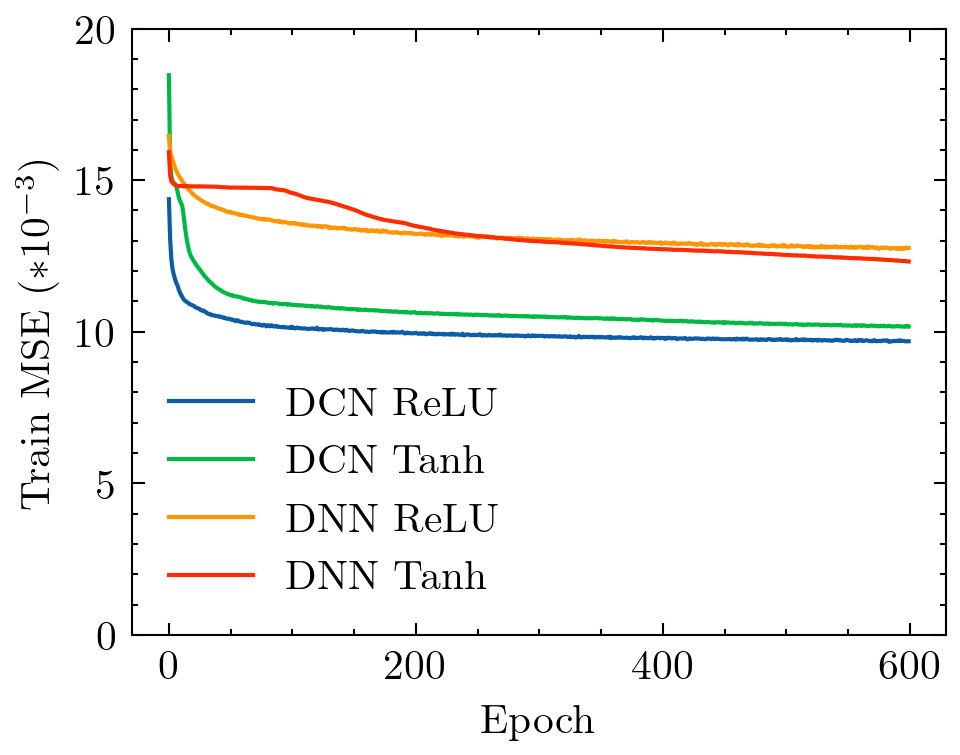

In [21]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(train_loss_list_cnn_ReLu_mult1000, label='DCN ReLU')
    plt.plot(train_loss_list_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(train_loss_list_dnn_ReLu_mult1000, label='DNN ReLU')
    plt.plot(train_loss_list_dnn_Tanh_mult1000, label='DNN Tanh')
    plt.xlabel('Epoch')
    plt.ylabel('Train MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Train Loss_compare.pdf')
    plt.show()

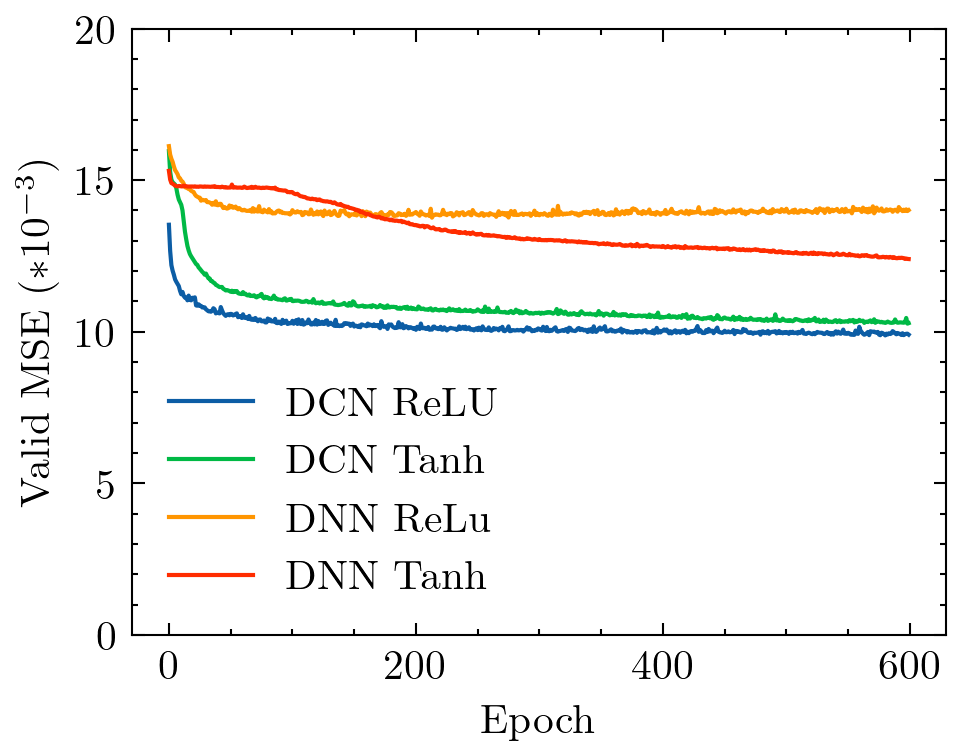

In [22]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(0, 20)
    plt.plot(valid_loss_list_cnn_ReLu_mult1000, label='DCN ReLU')
    plt.plot(valid_loss_list_cnn_tanh_mult1000, label='DCN Tanh')
    plt.plot(valid_loss_list_dnn_ReLu_mult1000, label='DNN ReLu')
    plt.plot(valid_loss_list_dnn_Tanh_mult1000, label='DNN Tanh')
    plt.xlabel('Epoch')
    plt.ylabel('Valid MSE ($ *10^{-3}$)')
    plt.legend()
    #save figure
    plt.savefig(figure_savepath + 'Valid Loss_compare.pdf')
    plt.show()